In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
import itertools
import json
import matplotlib.pyplot as plt

In [44]:
from utils import *

### Импортируем базу данных

In [45]:
conn = sqlite3.connect('trade_info.sqlite3')
chart_data = pd.read_sql('SELECT id, time, lot_size, session_id, deal_id, price FROM chart_data', conn)
trading_session = pd.read_sql('SELECT id, date, trading_type, platform_id FROM trading_session', conn)

```Deal_id – номер договора. Некоторые сделки дублируются, реальная сделка – та, что встречается раньше всех среди всех с одним deal_id```: Выбросим dummy-сделки из списка


In [46]:
chart_data = chart_data.drop_duplicates(subset=['deal_id'], keep='first')

In [47]:
chart_data.head()

,id,time,lot_size,session_id,deal_id,price
0,0,11:34:47,2,12,0,-0.235500
1,1,11:32:37,2,13,1,-0.235500
2,2,11:52:45,13,13,2,-0.303677
3,3,11:53:07,25,13,3,-0.303677
4,4,12:00:43,124,13,4,-0.364279


In [48]:
trading_session.head()

,id,date,trading_type,platform_id
0,11,2019-10-04,daily,1
1,12,2019-10-03,daily,2
2,13,2019-10-01,daily,2
3,14,2019-10-15,monthly,1
4,15,2019-10-15,monthly,2


### Объединим 2 таблицы в единую, используя session_id

In [49]:
new_df = tables_union(chart_data, trading_session)
new_df.head()

,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-03 11:34:47,0,2,12,0,-0.235500,daily,2.0
2019-10-01 11:32:37,1,2,13,1,-0.235500,daily,2.0
2019-10-01 11:52:45,2,13,13,2,-0.303677,daily,2.0
2019-10-01 11:53:07,3,25,13,3,-0.303677,daily,2.0
2019-10-01 12:00:43,4,124,13,4,-0.364279,daily,2.0


In [50]:
# ### checkpoint
# new_df.to_csv("new_df.csv")
# new_df_copy = new_df.copy()
# del new_df

# new_df = pd.read_csv("new_df.csv", index_col=['timestamp'])
# new_df.index = pd.to_datetime(new_df.index)
# pd.testing.assert_frame_equal(new_df, new_df_copy)

### 4 вида сессий

Вспомним, что у нас есть 2 площадки и 2 типа торгов. Разделим все сессии на 4 типа:

```
platform_id == 1 & trading_type == daily
platform_id == 1 & trading_type == monthly
platform_id == 2 & trading_type == daily
platform_id == 2 & trading_type == monthly
```

Также, проверим, что каждая сессия лежит только в одном из 4х типов торгов

In [51]:
plat1_day, plat1_month, plat2_day, plat2_month = separate_types(new_df) ###проверить сортировку
plat1_day.head()

Никакая из сессий не принадлежит одновременно хотя бы 2м типам


,id,lot_size,session_id,deal_id,price,trading_type,platform_id
timestamp,,,,,,,
2019-10-18 11:00:27,9,1,21,9,0.029634,daily,1.0
2019-10-18 11:02:23,10,36,21,10,0.029634,daily,1.0
2019-10-18 11:02:23,11,29,21,11,0.029634,daily,1.0
2019-10-18 11:02:23,12,18,21,12,0.029634,daily,1.0
2019-10-18 11:03:07,13,150,21,13,0.029634,daily,1.0


### Перефоматируем таблицы: объединим все сделки внутри сессии

Отсорируем сделки внутри каждой сессии по времени. Проверим, что никакая сделка не длилась более 1 дня. 

Также добавим новые признаки для каждой сессии:

- ```date``` - дата проведения сессии

- ```first_deal``` - время первой сделки

- ```last_deal``` - время последней сделки

- ```delta``` - прошедшее время между первой и последней сделкой

- ```start``` - начало сессии: округленное к началу часа время первой сделки

- ```only_time``` - timestamp каждой сделки без указания даты

- ```from_start```- для каждой сделки: кол-во секунд прошедших с начала сессии

- ```deal_count``` - кол-во сделок за сессию

- ```total_size``` - суммарный объем всех сделок за сессию

- ```avg_price``` - средневзвешенная цена за сессию (взвешиваем по объему)

- ```start_price``` - стартовая цена: средневзвешенная цена с прошлой сессии

In [52]:
sess_plat1_month = groupby_session_id(plat1_month)
sess_plat2_month = groupby_session_id(plat2_month)
sess_plat1_day = groupby_session_id(plat1_day)
sess_plat2_day = groupby_session_id(plat2_day)

sess_plat1_month.head()

,session_id,timestamp,id,lot_size,deal_id,price,trading_type,platform_id,date,first_deal,...,delta,start,end,full_delta,session_type,deal_count,total_size,avg_price,last_price,start_price
0,35,[2019-02-21T11:05:02.000000000],[1114],[1],[688],[-0.7354659067511725],monthly,1.0,2019-02-21,11:05:02,...,0 days 00:00:00,2019-02-21 11:00:00,2019-02-21 12:01:00,0 days 01:01:00,typical,1,1,-0.735466,-0.735466,NaN
1,39,"[2019-03-22T11:05:02.000000000, 2019-03-22T11:...","[927, 928, 926, 929, 930, 931, 932, 933, 934, ...","[16, 4, 17, 1, 150, 500, 41, 7, 2, 450, 150, 5...","[648, 649, 647, 650, 651, 652, 653, 654, 655, ...","[-0.7657668914107529, -0.7657668914107529, -0....",monthly,1.0,2019-03-22,11:05:02,...,0 days 01:53:10,2019-03-22 11:00:00,2019-03-22 13:01:00,0 days 02:01:00,untypical,147,9646,-1.060704,-1.182405,-0.735466
2,37,"[2019-04-23T11:34:25.000000000, 2019-04-23T11:...","[623, 621, 624, 622, 620, 625, 626, 627, 628, ...","[48, 302, 2, 50, 1, 120, 6, 600, 5, 1, 1, 557,...","[395, 393, 396, 394, 392, 397, 398, 399, 400, ...","[-0.7657668914107529, -0.7278906605862775, -0....",monthly,1.0,2019-04-23,11:34:25,...,0 days 00:25:34,2019-04-23 11:00:00,2019-04-23 12:01:00,0 days 01:01:00,typical,51,4244,-0.785851,-0.909697,-1.060704
3,41,"[2019-08-23T11:01:06.000000000, 2019-08-23T11:...","[1117, 1116, 1119, 1118, 1120, 1126, 1125, 112...","[1, 8, 13, 3, 1, 1, 1, 1, 25, 469, 3, 31, 33, ...","[691, 690, 693, 692, 694, 700, 699, 698, 697, ...","[-0.04611850574571931, -0.04611850574571931, -...",monthly,1.0,2019-08-23,11:01:06,...,0 days 00:58:33,2019-08-23 11:00:00,2019-08-23 12:01:00,0 days 01:01:00,typical,57,2914,-0.049891,-0.083995,-0.785851
4,30,"[2019-09-23T11:03:17.000000000, 2019-09-23T11:...","[318, 319, 320, 321, 322, 329, 330, 328, 331, ...","[5, 95, 34, 1, 1, 2, 2, 19, 12, 1, 1, 1, 1, 1,...","[318, 319, 320, 321, 322, 329, 330, 328, 331, ...","[0.10538641755218249, 0.10538641755218249, 0.1...",monthly,1.0,2019-09-23,11:03:17,...,0 days 00:56:32,2019-09-23 11:00:00,2019-09-23 12:01:00,0 days 01:01:00,typical,67,3177,0.028971,-0.030968,-0.049891


### Точные границы сессий

Установим точные границы каждой торговой сессии. чтобы нарисовать точный график. Мы знаем, что месячные торги длятся 60 минут. Судя по данным, они идут с 11:00:00 до 12:00:00. Однако, встречаются вхождения, где последняя сделка заключена между 12:00:00 и 12:01:00, причем в некоторых сессиях эта сделка проходит по цене, отличной от цены на интервале [11:59:00, 12:00:00]. [На сайте биржы](https://spimex.com/markets/gas/trades/schedule/) в расписании есть следующая пометка:

```* - время начала и время окончания торговых сессий находится в пределах указанного времени с точностью до одной минуты.```

Поэтому будем рисовать график каждой сессии так, что в нем будет 61 минута. 

### Месячные торги: площадка 1

Проверим для месячных торгов на 1ой площадке, что каждая сессия содержится в [11:00:00, 12:01:00]. Для этого посмотрим на время первой и последней сделок

In [53]:
limits = [(datetime.time(11, 0, 0), datetime.time(12, 1, 0))]

separate_deals(sess_plat1_month, limits)

Correct_deals
      date |                    | cnt | total size
2019-02-21 | 11:05:02  11:05:02 |   1 |    1
2021-06-23 | 11:01:41  11:57:08 |  35 | 2630
2020-10-23 | 11:01:18  11:57:36 |  45 | 3716
2020-07-27 | 11:00:14  11:57:55 |  53 | 5398
2020-12-23 | 11:05:00  11:58:23 |  40 | 2910
2021-02-18 | 11:00:14  11:58:44 |  22 | 2503
2020-11-23 | 11:00:06  11:58:53 |  45 | 5066
2020-05-22 | 11:13:29  11:59:04 |  52 | 4987
2020-08-24 | 11:40:12  11:59:15 |  52 | 6211
2019-08-23 | 11:01:06  11:59:39 |  57 | 2914
2020-04-23 | 11:00:33  11:59:42 |  28 | 4528
2021-05-24 | 11:34:48  11:59:49 |  15 | 1274
2019-09-23 | 11:03:17  11:59:49 |  67 | 3177
2020-09-23 | 11:01:25  11:59:50 |  22 | 1565
2020-03-24 | 11:13:51  11:59:51 |  49 | 5680
2021-04-23 | 11:42:32  11:59:53 |  34 | 1145
2021-03-24 | 11:05:06  11:59:54 |  29 | 2158
2020-02-20 | 11:01:31  11:59:56 |  62 | 4875
2019-11-22 | 11:08:56  11:59:57 |  21 | 1156
2019-04-23 | 11:34:25  11:59:59 |  51 | 4244
2019-10-24 | 11:04:47  12:00:01 |  

Видим, что у нас есть 2 нетипичные сессии:

- Сессия от 2019-12-24 скорее всего проходила в отрезке [12:00:00, 13:01:00], и тогда она удовлетворяет условию на 61 минуту.

- Сессия от 2019-03-22 скорее всего проходила в отрезке [11:00:00, 13:01:00], то есть длилась 2 часа. Кол-во сделок и суммарный объем сделок, говорят о том, что сессию могли продлить ...... дописать

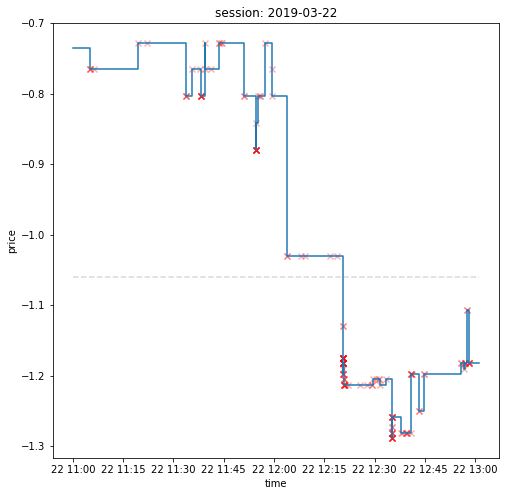

In [54]:
dates = [datetime.date(2019, 3, 22)]
show_session_dates(sess_plat1_month, dates, figsize=8)

### Месячные торги: площадка 2

Проверим для месячных торгов на 2ой площадке, что каждая сессия содержится либо в [11:00:00, 12:01:00], либо в [12:00:00, 13:01:00]

Нетипичных сделок нет

In [55]:
limits = [(datetime.time(11, 0, 0), datetime.time(12, 1, 0)), 
          (datetime.time(12, 0, 0), datetime.time(13, 1, 0))]

separate_deals(sess_plat2_month, limits)

Correct_deals
      date |                    | cnt | total size
2019-02-21 | 11:05:02  11:05:02 |   1 |    1
2019-12-24 | 11:01:13  12:00:14 |  74 | 5785
2020-04-23 | 12:00:15  12:55:54 |  81 | 3975
2021-03-24 | 12:50:37  12:56:34 |   6 |   11
2020-05-22 | 12:00:03  12:59:01 |  72 | 3429
2020-07-27 | 12:05:45  12:59:03 |  51 | 3896
2020-06-22 | 12:01:23  12:59:04 |  79 | 5089
2021-06-23 | 12:00:02  12:59:21 |  29 |  908
2020-12-23 | 12:11:28  12:59:21 |  78 | 5452
2021-02-18 | 12:02:15  12:59:22 |  34 | 2190
2020-09-23 | 12:33:20  12:59:30 |  45 | 1875
2021-05-24 | 12:06:41  12:59:31 |  32 |  733
2020-02-20 | 12:00:57  12:59:39 | 132 | 9253
2019-08-23 | 12:08:17  12:59:41 |  68 | 3222
2019-11-22 | 12:12:19  12:59:41 |  98 | 3705
2019-04-23 | 12:02:52  12:59:47 |  98 | 3816
2020-03-24 | 12:01:06  12:59:50 | 110 | 6072
2020-11-23 | 12:00:03  12:59:54 |  80 | 6455
2019-09-23 | 12:00:48  12:59:55 | 126 | 4288
2021-04-23 | 12:40:02  12:59:57 |  25 |  334
2020-01-24 | 12:19:31  12:59:57 | 1

### Суточные торги: площадка 1

Проверим следующие временные отрезки:

- [10:00:00, 10:31:00]
- [11:00:00, 11:31:00]
- [11:30:00, 12:01:00]
- [12:00:00, 12:31:00]

In [56]:
limits = [(datetime.time(10, 0, 0), datetime.time(10, 31, 0)),
          (datetime.time(11, 0, 0), datetime.time(11, 31, 0)), 
          (datetime.time(11, 30, 0), datetime.time(12, 1, 0)),
          (datetime.time(12, 0, 0), datetime.time(12, 31, 0))]

separate_deals(sess_plat1_day, limits)

Correct_deals
      date |                    | cnt | total size
2019-11-05 | 10:00:00  10:00:00 |   1 |  210
2020-07-07 | 11:00:22  11:00:22 |   2 |  150
2020-07-06 | 11:00:49  11:00:49 |   2 |  120
2021-06-24 | 11:01:06  11:01:06 |   4 |  500
2021-04-19 | 11:00:51  11:01:06 |   4 |  503
2020-10-19 | 11:01:22  11:01:22 |   2 |  851
2020-10-26 | 11:00:37  11:01:23 |   3 |  851
2021-04-21 | 11:00:50  11:01:30 |   5 | 1105
2021-04-22 | 11:00:56  11:02:06 |   3 | 1301
2021-04-30 | 11:00:22  11:02:30 |   3 |  800
2020-09-15 | 11:02:20  11:02:41 |   4 |  181
2020-07-02 | 11:01:41  11:03:04 |   2 |  120
2020-02-26 | 11:00:56  11:03:20 |   7 |  723
2021-04-20 | 11:03:31  11:03:31 |   3 |  502
2021-03-11 | 11:00:20  11:03:35 |   4 |   56
2021-06-10 | 11:00:11  11:04:16 |   4 |  222
2021-06-11 | 11:00:10  11:04:38 |   4 |  272
2020-05-14 | 11:04:51  11:05:34 |   3 |  120
2020-09-10 | 11:00:08  11:06:05 |   5 |  580
2021-03-10 | 11:00:20  11:06:11 |   3 |  104
2020-10-16 | 11:06:51  11:06:51 |  

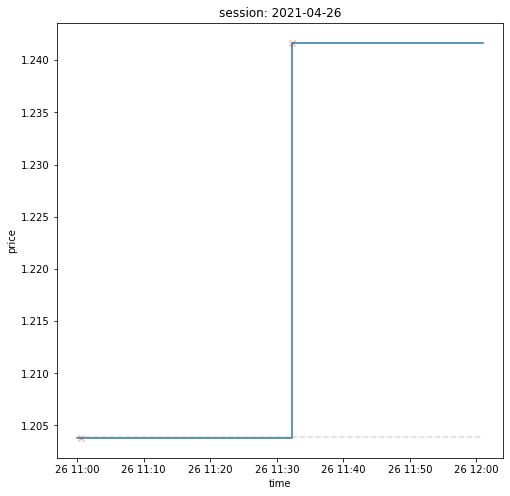

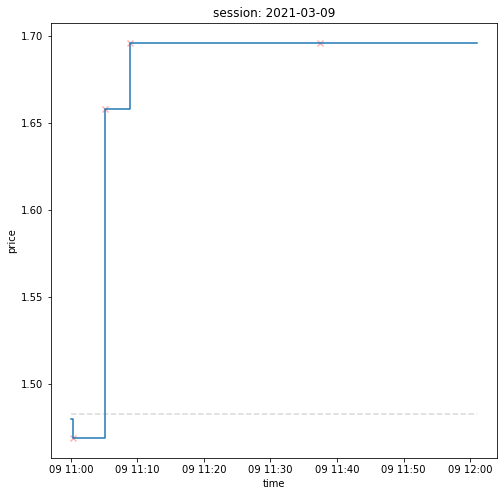

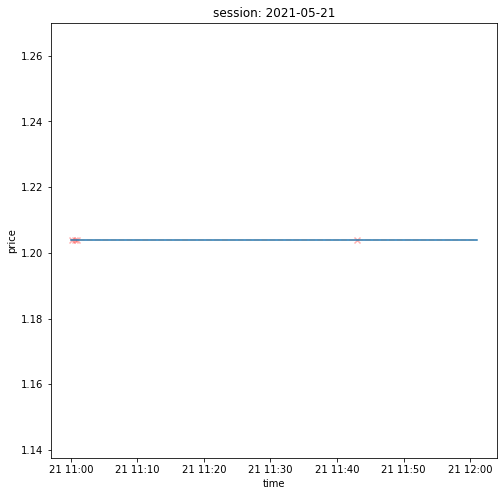

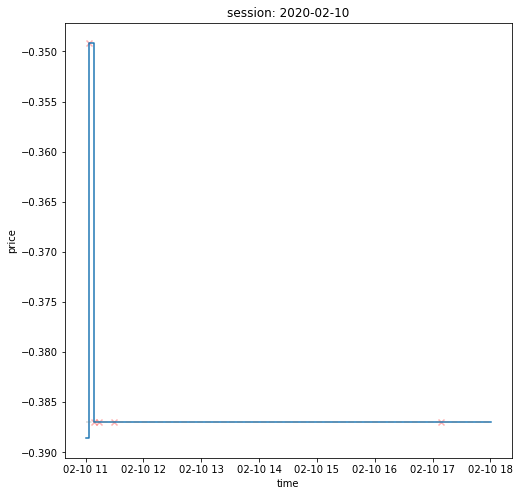

In [57]:
dates_3 = [datetime.date(2021, 4, 26),
           datetime.date(2021, 3, 9),
           datetime.date(2021, 5, 21),
           datetime.date(2020, 2, 10)]

show_session_dates(sess_plat1_day, dates_3, figsize=8)

In [58]:
# дописать

### Суточные торги: площадка 2

Проверим следующие временные отрезки:

- [10:00:00, 10:31:00]
- [11:00:00, 11:31:00]
- [11:30:00, 12:01:00]
- [12:00:00, 12:31:00]

In [37]:
limits = [(datetime.time(10, 0, 0), datetime.time(10, 31, 0)),
          (datetime.time(11, 0, 0), datetime.time(11, 31, 0)), 
          (datetime.time(11, 30, 0), datetime.time(12, 1, 0)),
          (datetime.time(12, 0, 0), datetime.time(12, 31, 0))]

separate_deals(sess_plat2_day, limits)

Correct_deals
      date |                    | cnt | total size
2019-12-20 | 11:00:24  11:01:13 |   4 |  354
2021-05-18 | 11:30:02  11:30:02 |   1 |    1
2021-06-21 | 11:30:15  11:30:15 |   5 |   19
2019-12-25 | 11:00:19  11:30:16 |   5 |   66
2021-06-10 | 11:30:18  11:30:18 |   2 |   11
2019-12-23 | 11:00:21  11:30:19 |   5 |   75
2020-01-29 | 11:30:21  11:30:38 |  12 |  517
2021-06-22 | 11:30:25  11:30:42 |   9 |   34
2021-03-17 | 11:30:57  11:30:57 |   1 |    1
2021-06-11 | 11:30:12  11:31:10 |  10 |   36
2021-05-19 | 11:31:20  11:31:20 |   1 |    2
2020-10-26 | 11:30:27  11:31:25 |  25 |  906
2020-09-16 | 11:30:00  11:31:29 |  22 |  268
2020-02-14 | 11:31:54  11:31:54 |  21 | 1015
2020-07-06 | 11:30:18  11:32:56 |  11 |  272
2020-06-30 | 11:30:54  11:33:31 |  10 |  243
2021-04-27 | 11:33:55  11:33:55 |   1 |    2
2020-02-25 | 11:32:06  11:33:56 |   8 |  496
2020-02-12 | 11:31:30  11:33:58 |  21 | 1015
2020-02-26 | 11:31:14  11:34:09 |   7 |  494
2021-02-12 | 11:31:35  11:34:39 |  

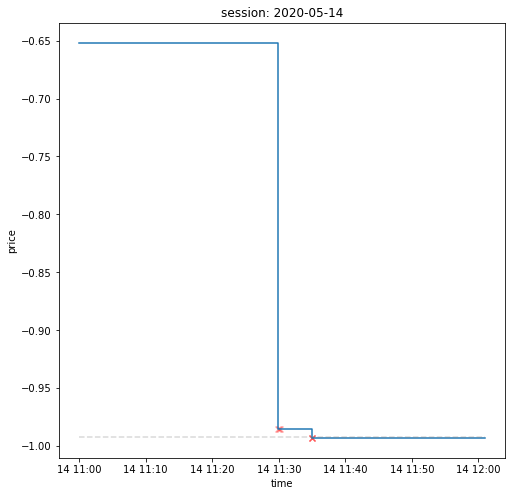

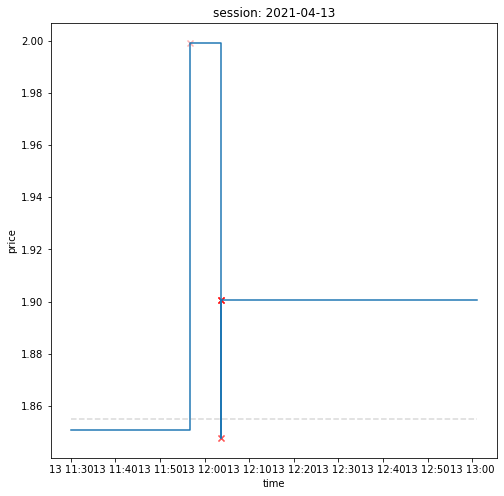

In [38]:
dates_4 = [datetime.date(2020, 5, 14),
           datetime.date(2021, 4, 13)]

show_session_dates(sess_plat2_day, dates_4, figsize=8)

In [39]:
# дописать

### История

Построим графики цены за все несколько лет для каждого из 4х типов торгов 

Добавить описание: 
- кол-во сделок
- периоды спада
- периоды роста
- периоды затишья
- сравнение площадок
- сравнение месяц/день

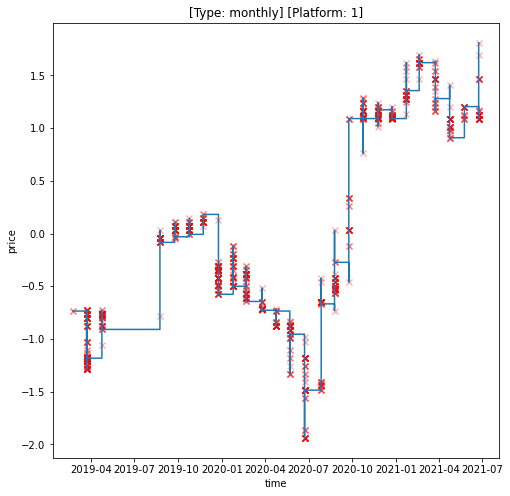

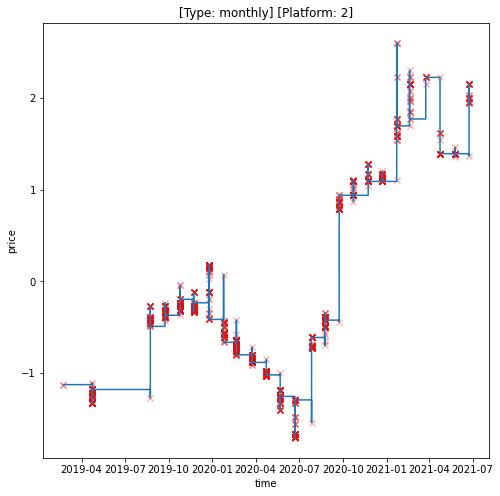

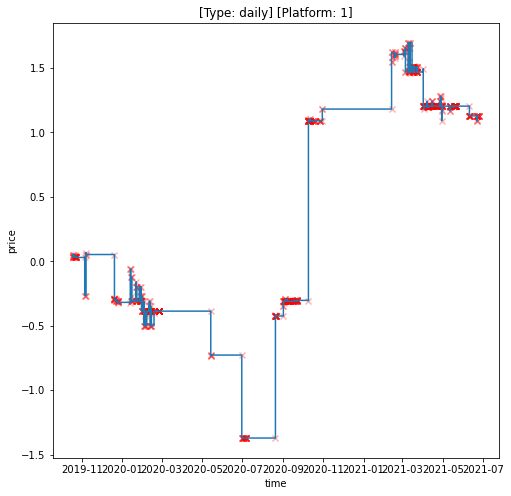

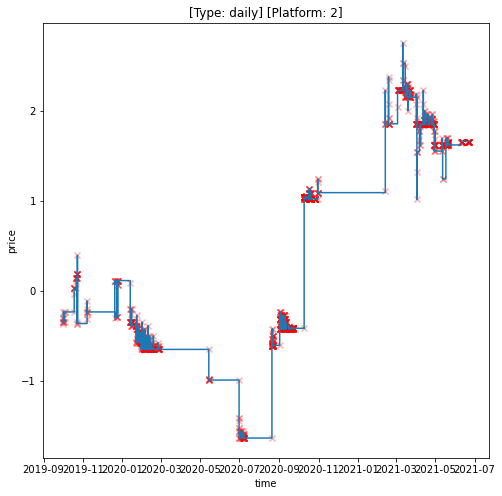

In [40]:
for sess in [sess_plat1_month, sess_plat2_month, sess_plat1_day, sess_plat2_day]:
    title = f"[Type: {np.unique(sess.trading_type)[0]}] [Platform: {int(np.unique(sess.platform_id)[0])}]"
    global_trend(sess, title=title, figsize=8)

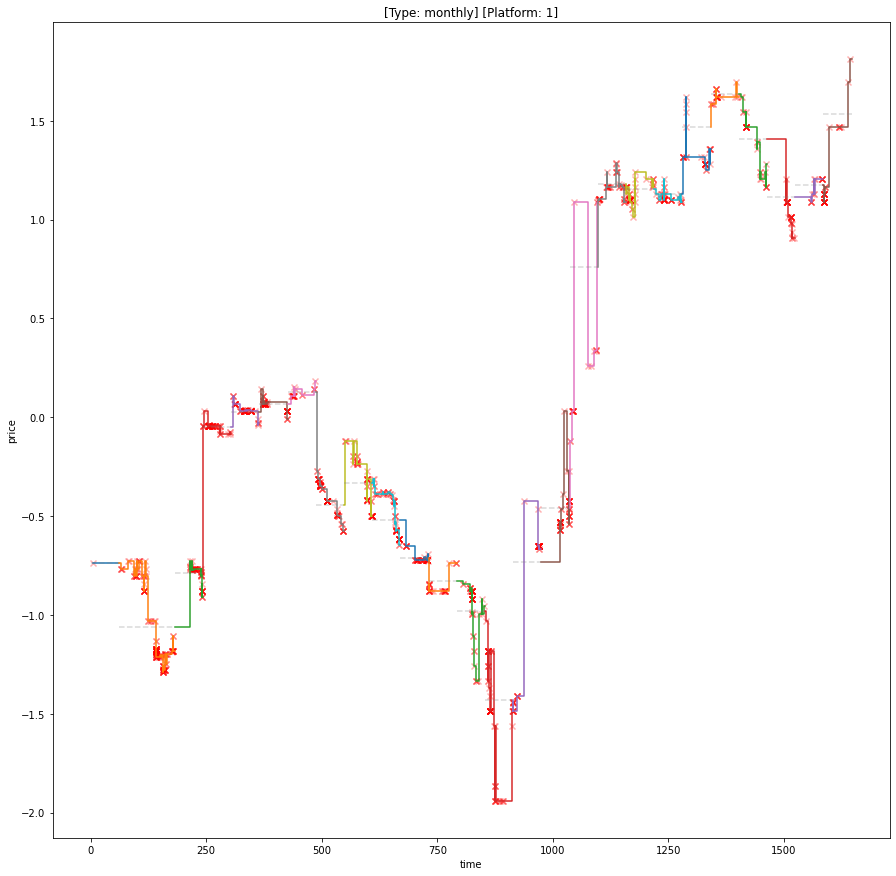

In [41]:
title = f"[Type: {np.unique(sess_plat1_month.trading_type)[0]}] [Platform: {int(np.unique(sess_plat1_month.platform_id)[0])}]"
global_trend_gaps(sess_plat1_month, title=title, figsize=15)

### Графики отдельных сессий

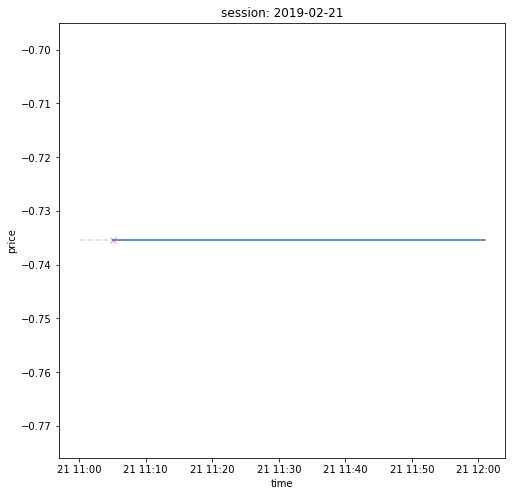

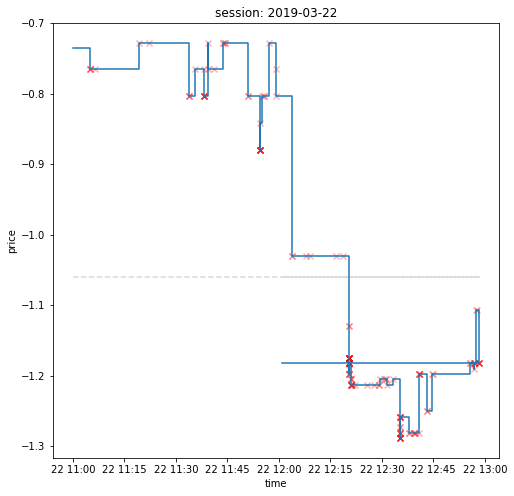

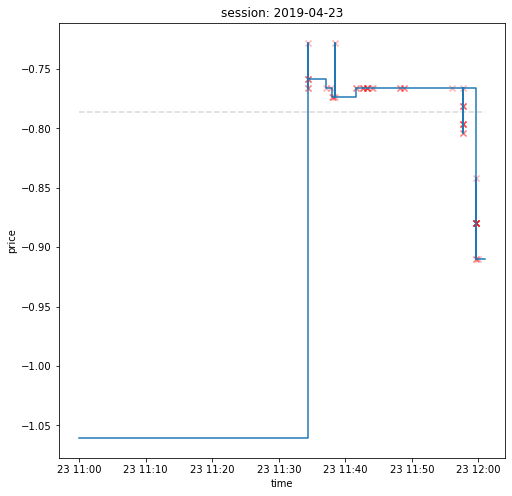

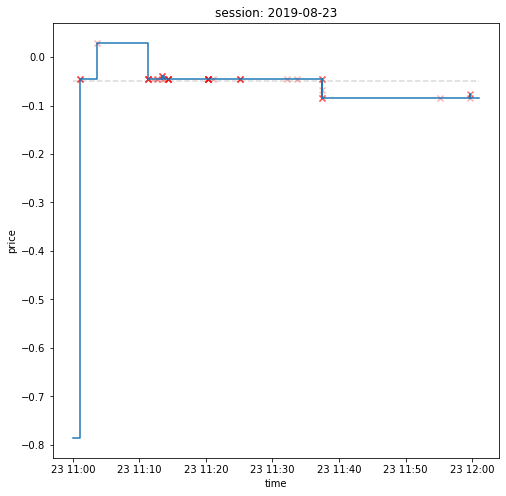

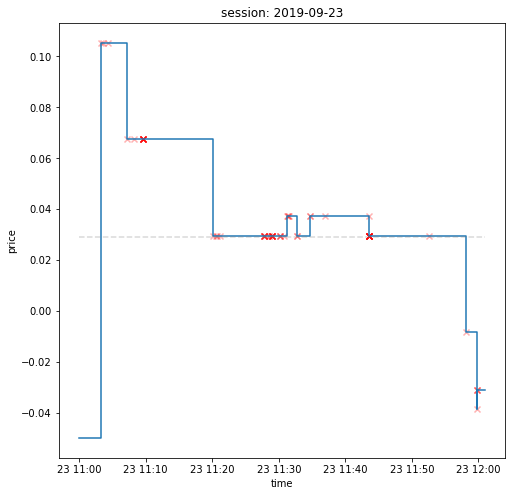

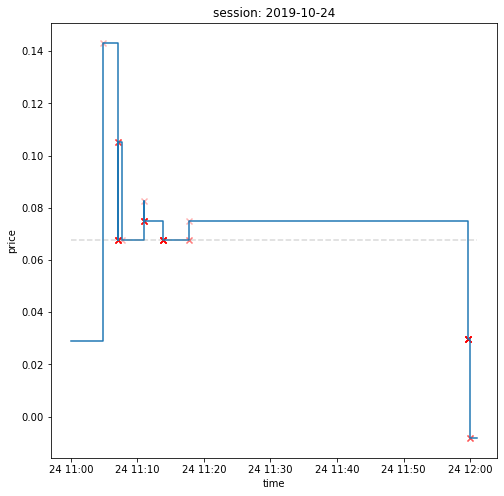

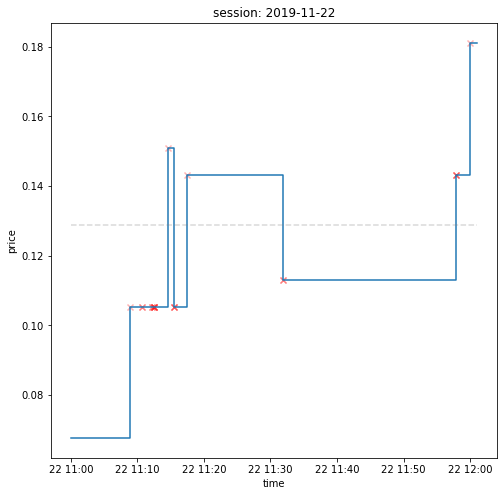

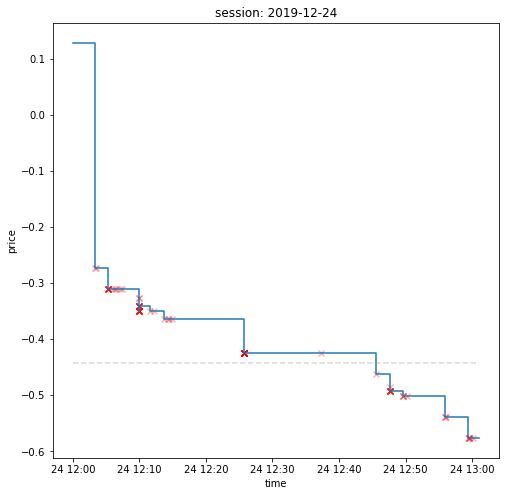

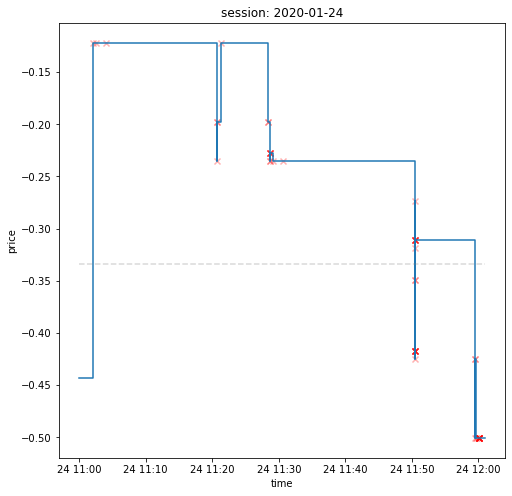

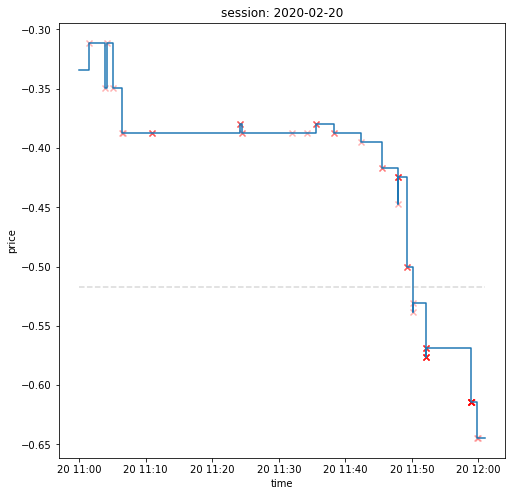

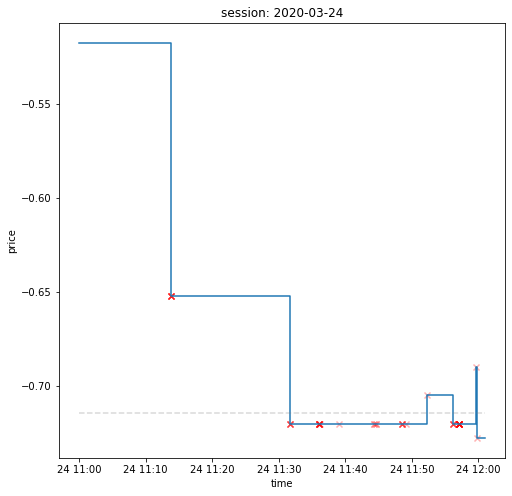

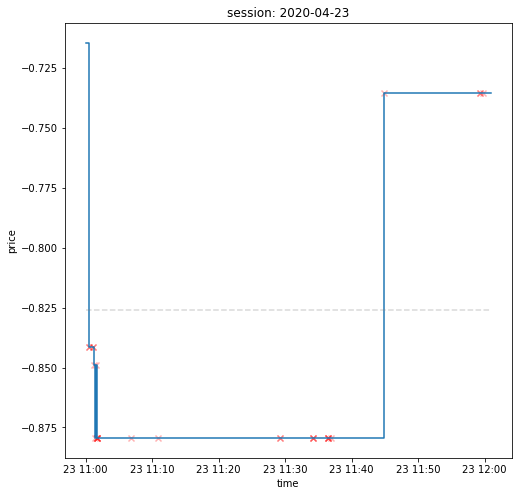

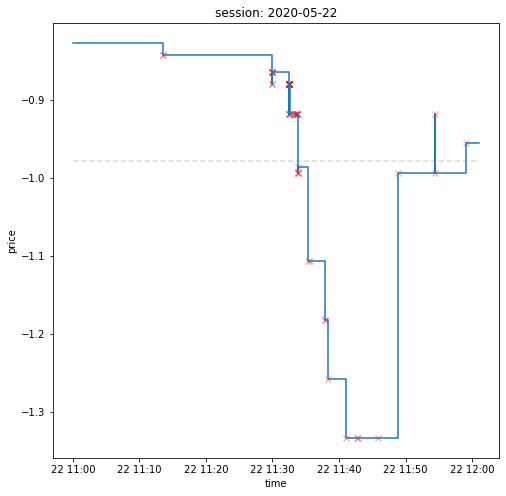

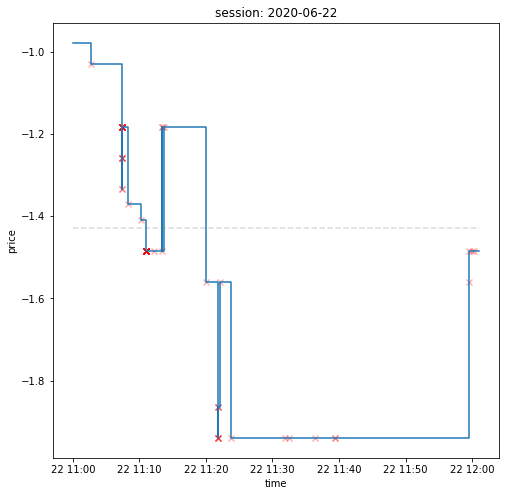

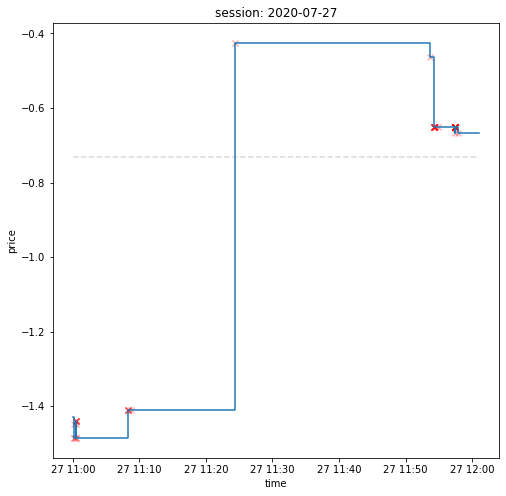

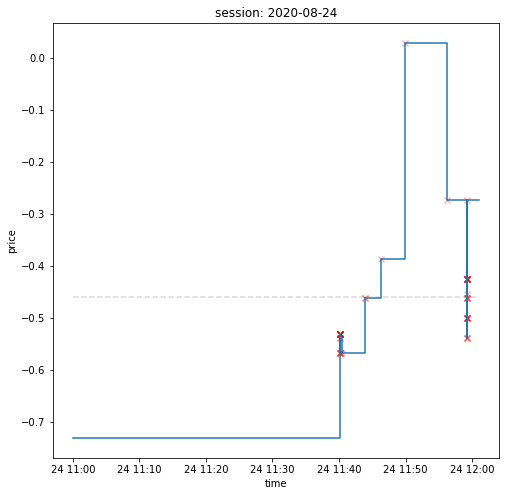

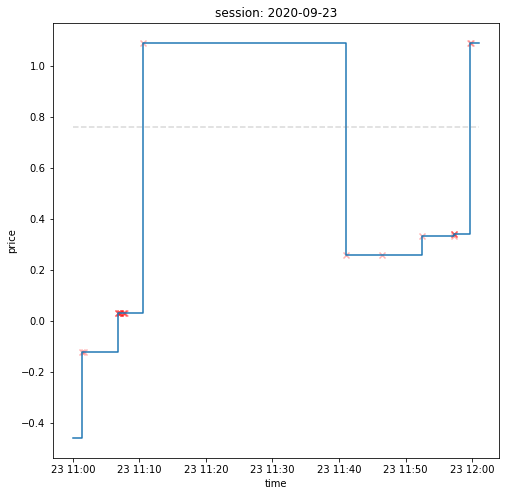

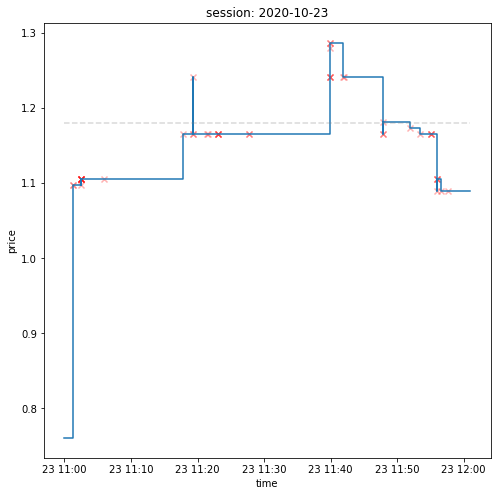

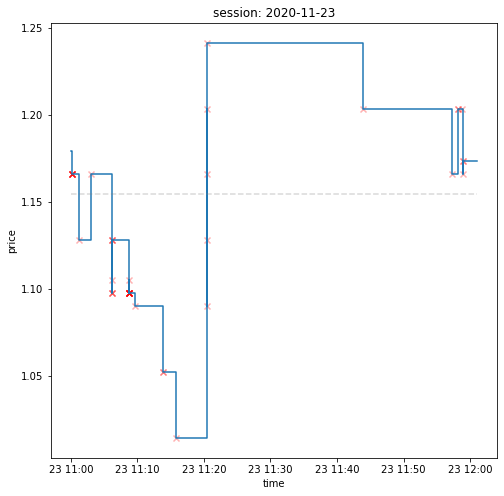

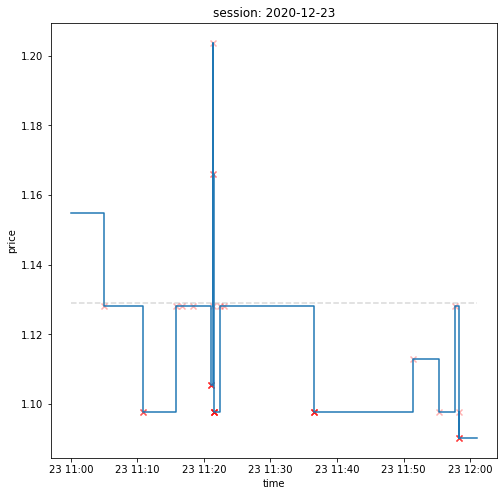

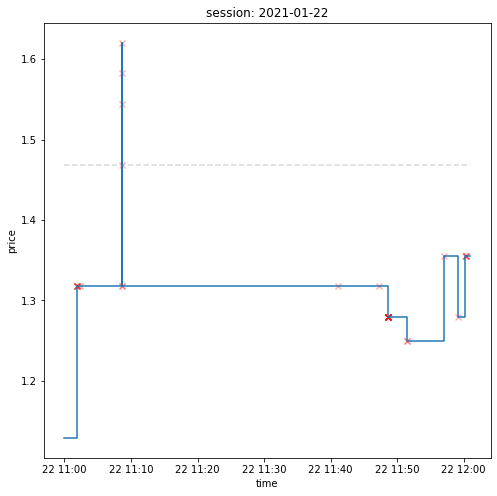

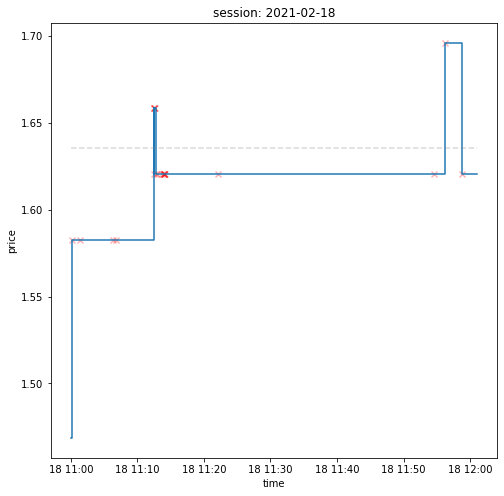

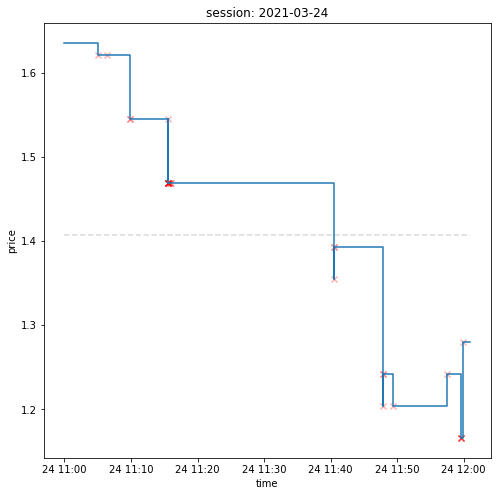

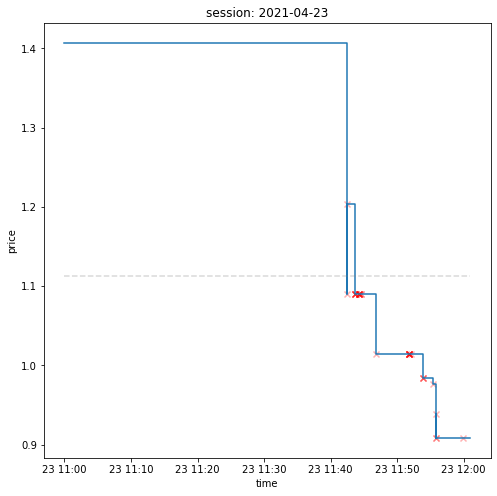

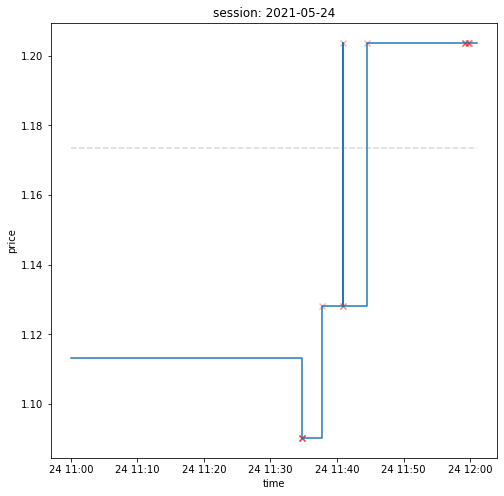

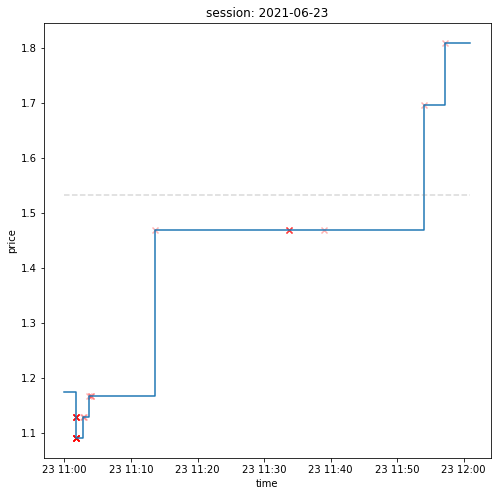

In [397]:
all_session(sess_plat1_month, figsize=8)

In [398]:
### детально

In [399]:
all_session_one_pic_step(sess_plat1_month)

AttributeError: 'Series' object has no attribute 'from_start'

In [674]:
###

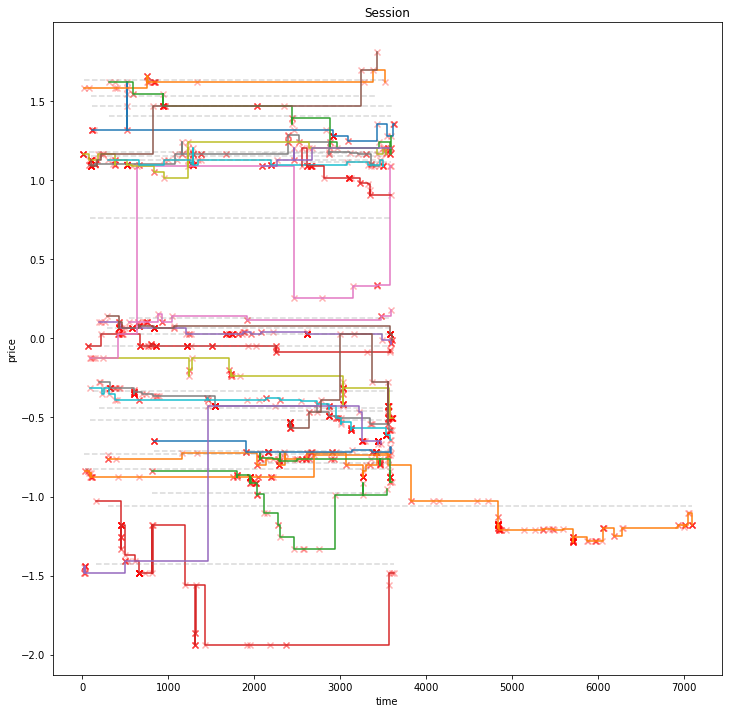

In [697]:
all_session_one_pic(sess_plat1_month)

In [694]:
np.array([1, 1, 1, 1]) + 5

array([6, 6, 6, 6])

In [716]:
### переместить отрезки в нужный период

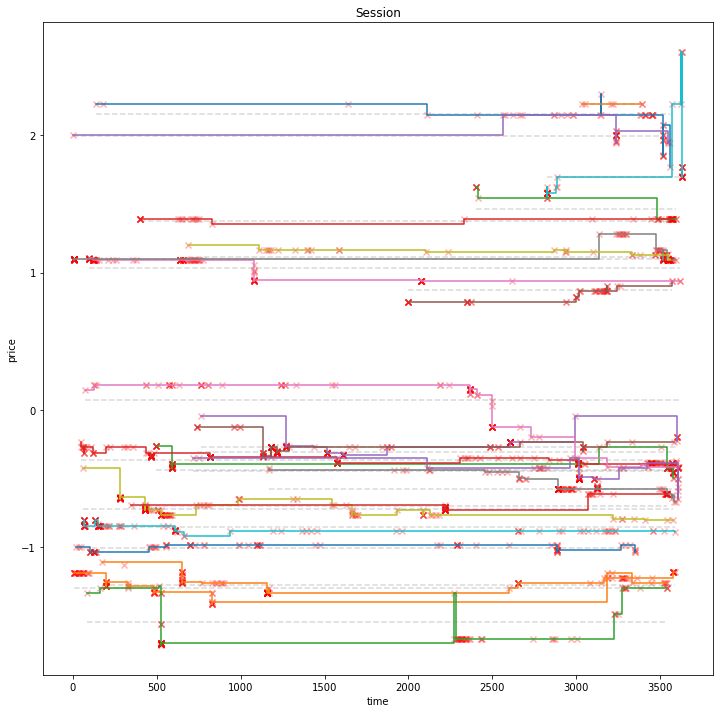

In [713]:
all_session_one_pic(sess_plat2_month)

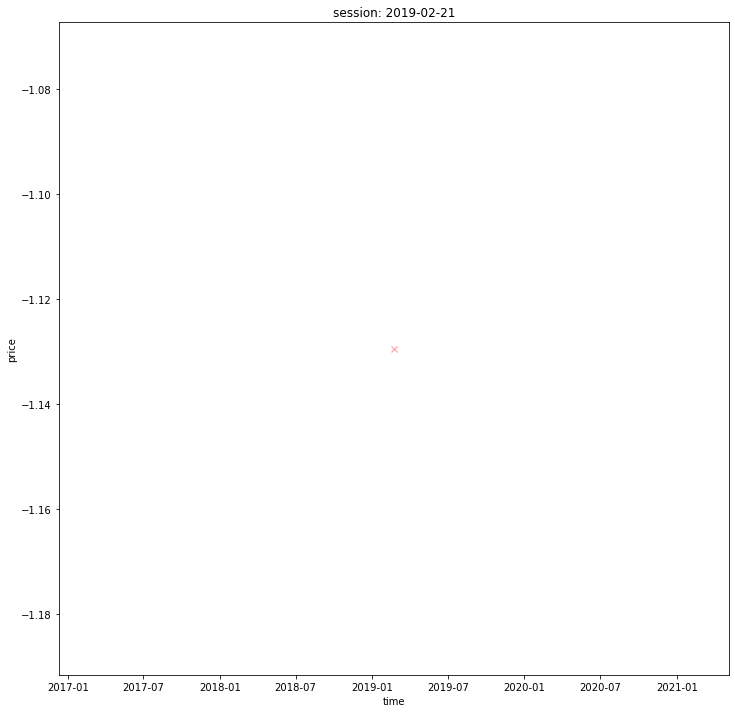

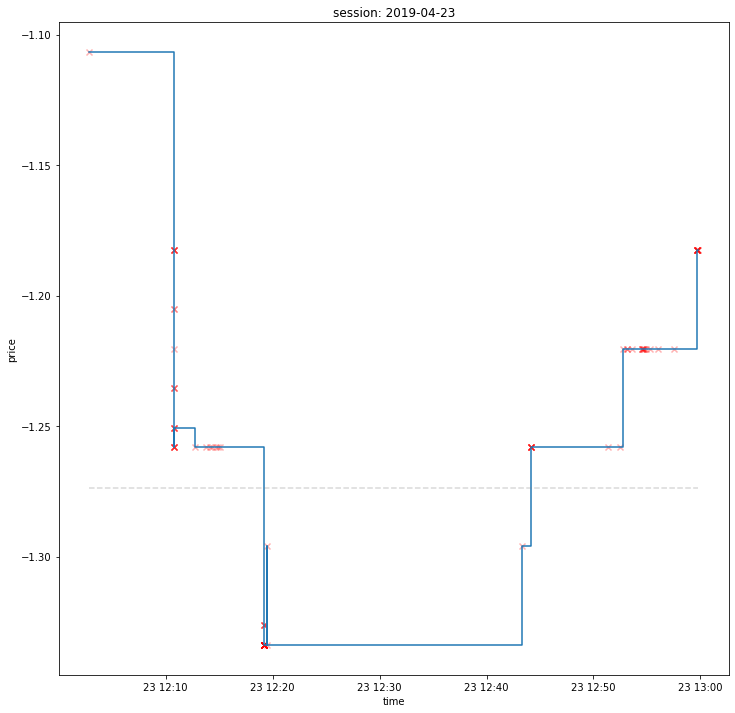

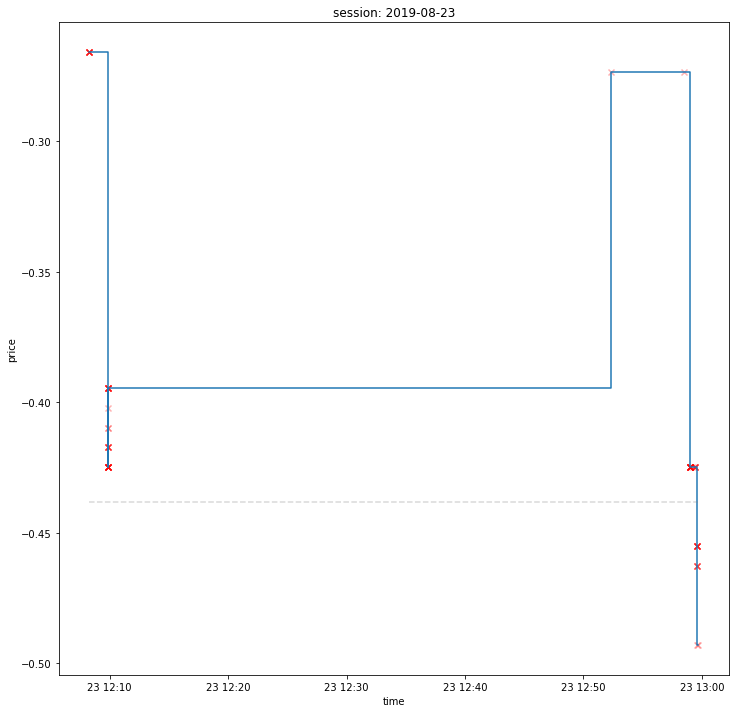

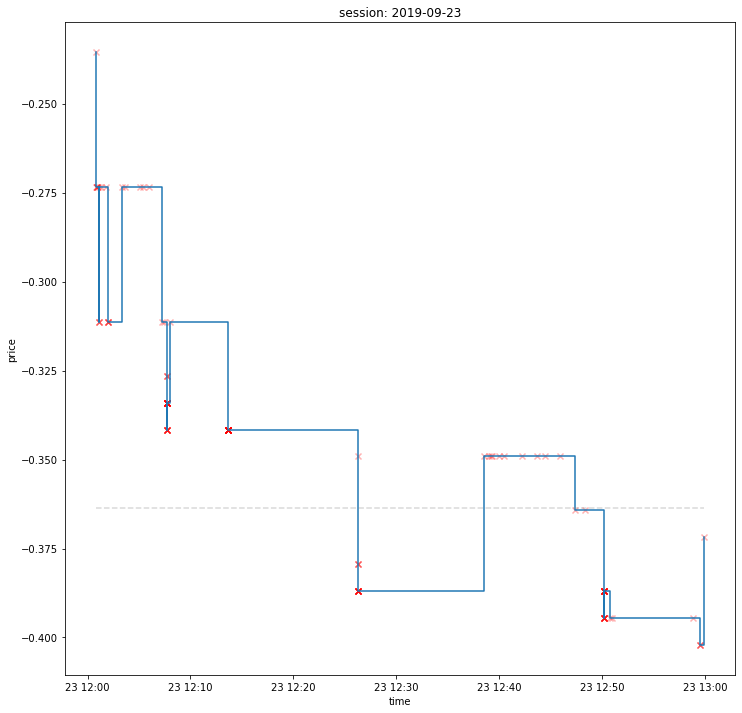

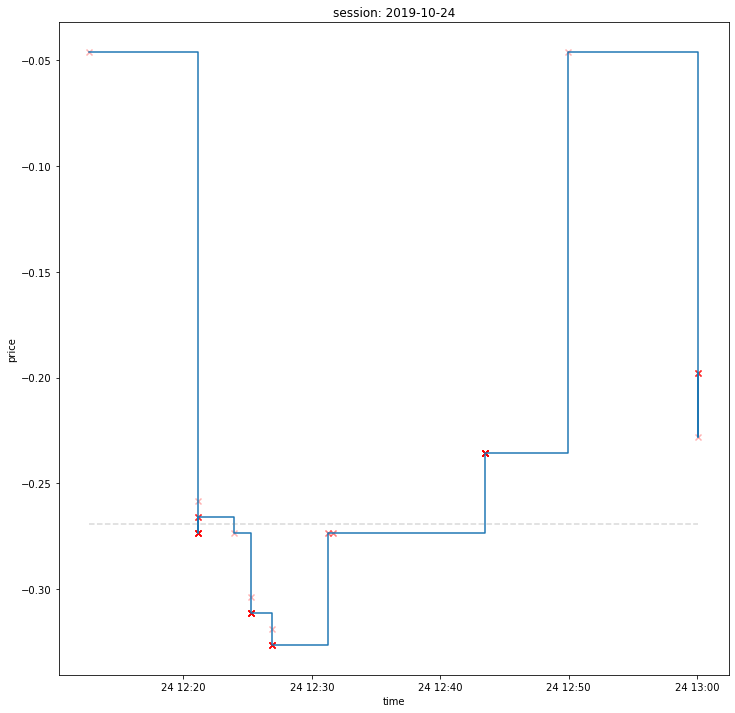

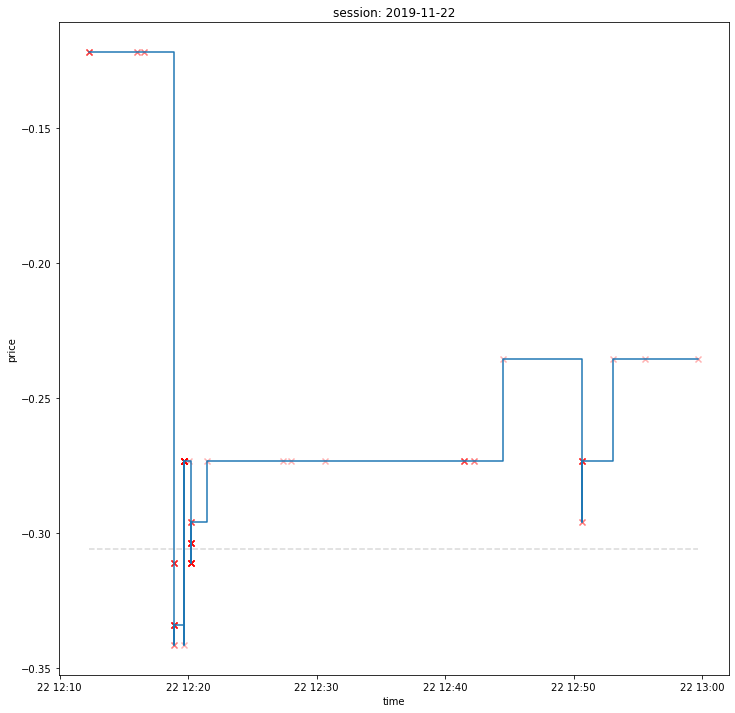

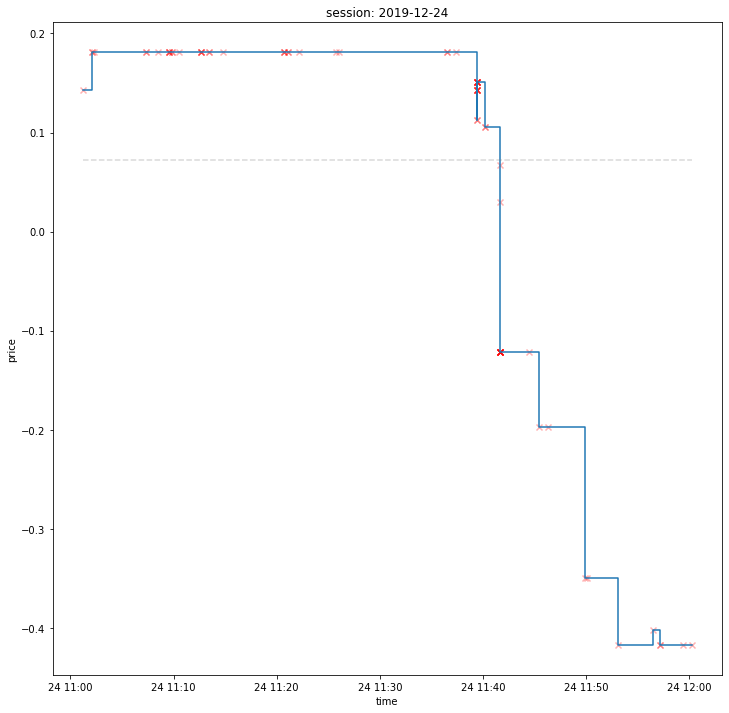

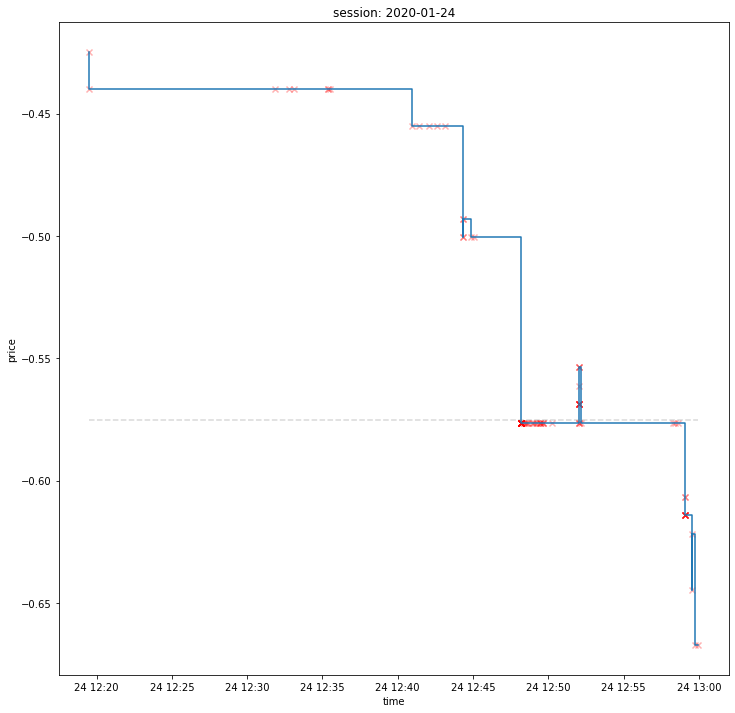

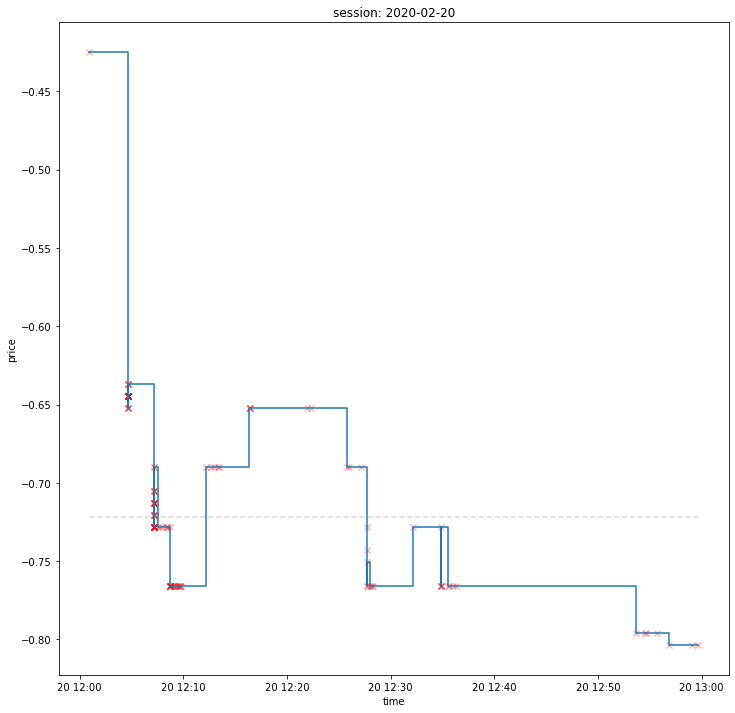

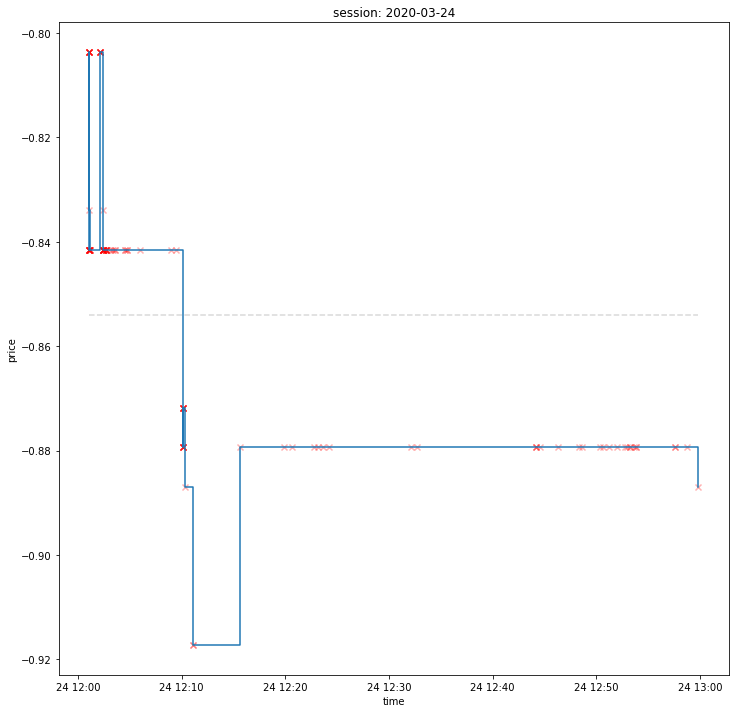

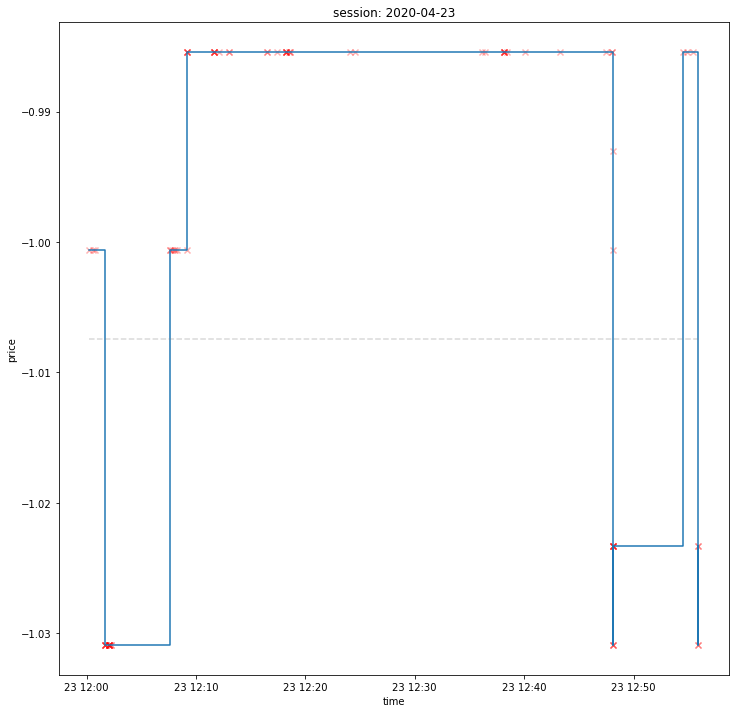

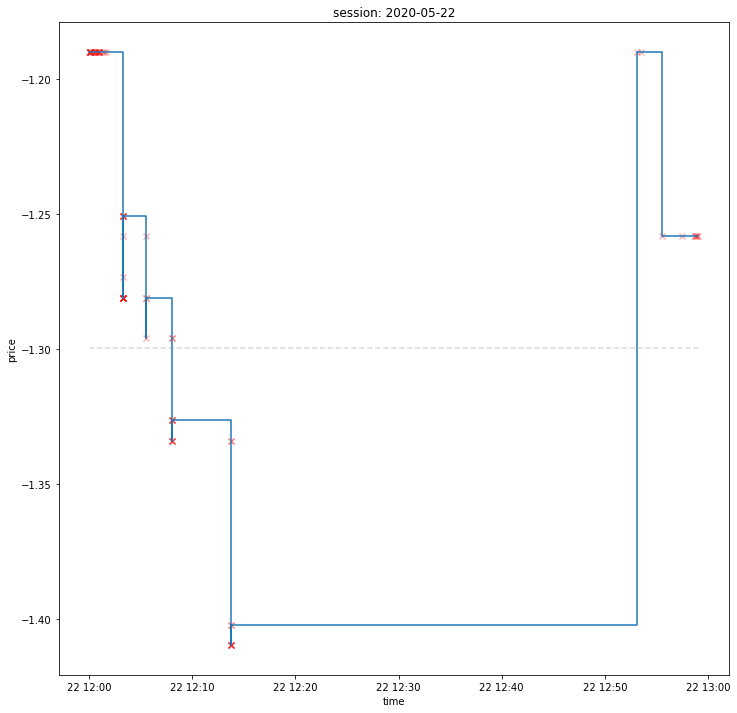

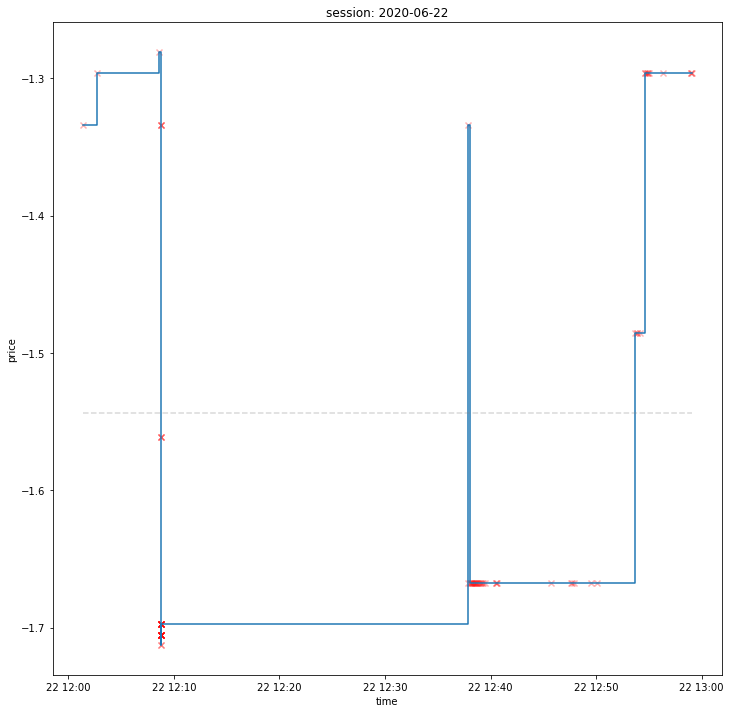

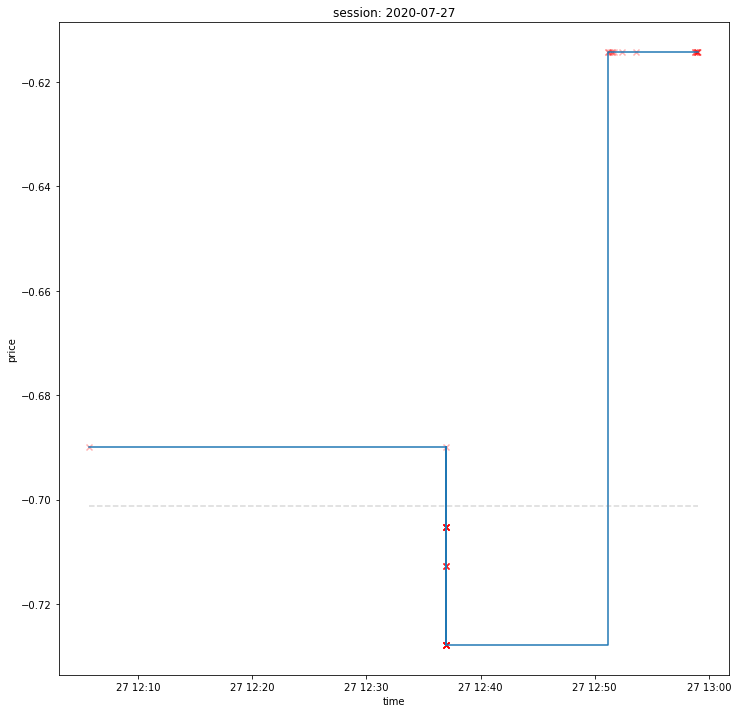

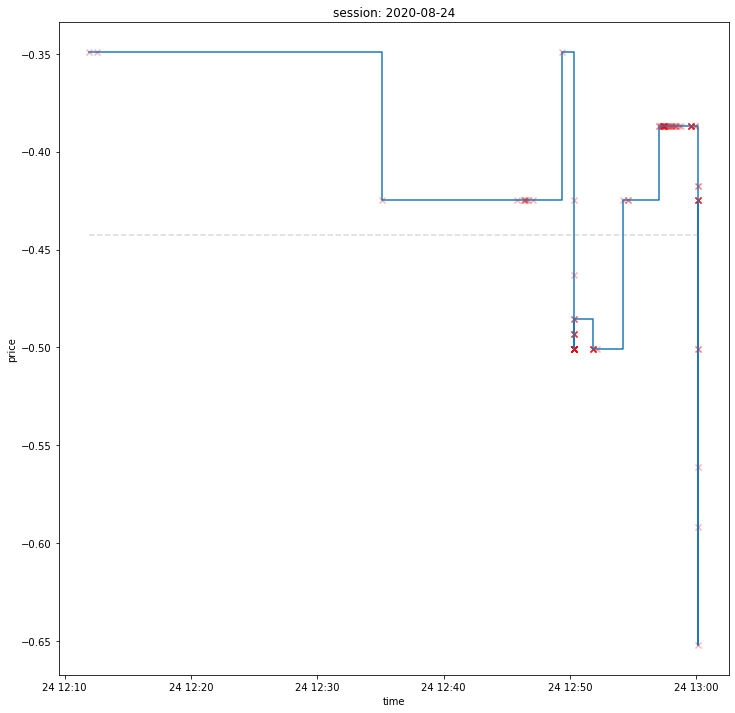

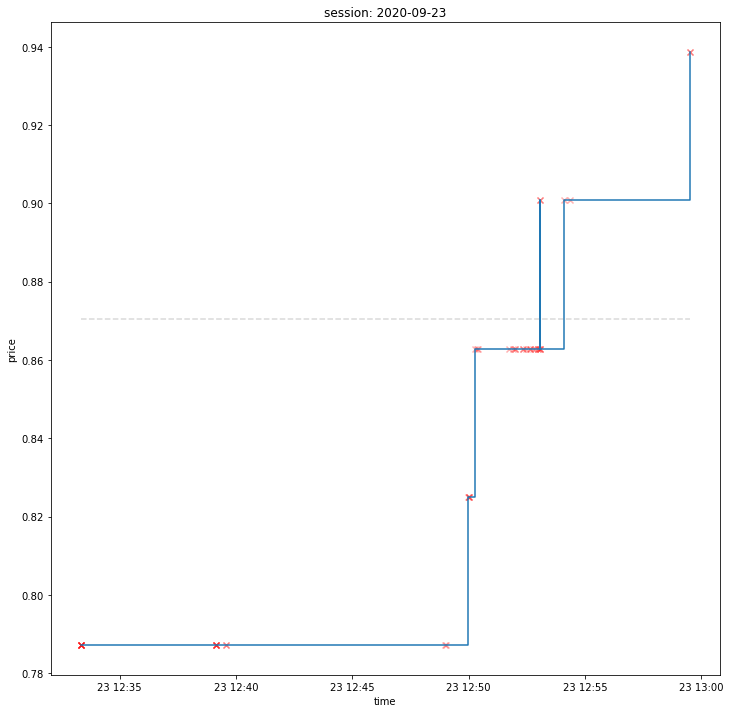

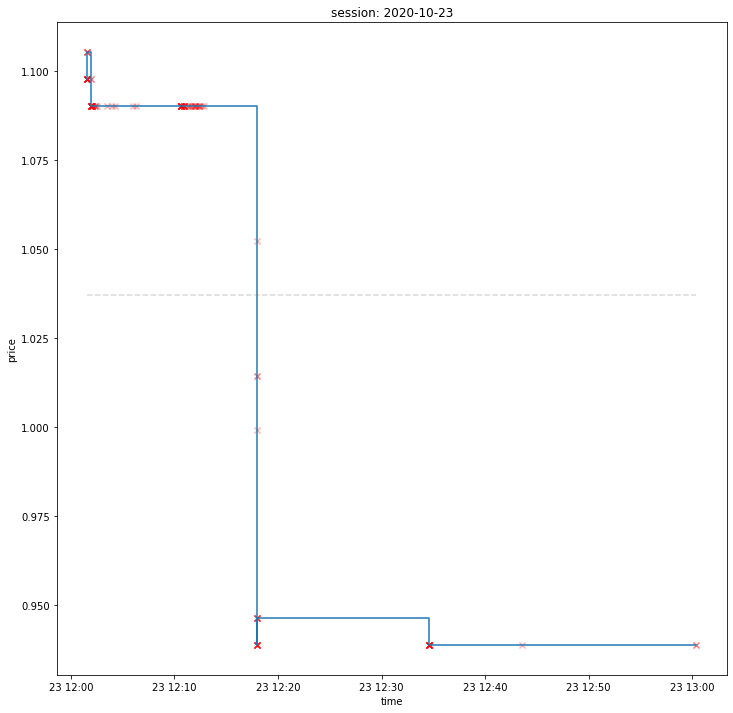

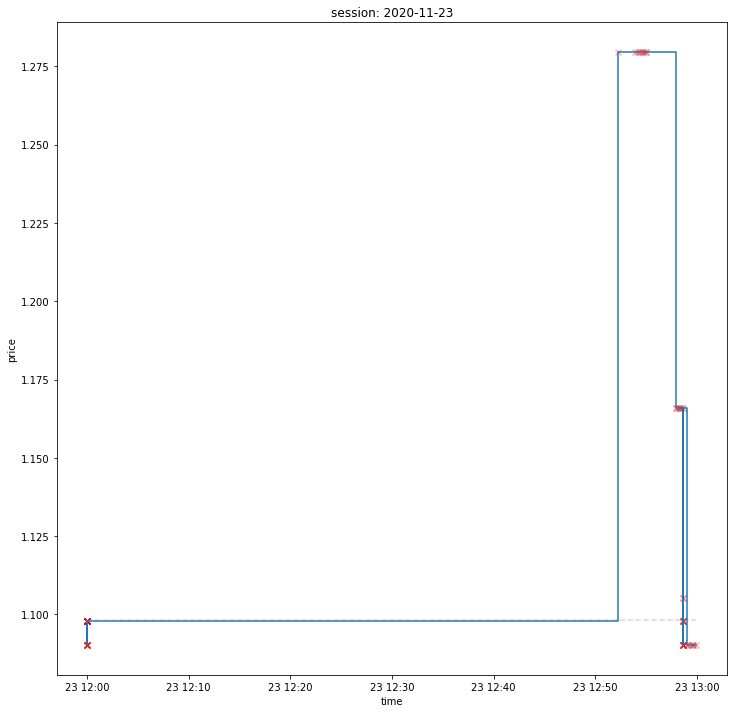

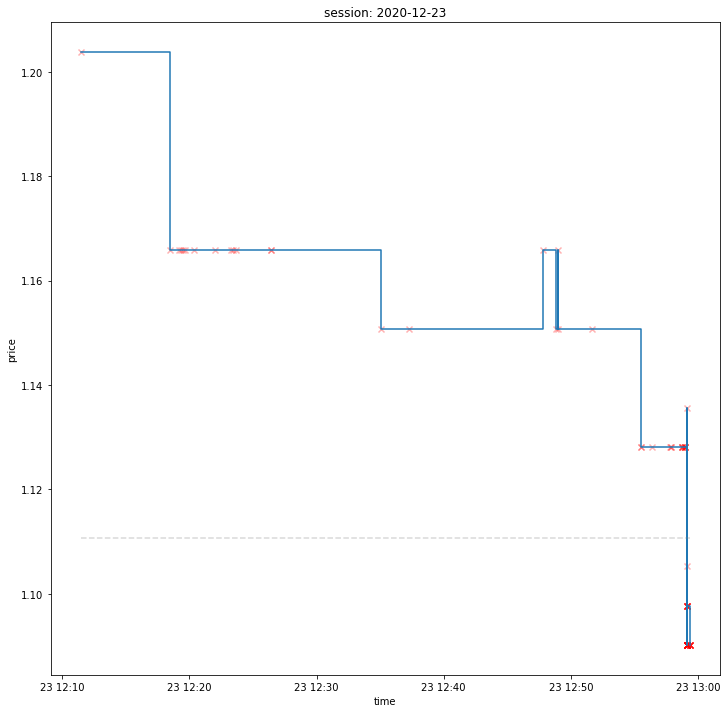

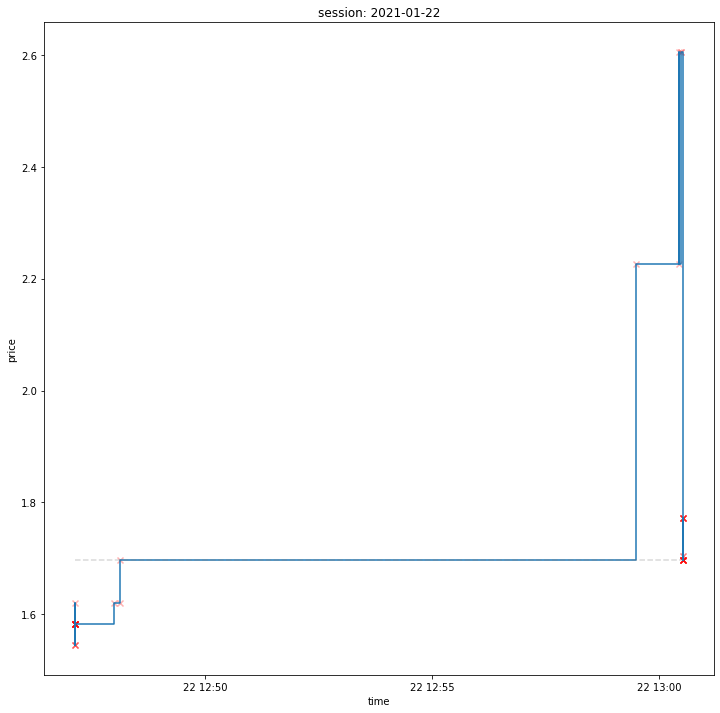

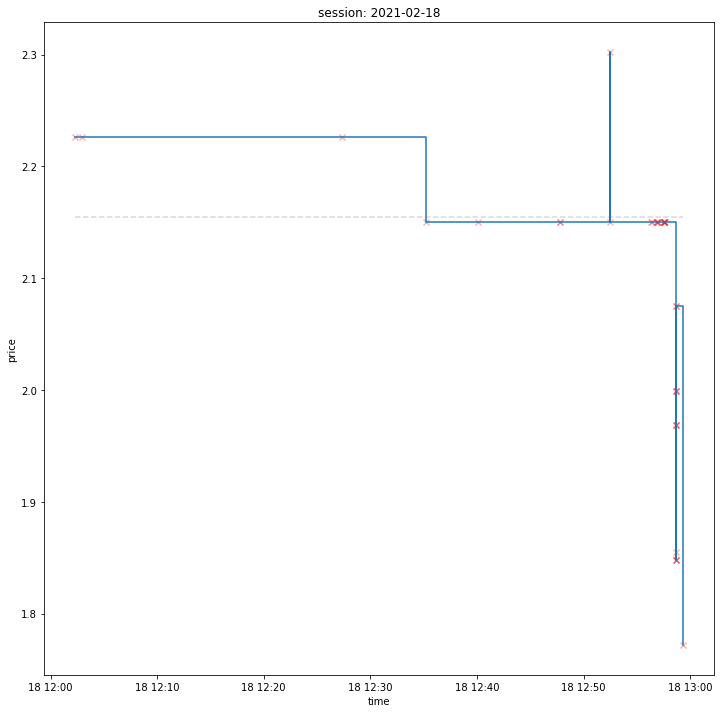

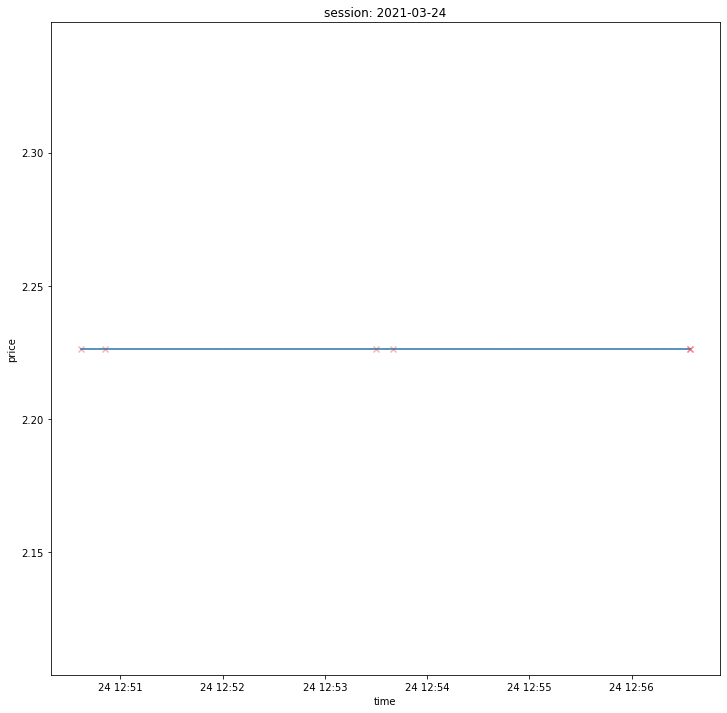

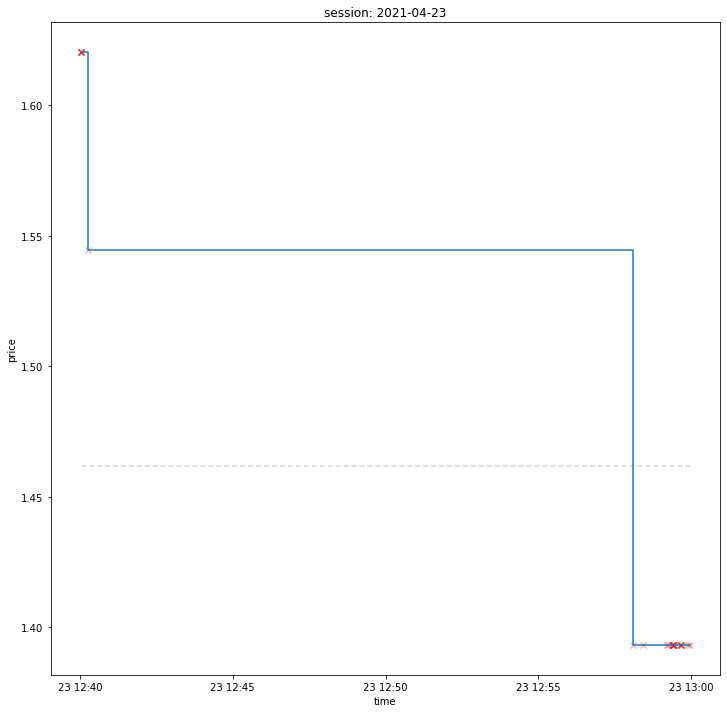

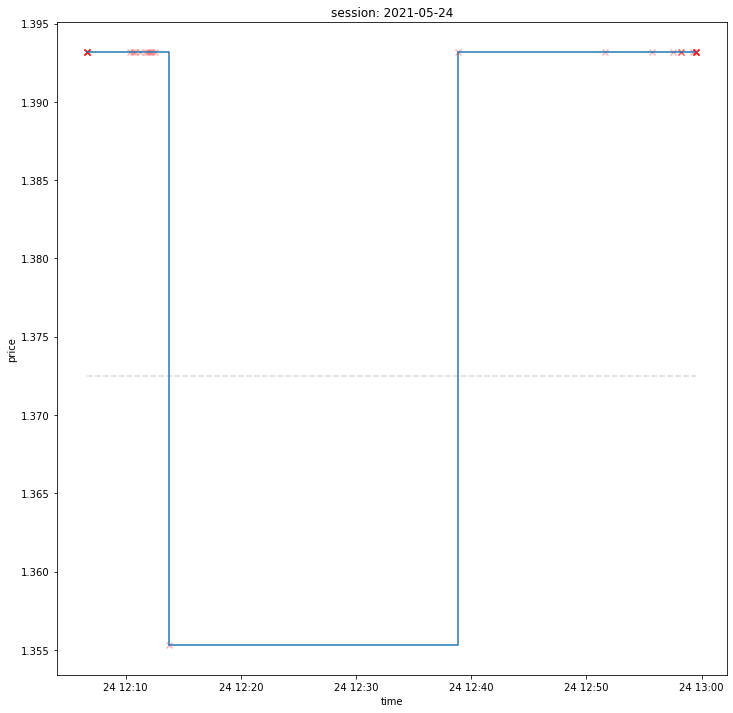

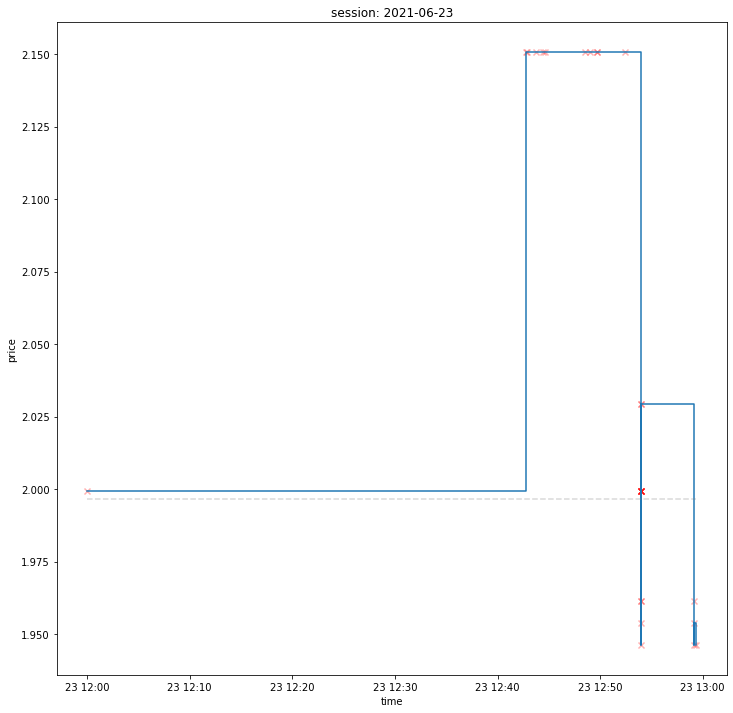

In [722]:
all_session(sess_plat2_month)

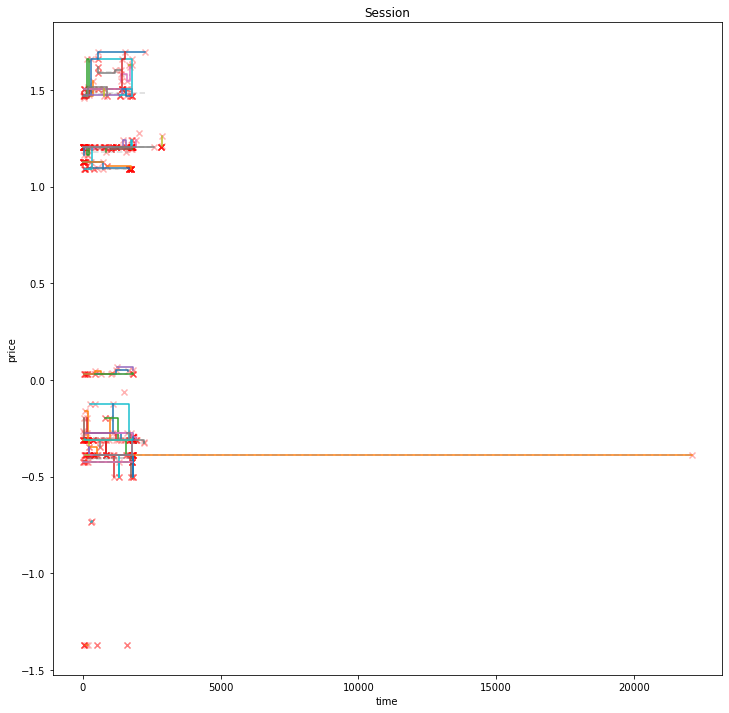

In [714]:
all_session_one_pic(sess_plat1_day)

In [725]:
sess_plat1_day[sess_plat1_day.last_deal == sess_plat1_day.last_deal.max()]

,session_id,timestamp,id,lot_size,deal_id,price,trading_type,platform_id,date,first_deal,last_deal,delta,start,only_time,deal_count,total_size,avg_price,start_price,from_start
21,85,"[2020-02-10T11:03:36.000000000, 2020-02-10T11:...","[2147, 2148, 2149, 2150, 2170]","[1, 2, 340, 150, 70]","[1516, 1517, 1518, 1519, 1529]","[-0.3491283523415229, -0.3870045831659984, -0....",daily,1.0,2020-02-10,11:03:36,17:08:18,0 days 06:04:42,2020-02-10 11:00:00,"[11:03:36, 11:08:17, 11:13:57, 11:29:35, 17:08...",5,563,-0.386937,-0.388574,"[216, 497, 837, 1775, 22098]"


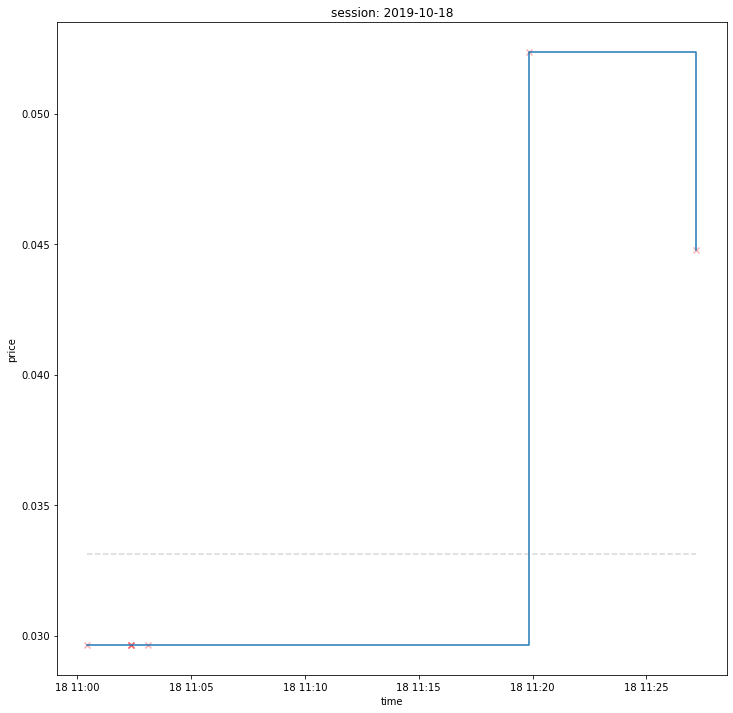

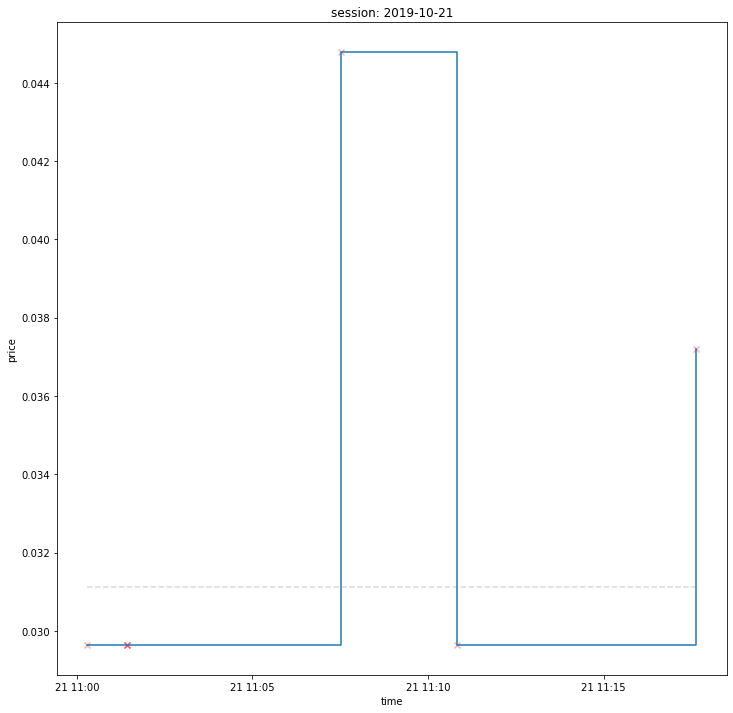

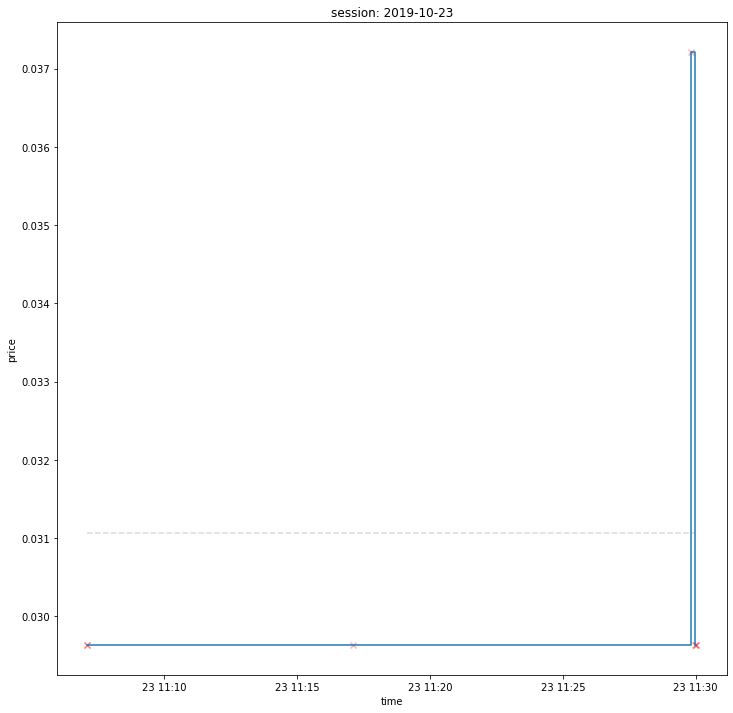

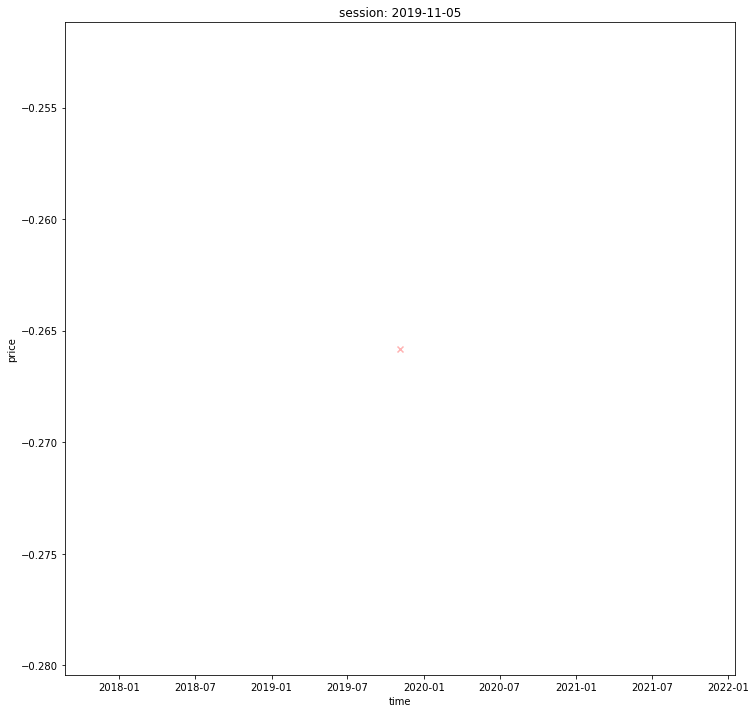

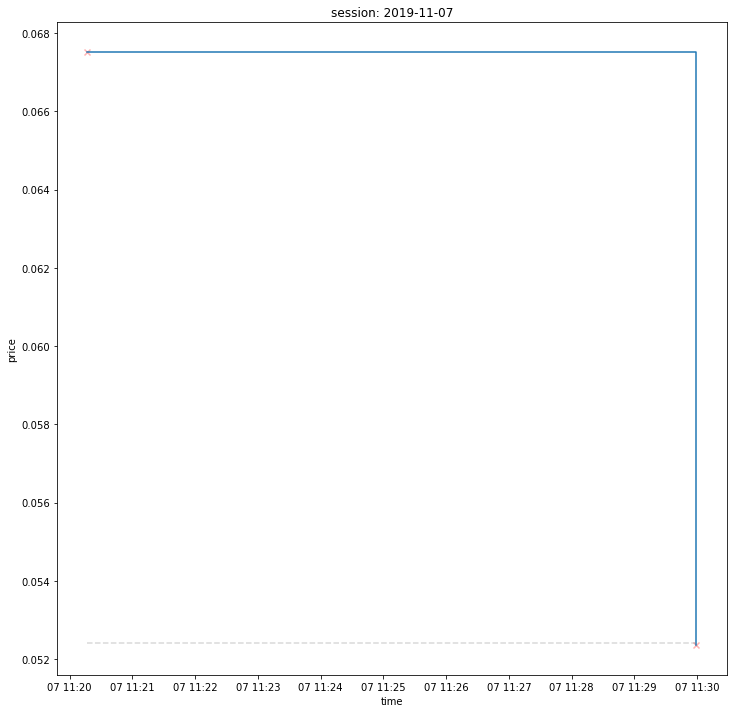

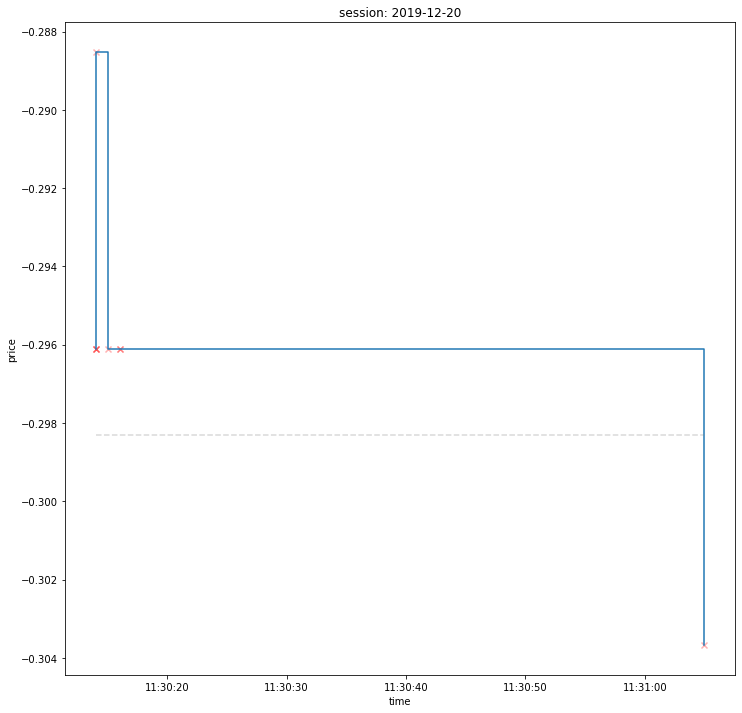

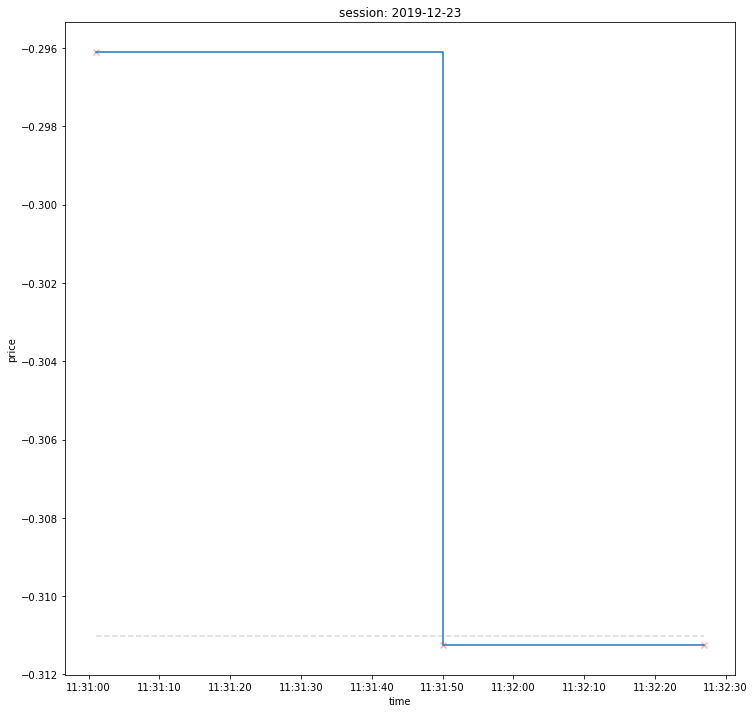

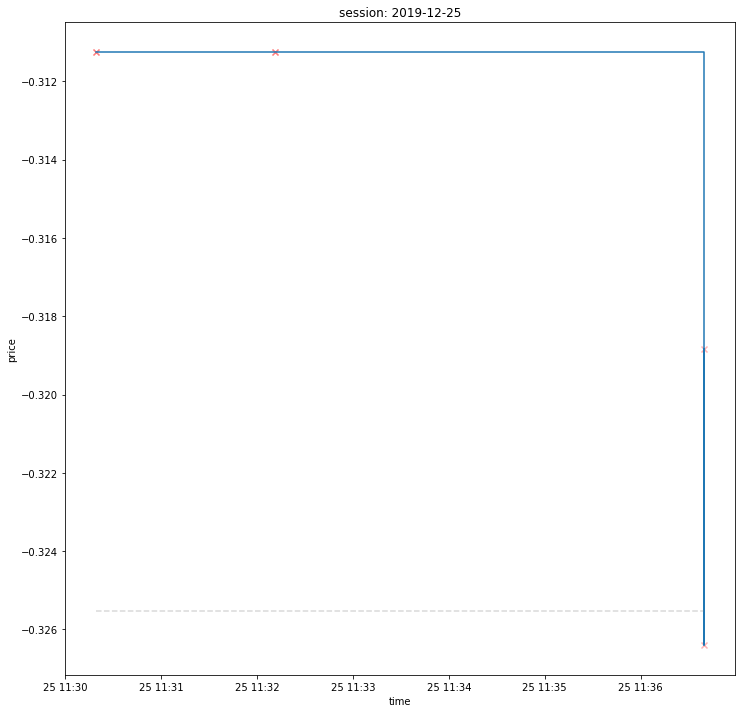

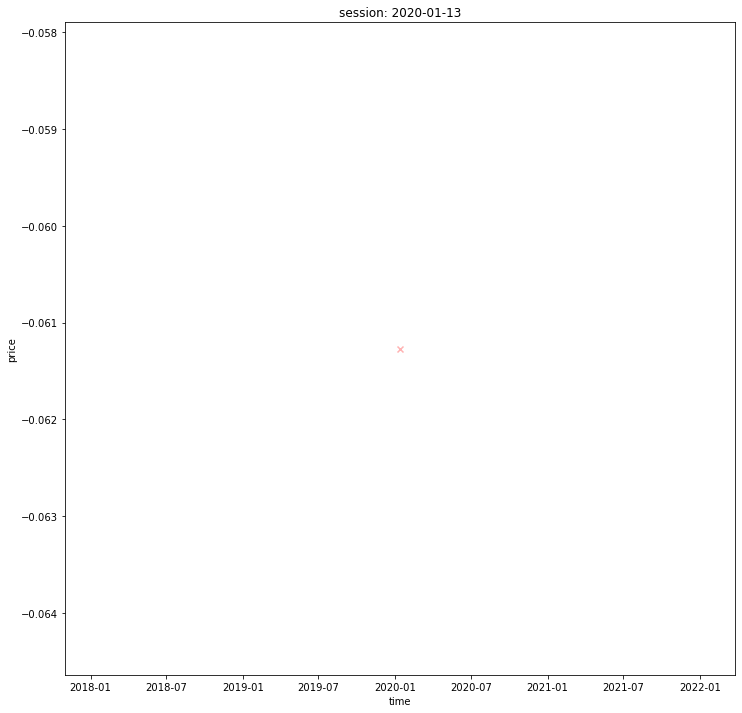

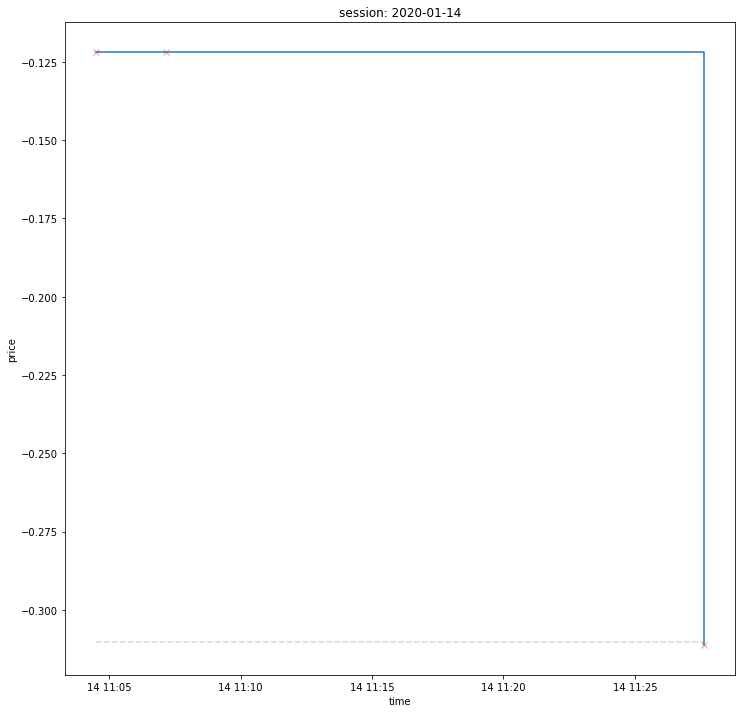

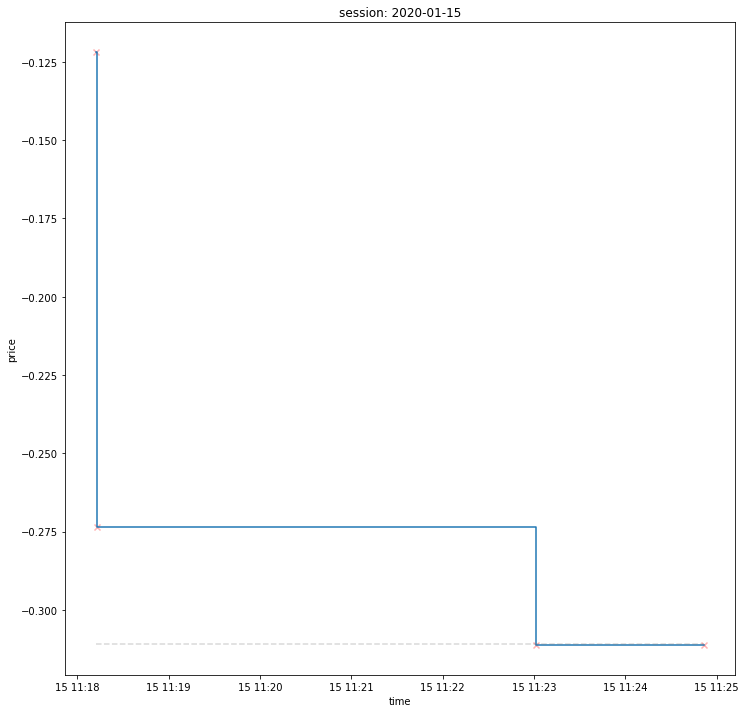

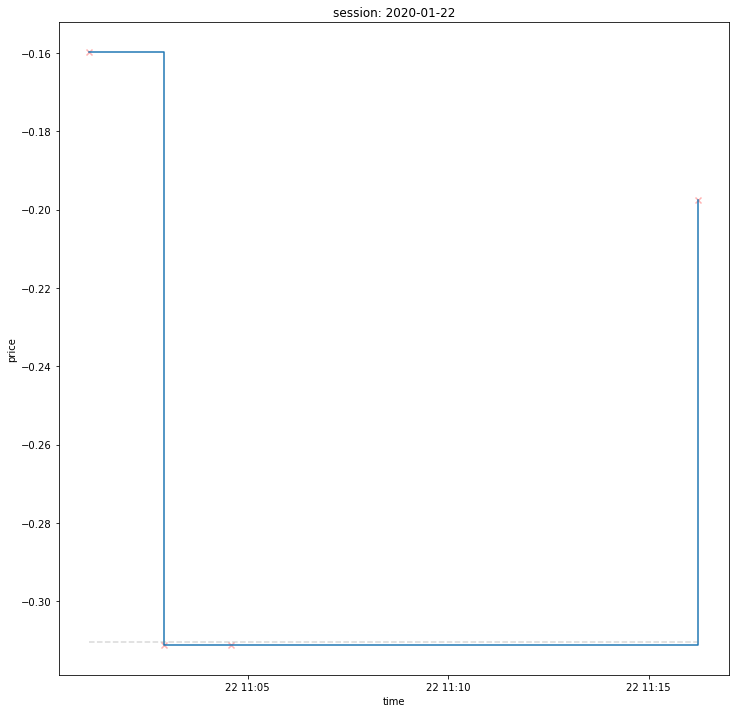

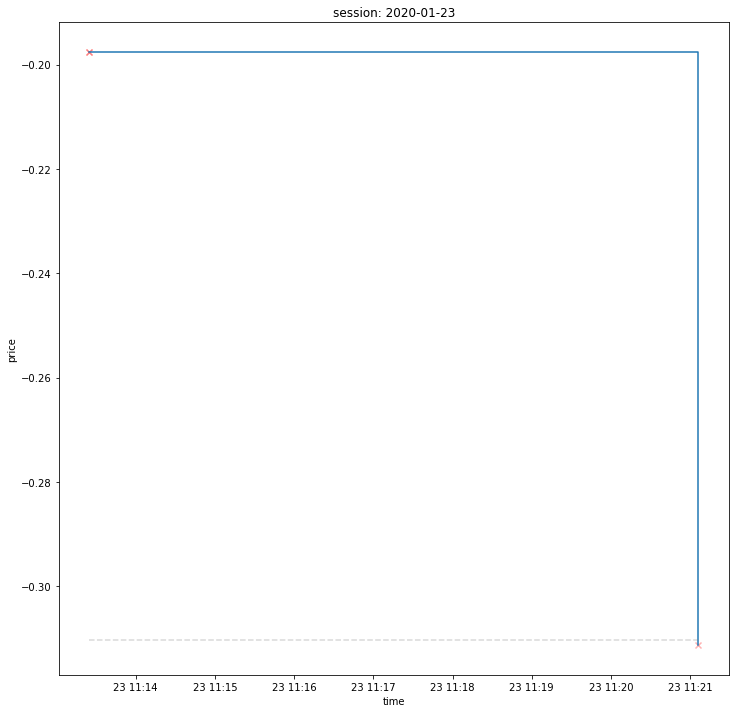

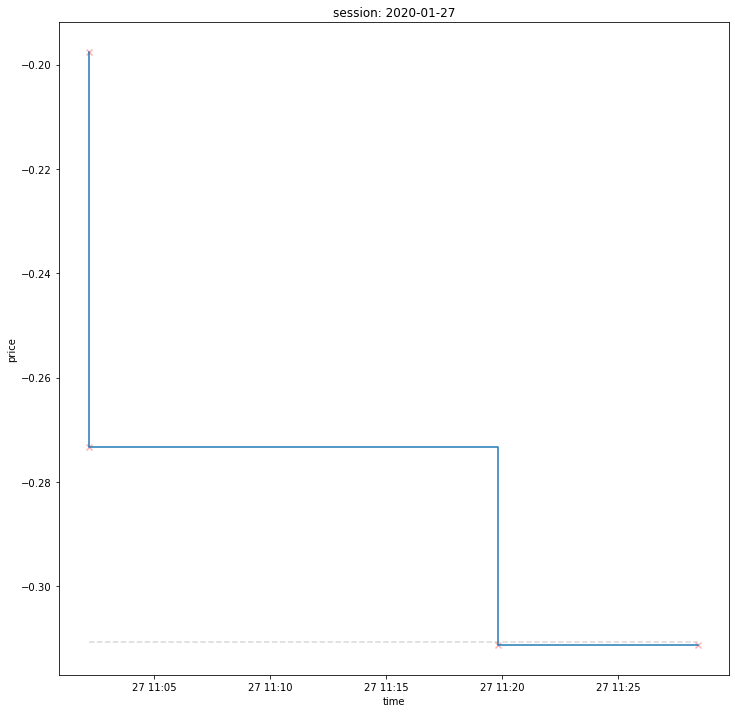

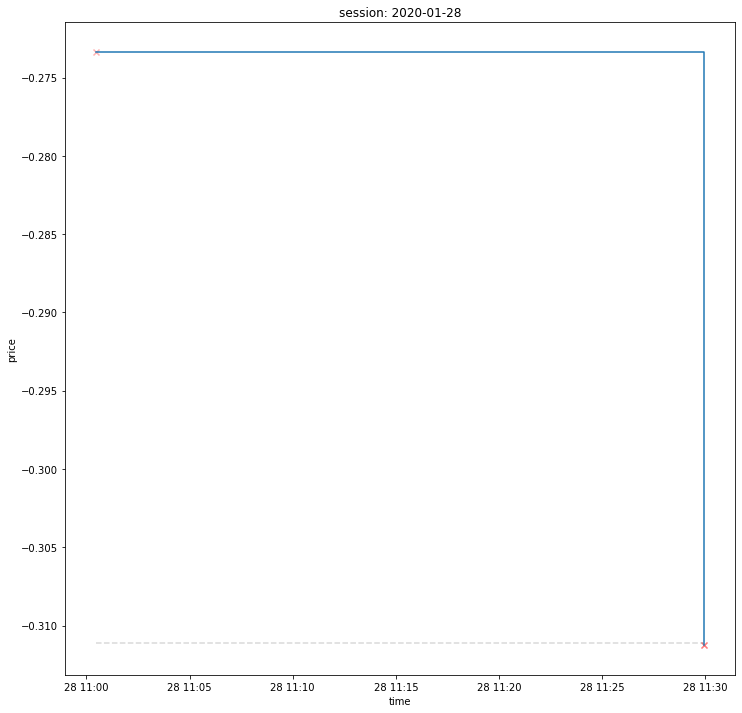

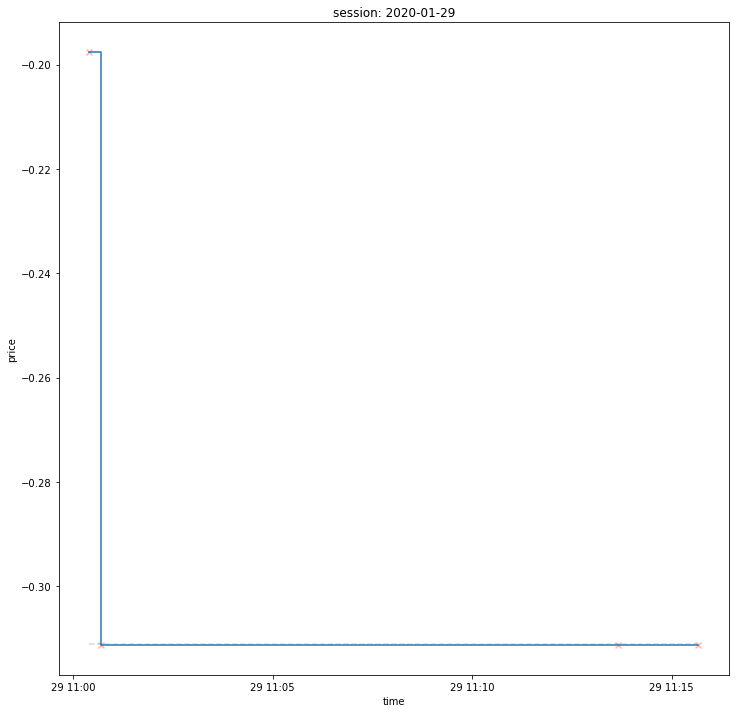

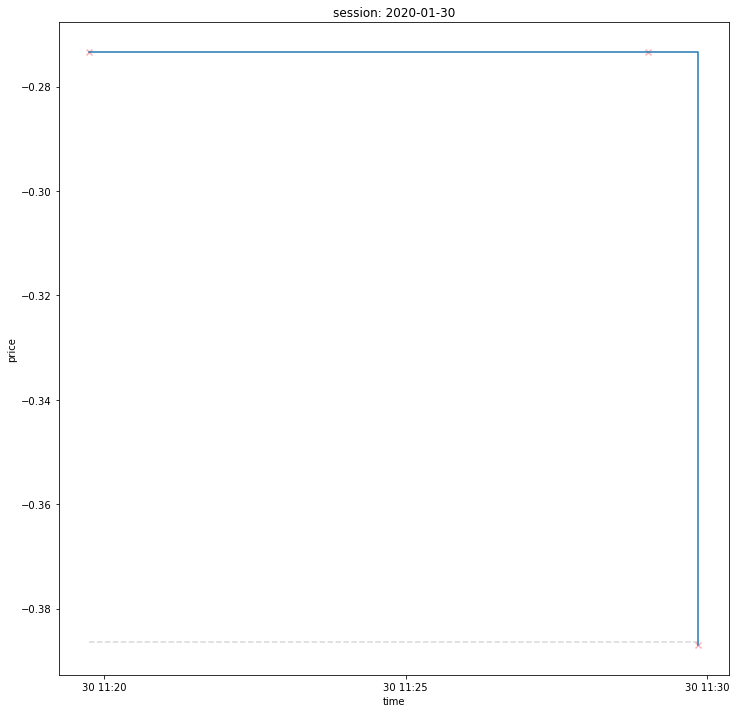

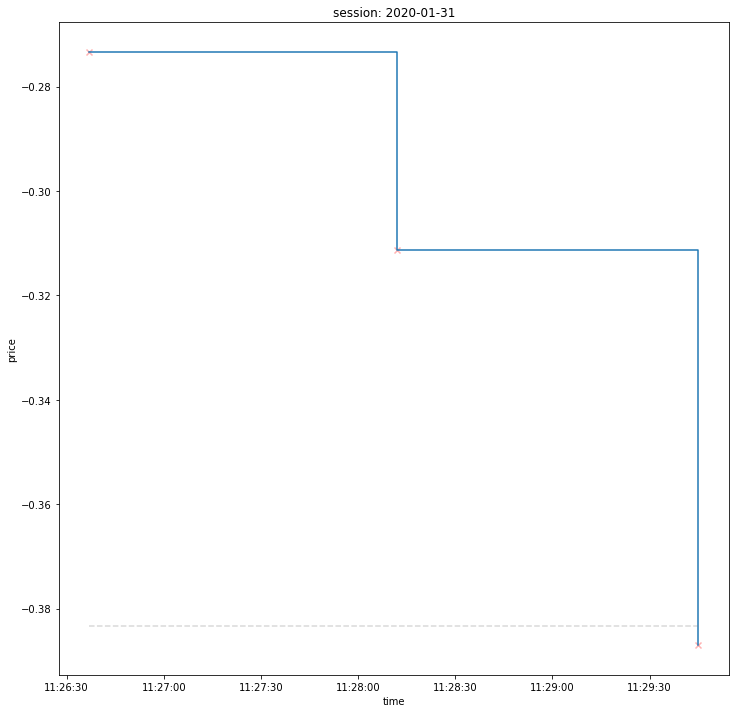

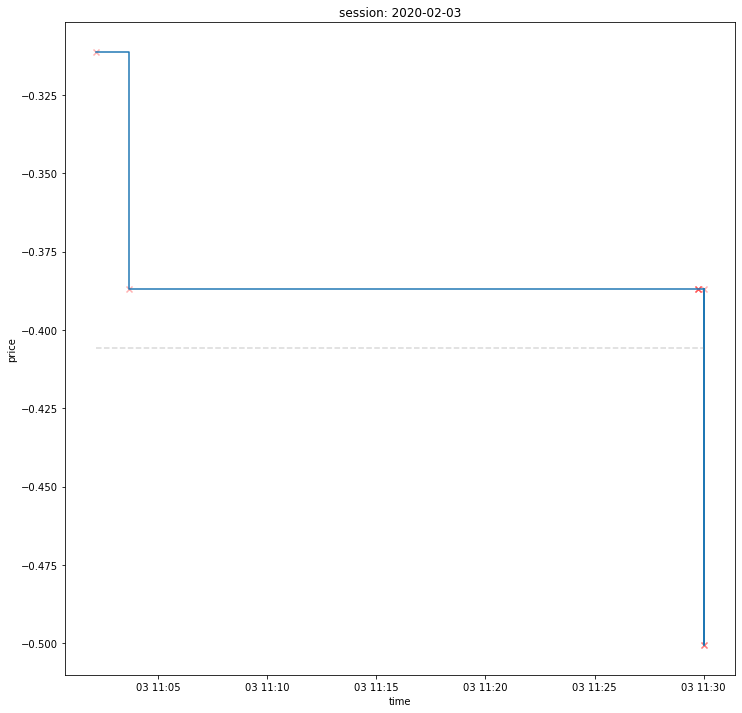

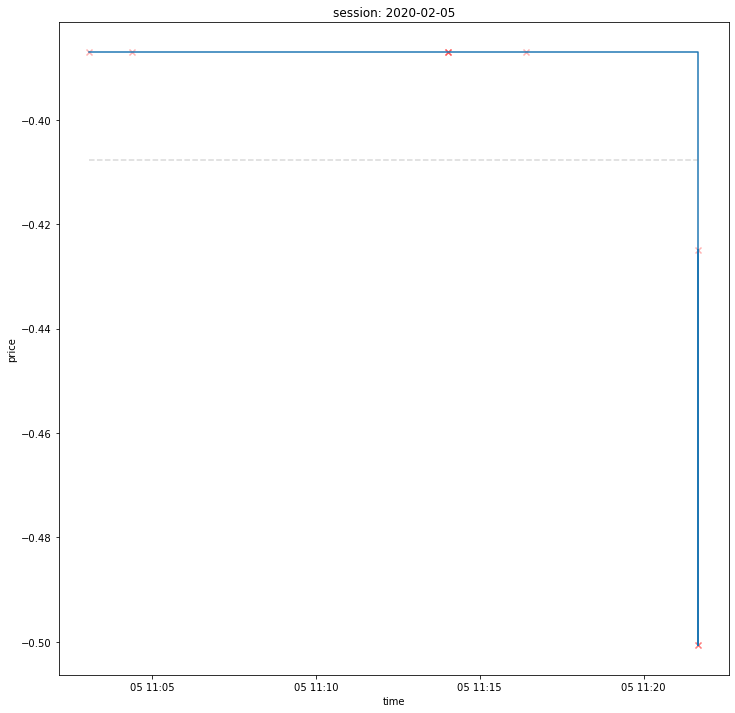

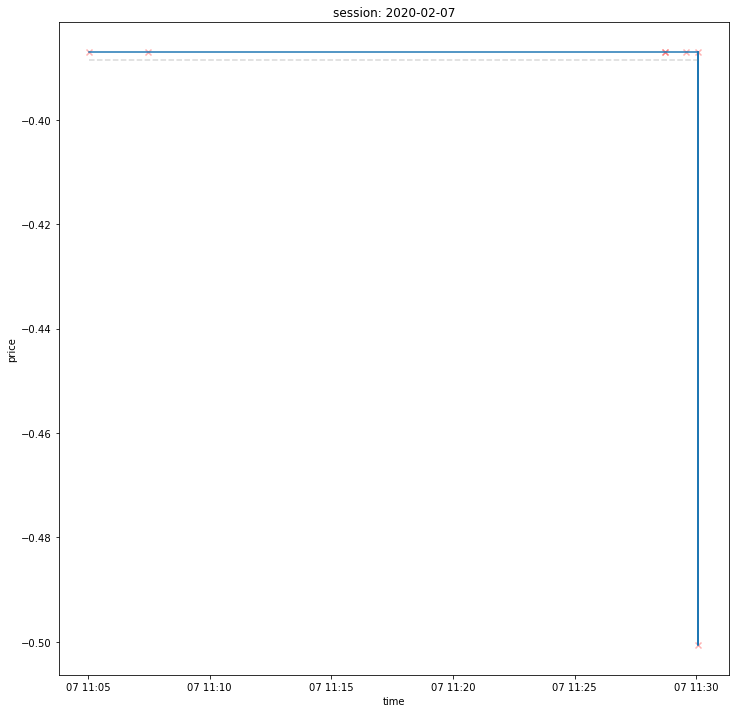

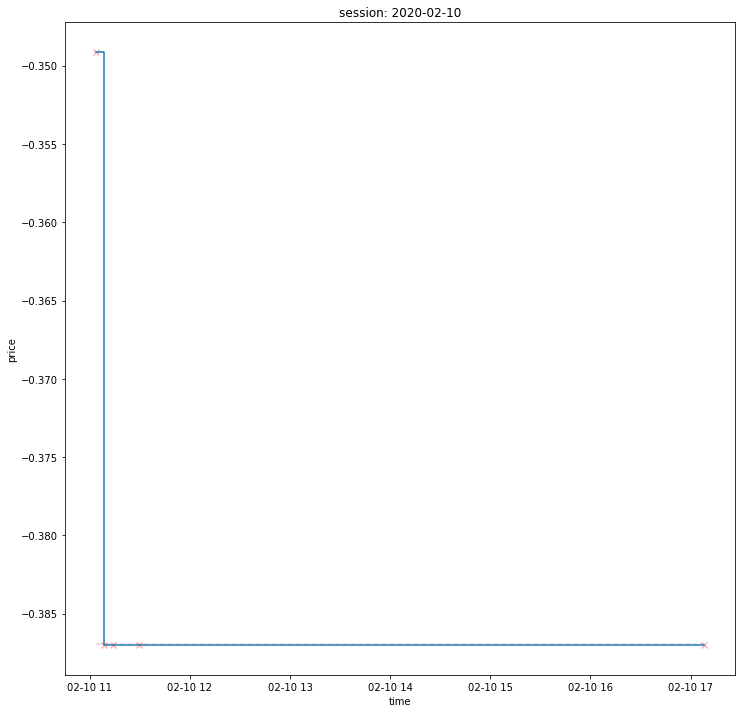

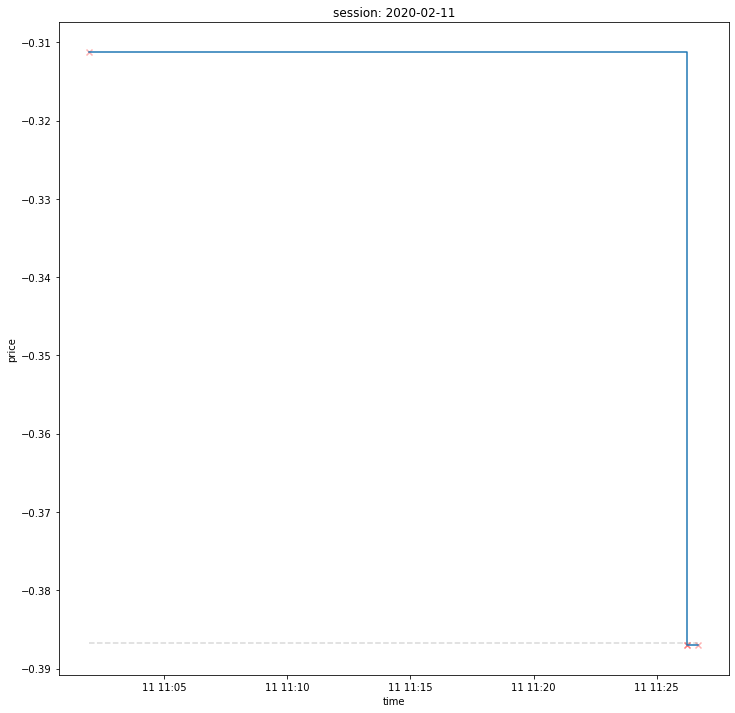

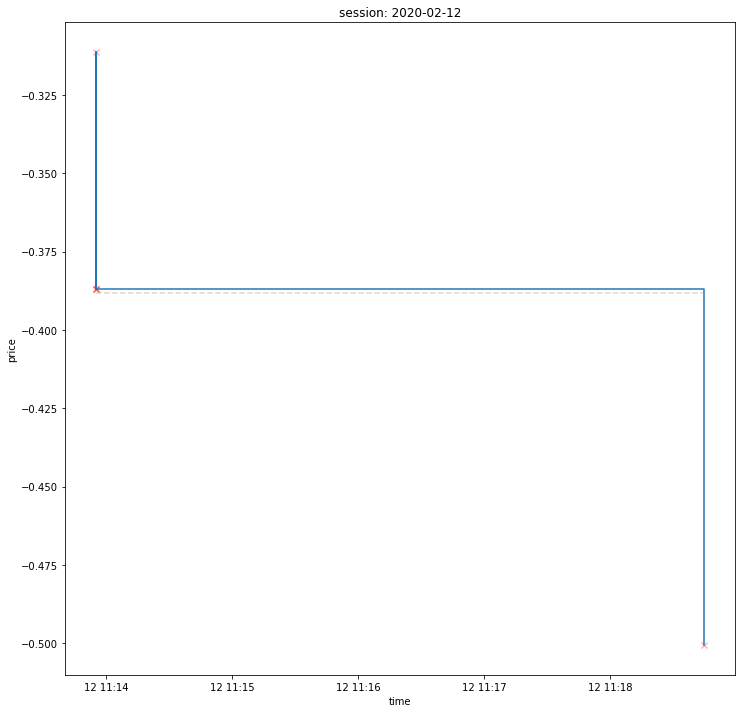

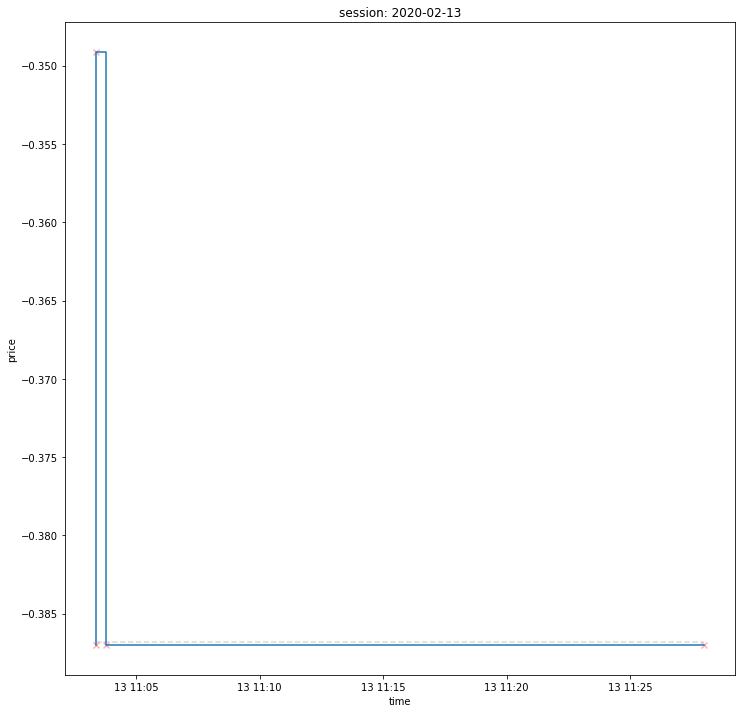

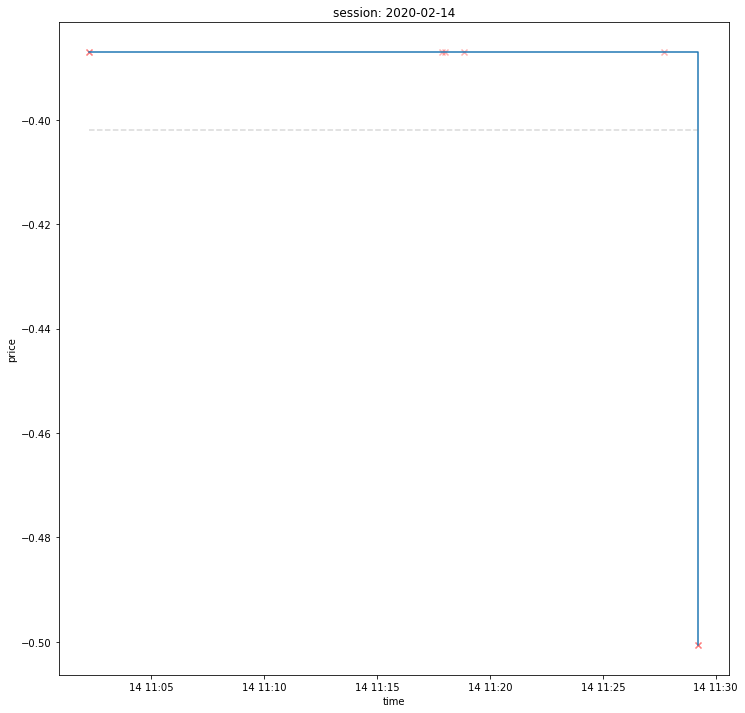

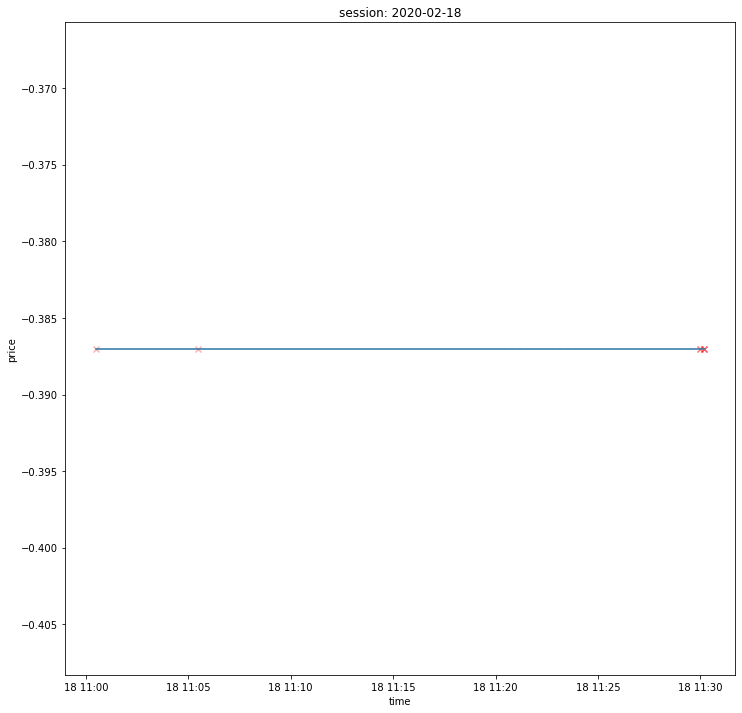

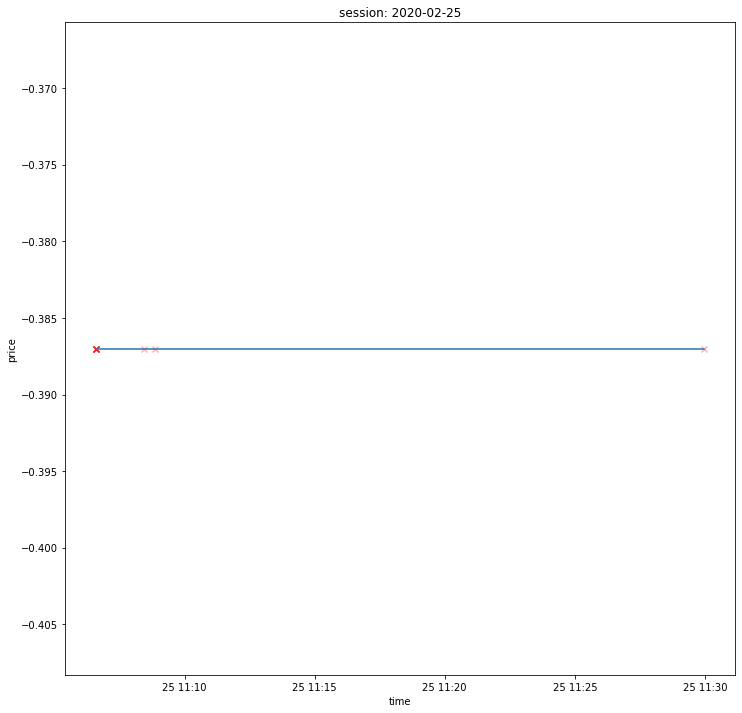

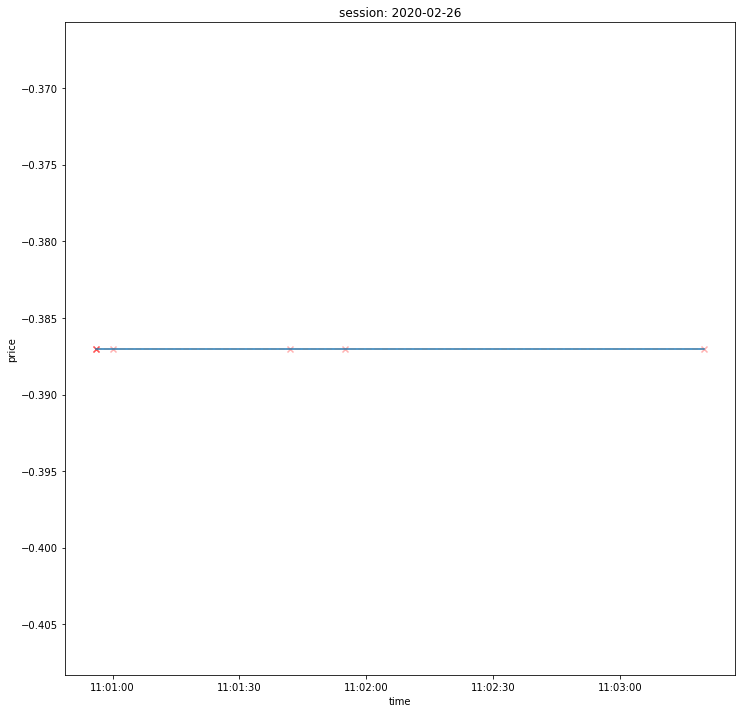

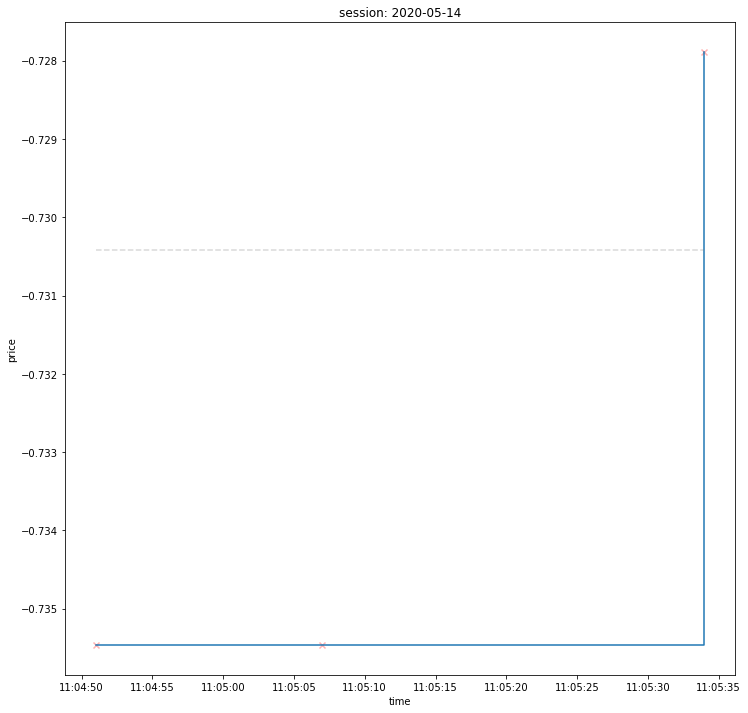

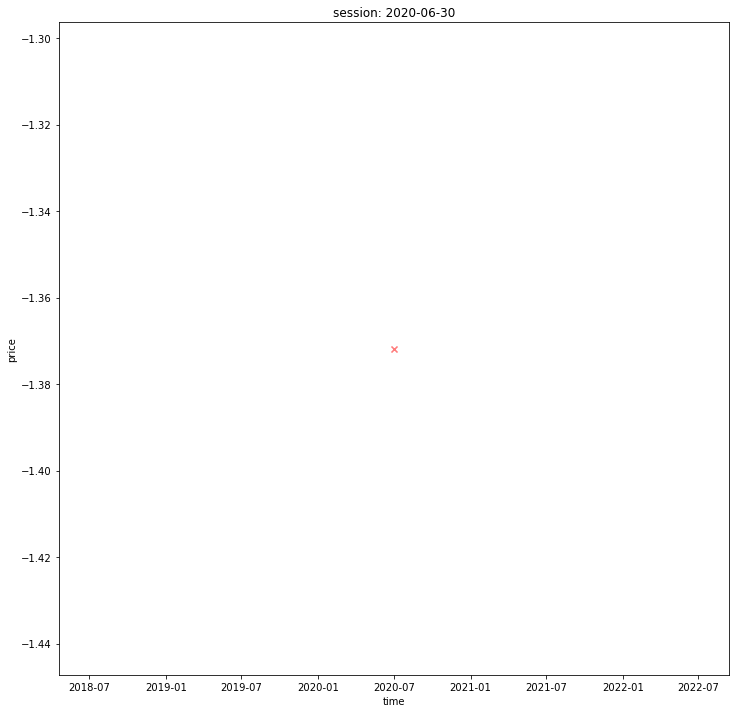

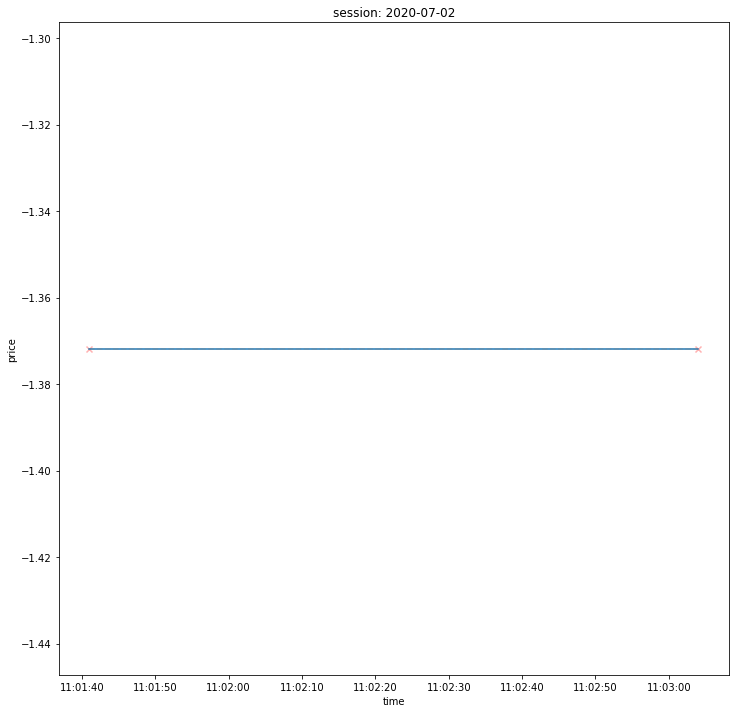

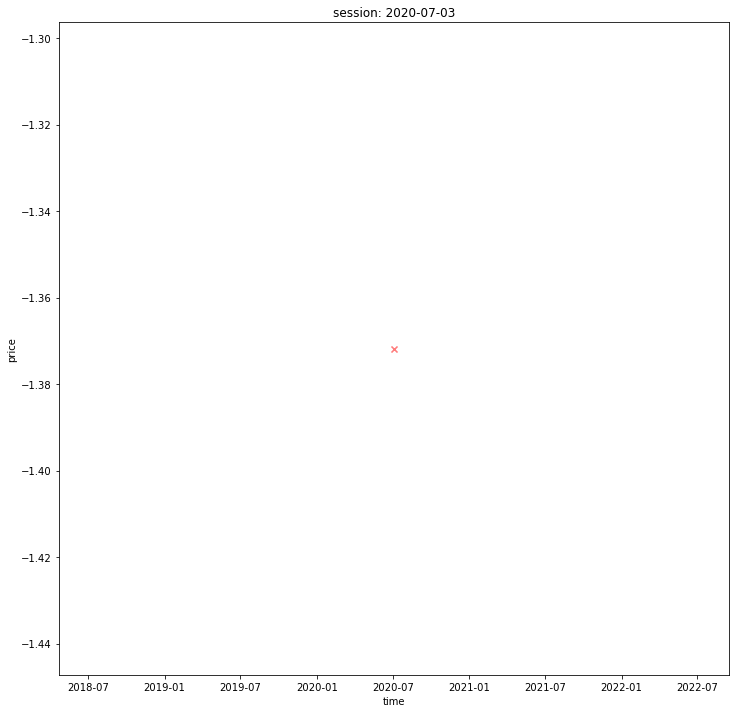

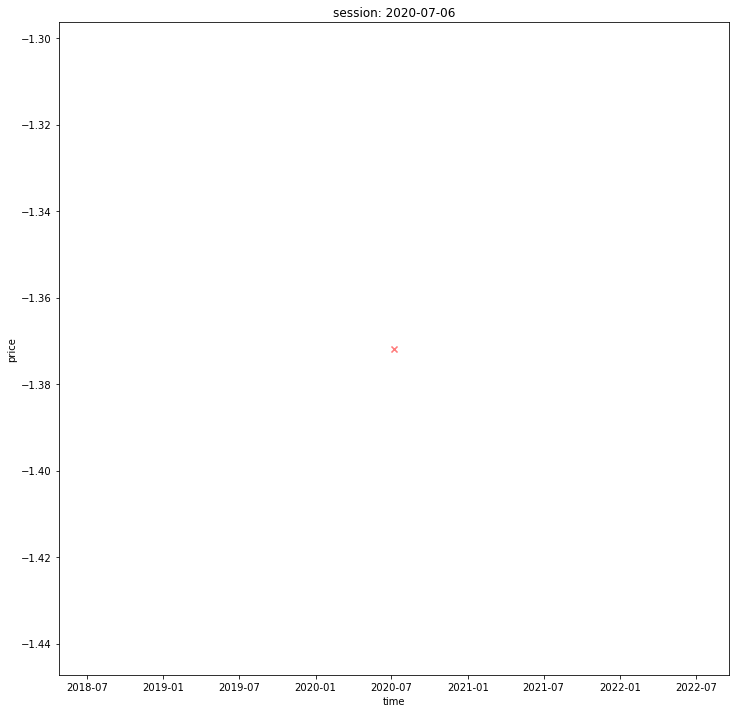

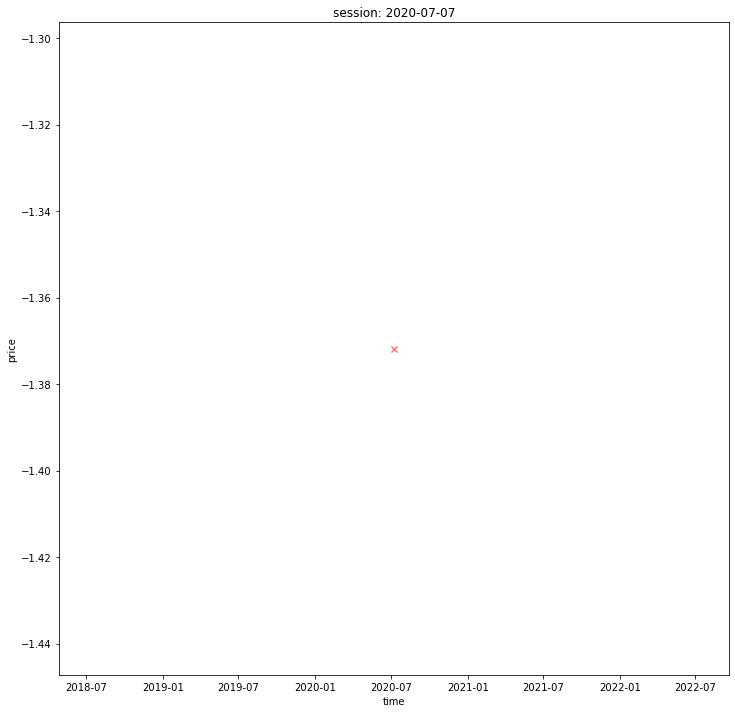

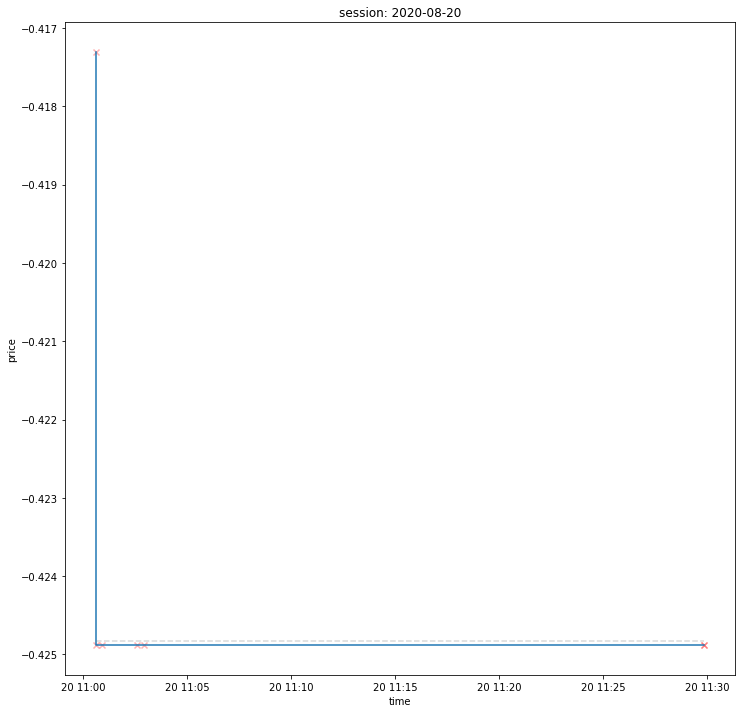

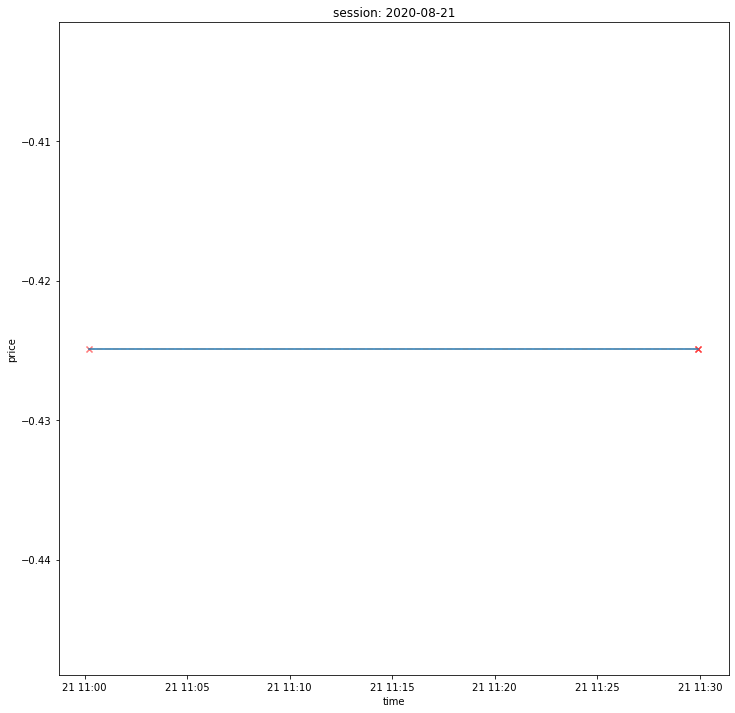

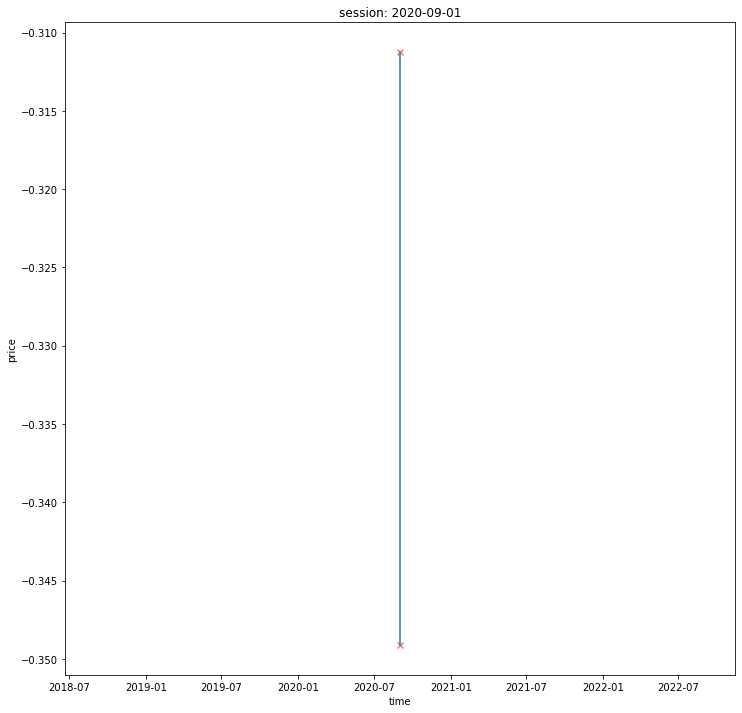

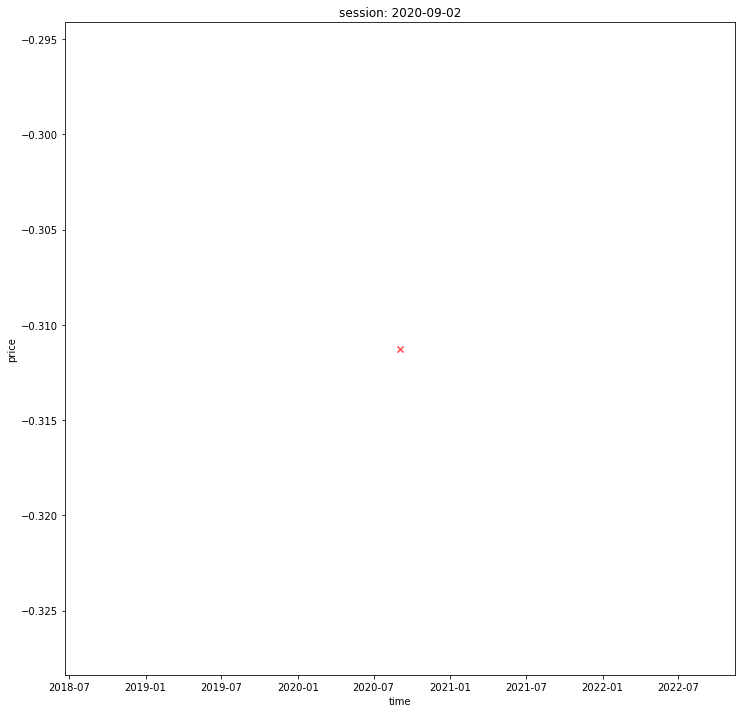

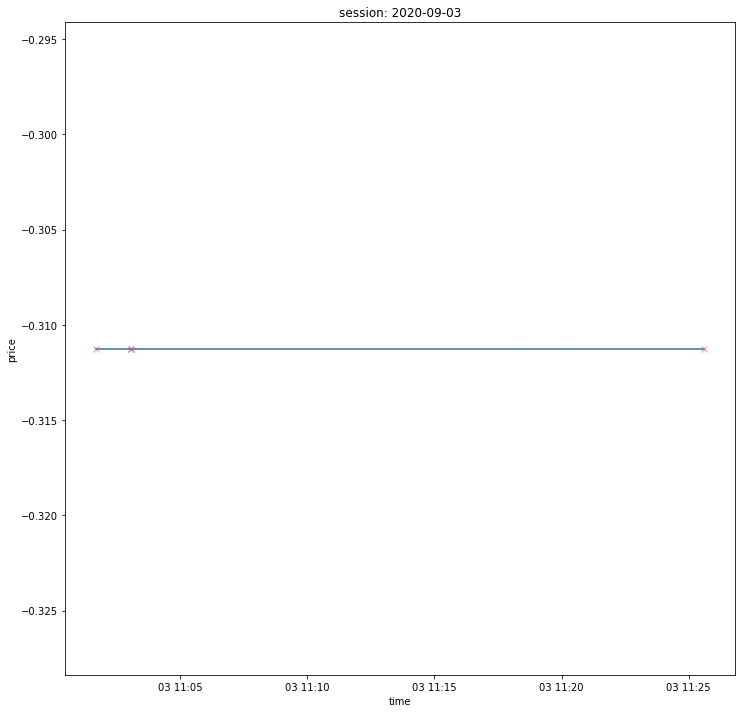

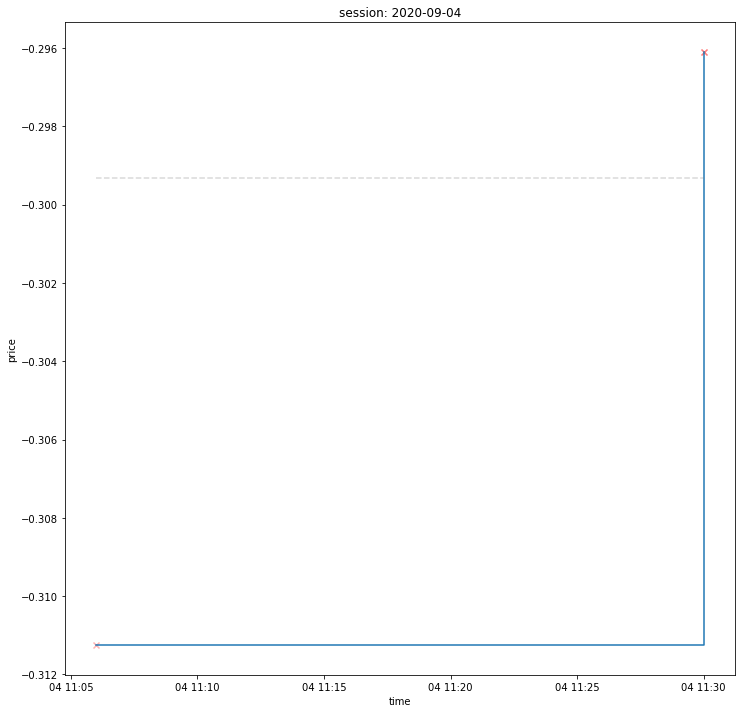

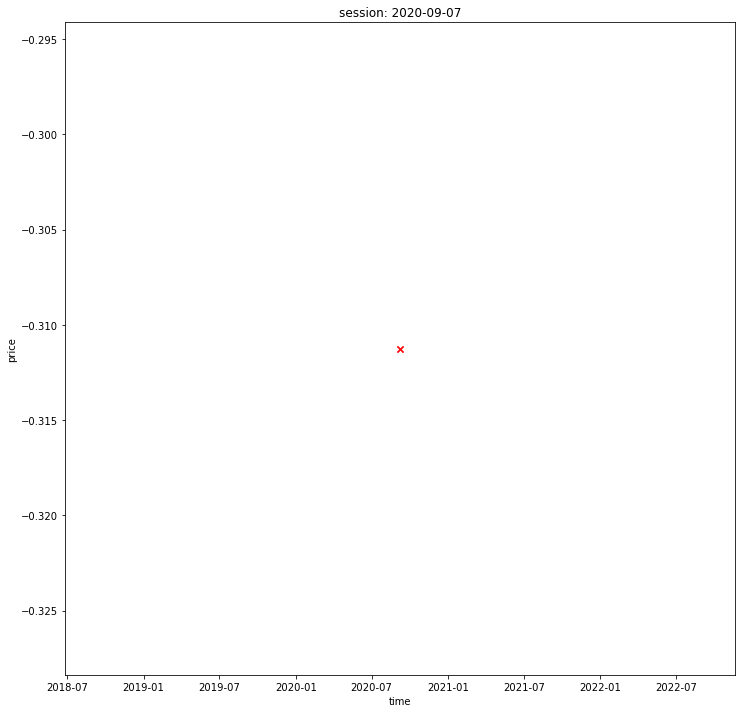

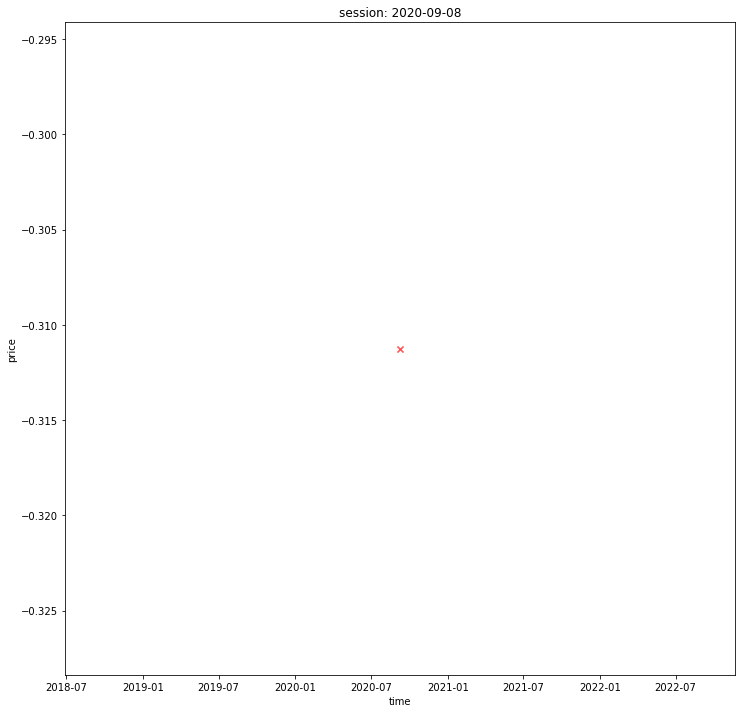

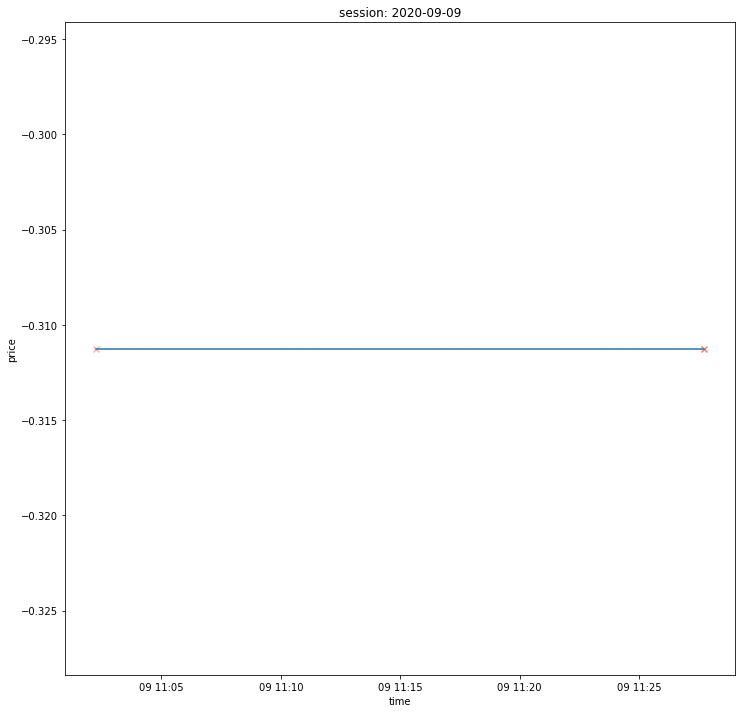

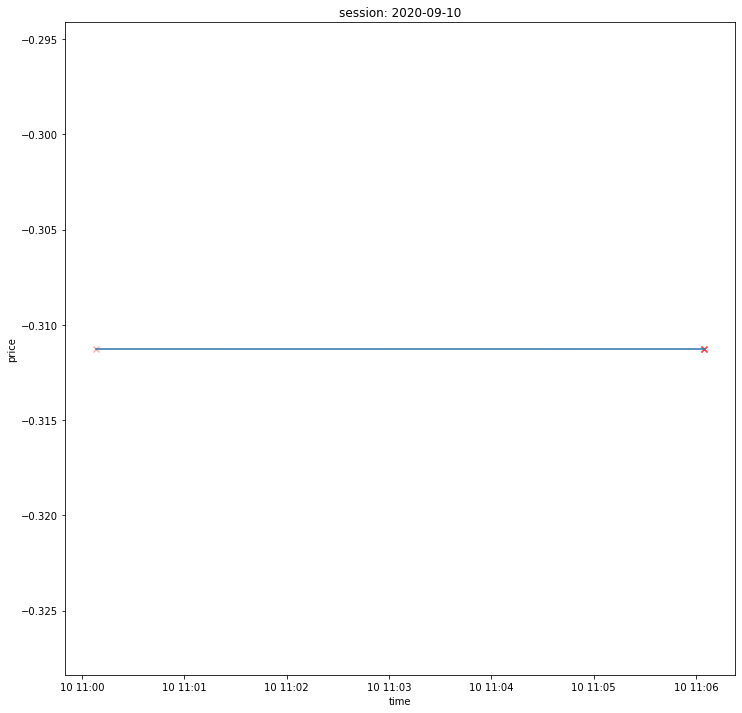

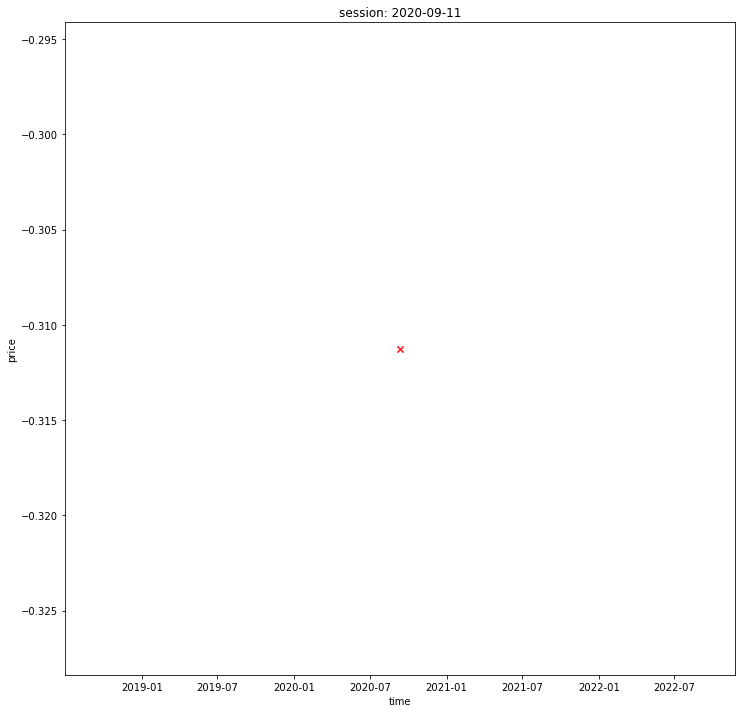

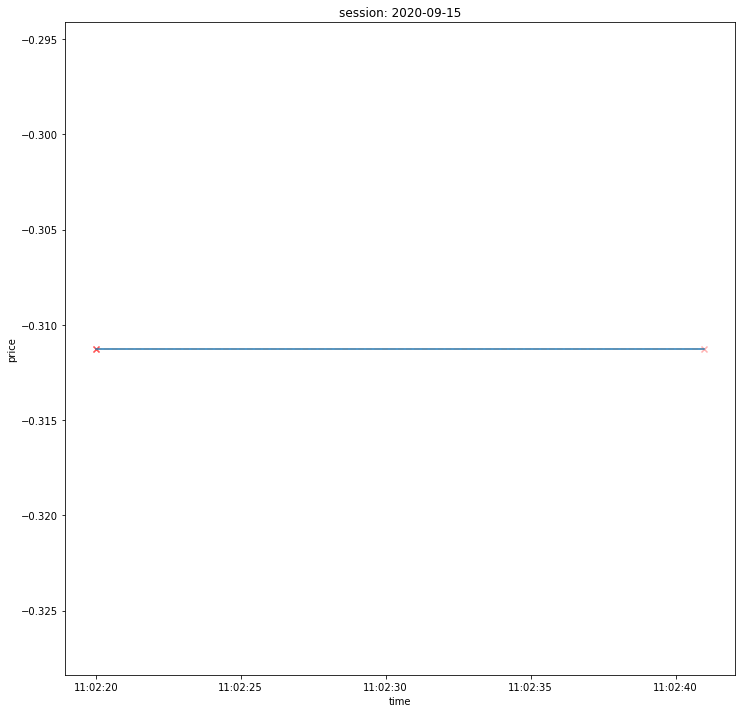

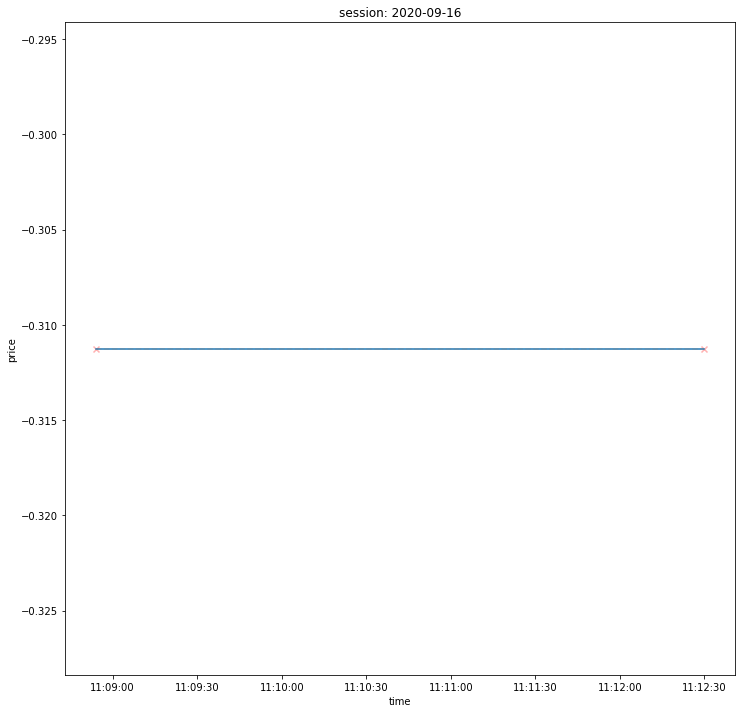

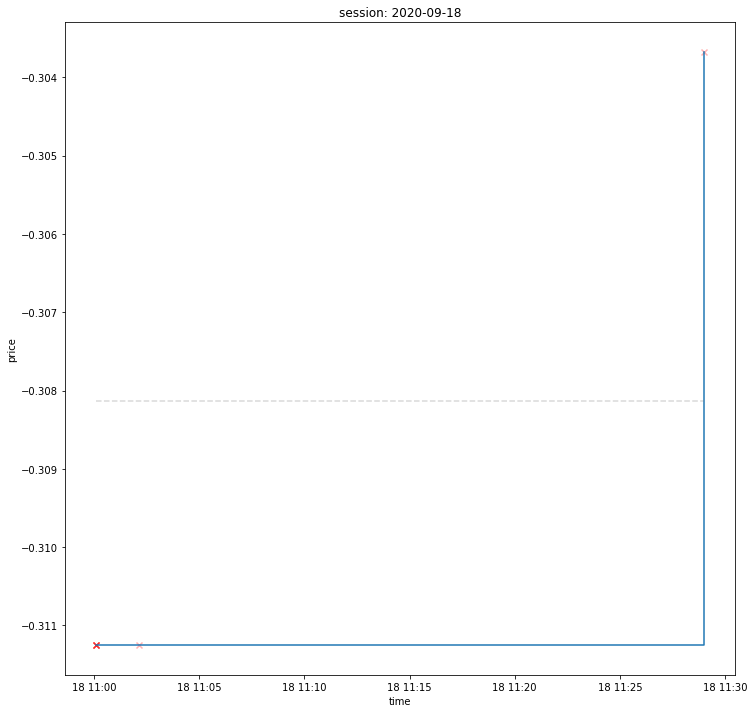

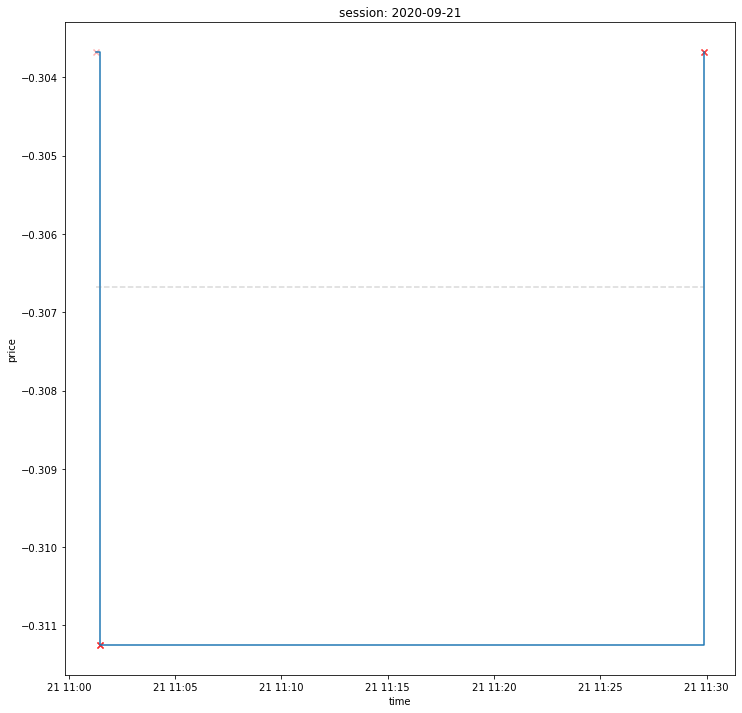

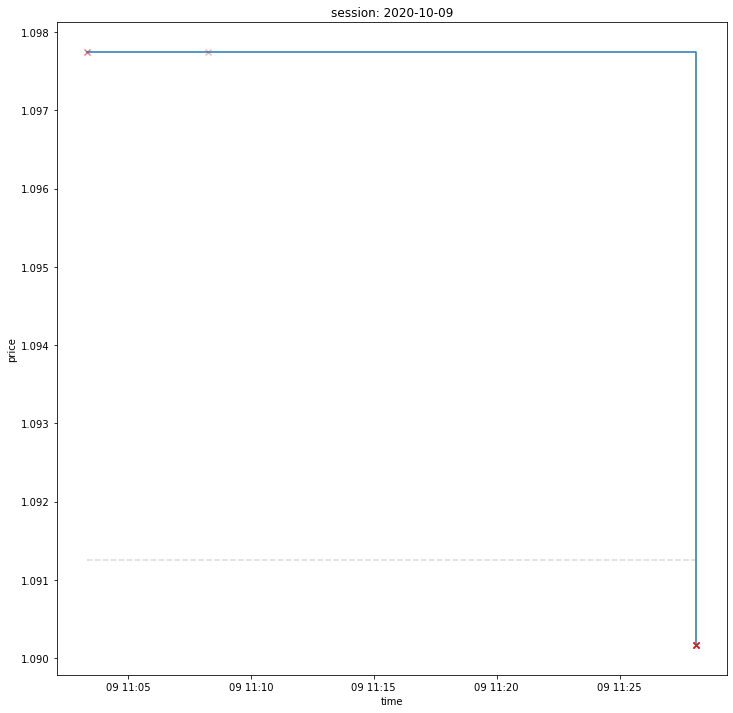

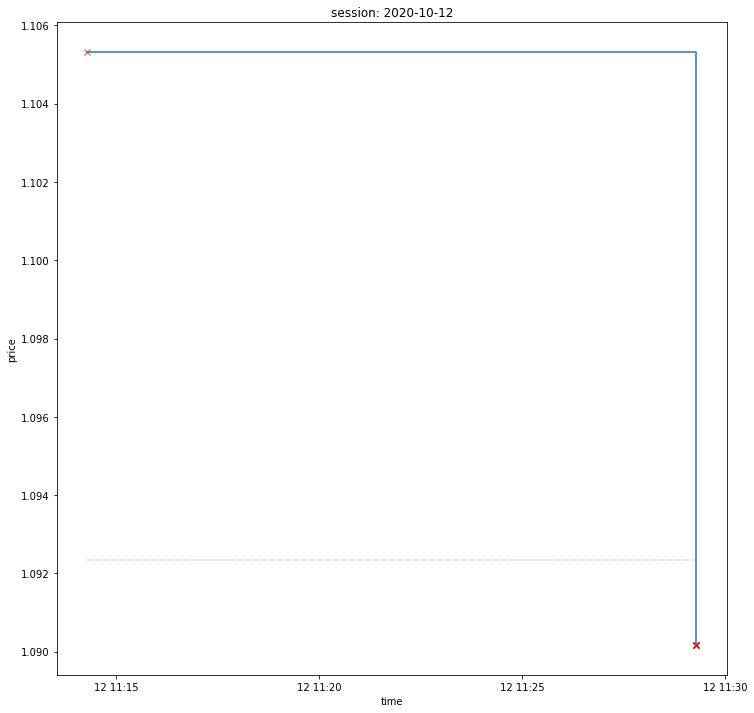

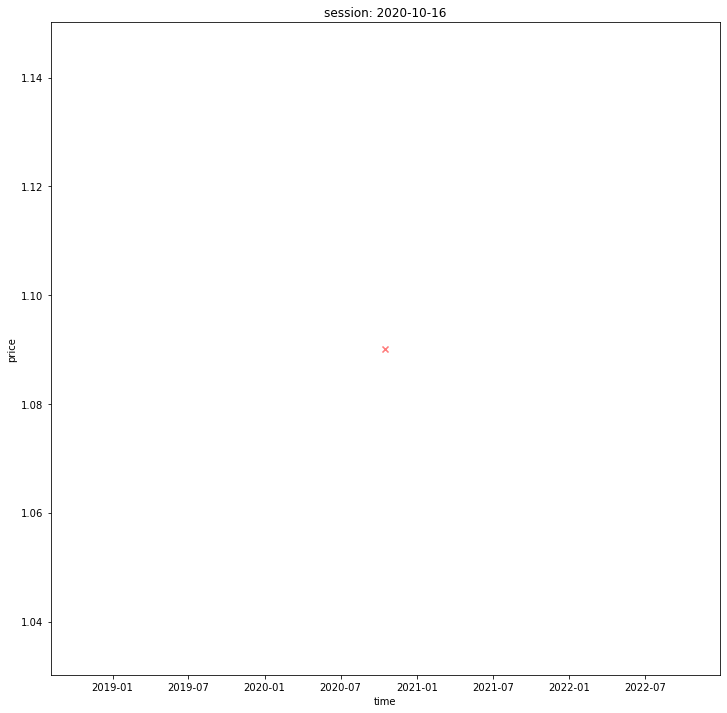

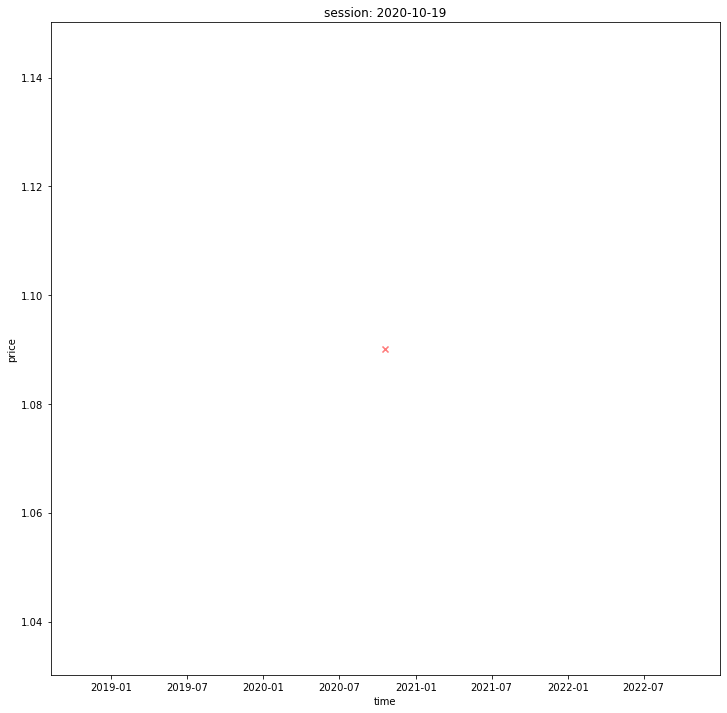

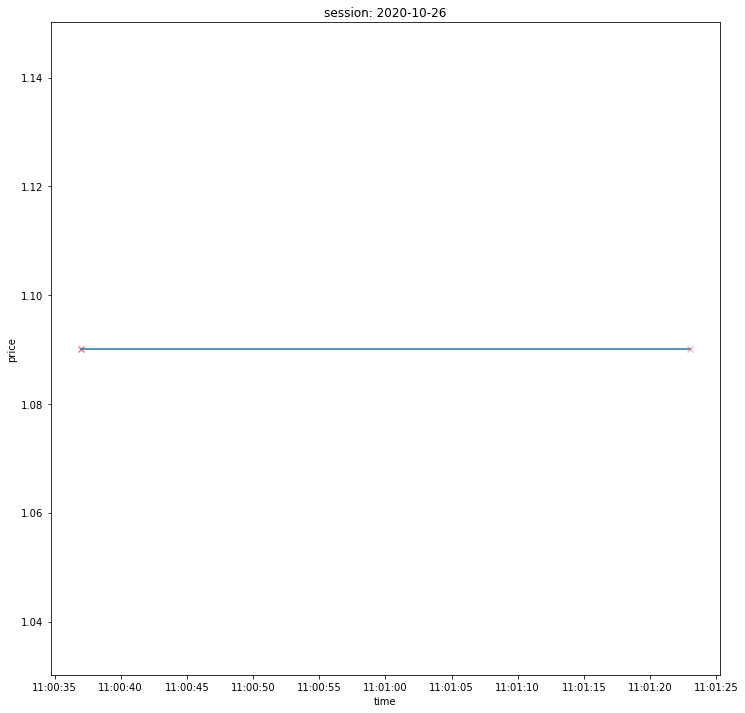

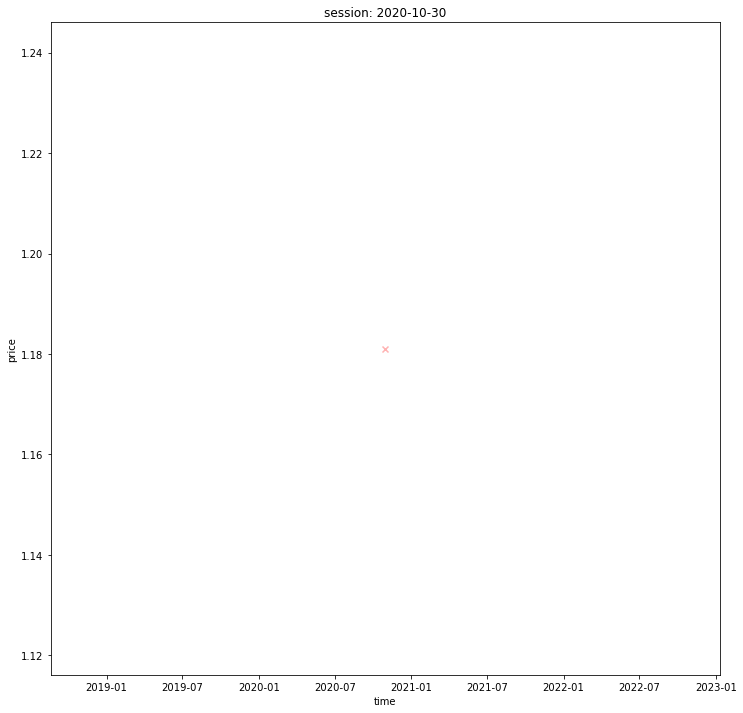

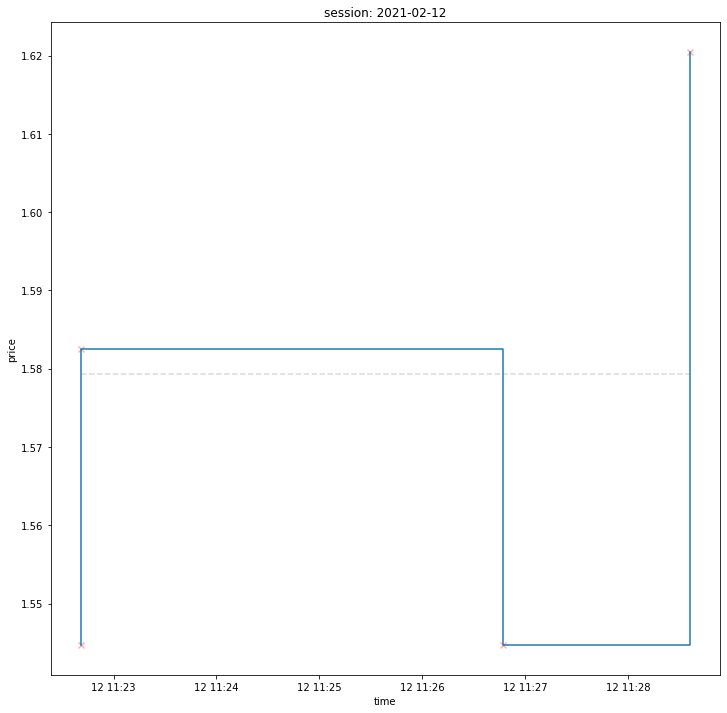

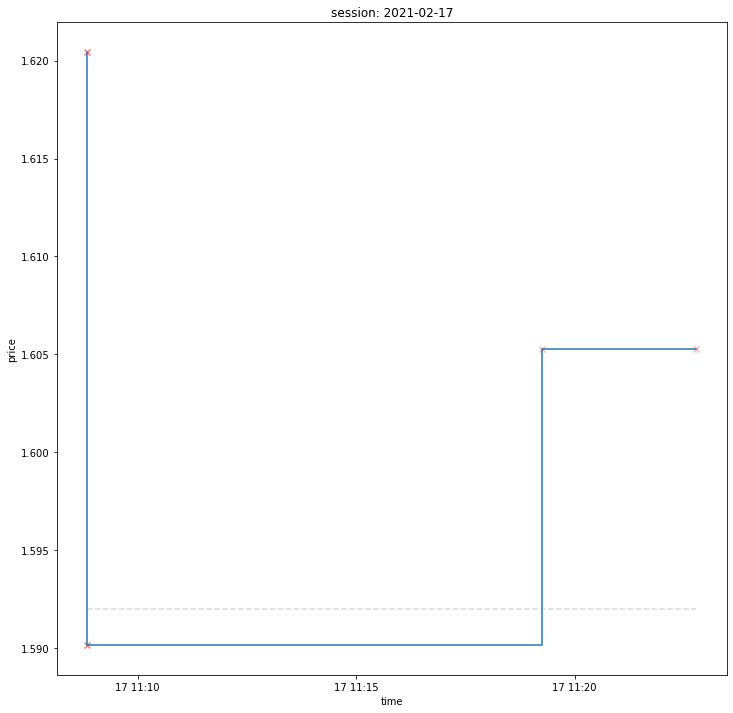

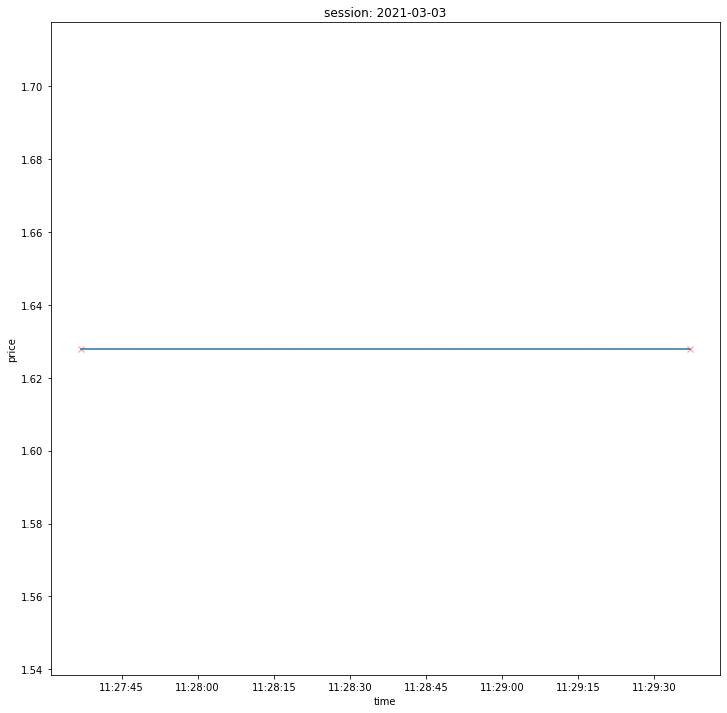

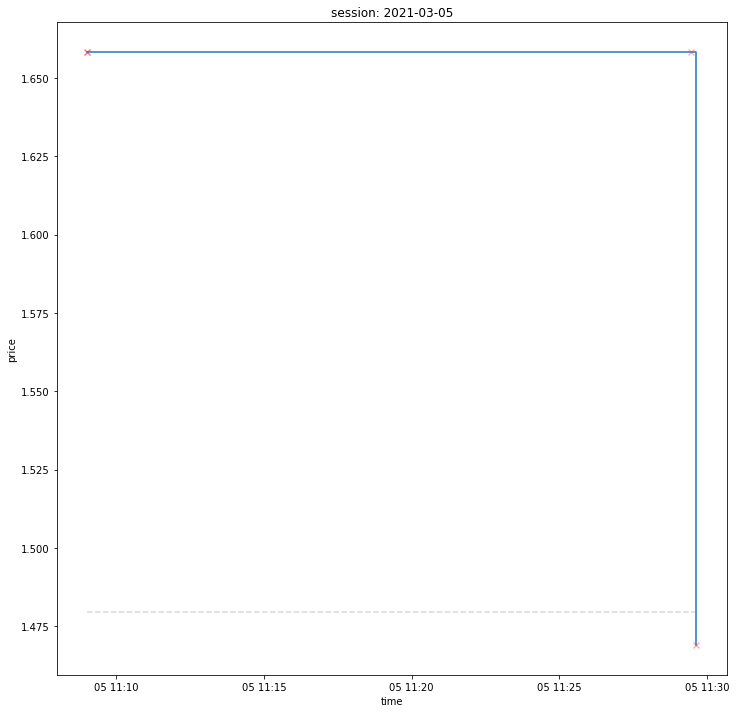

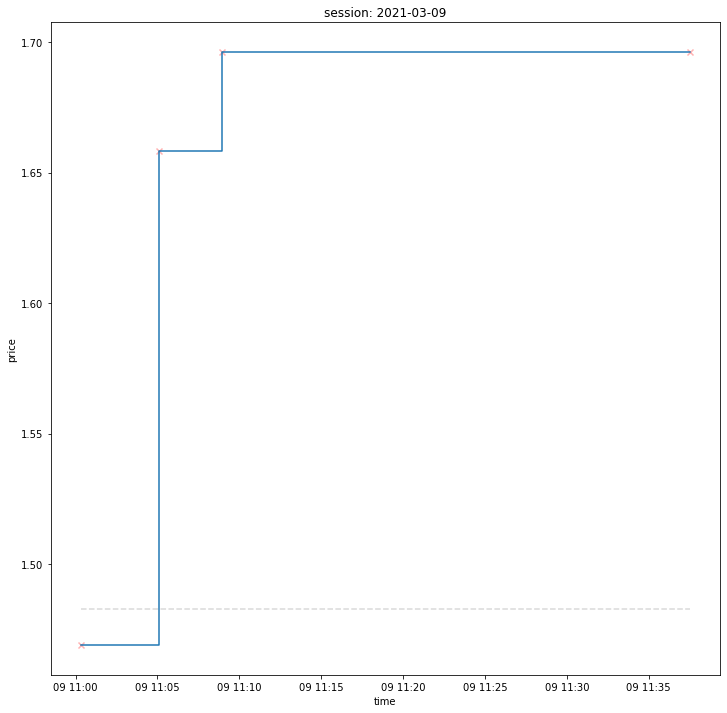

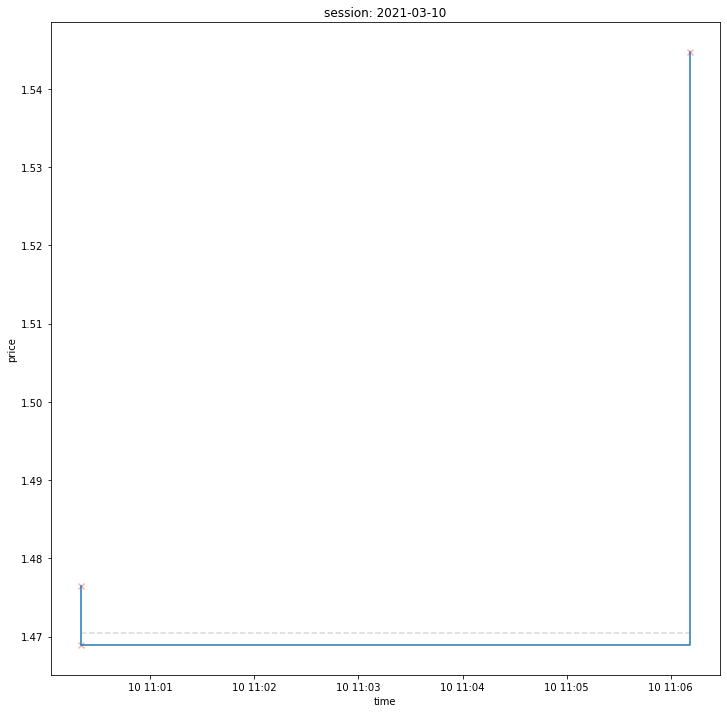

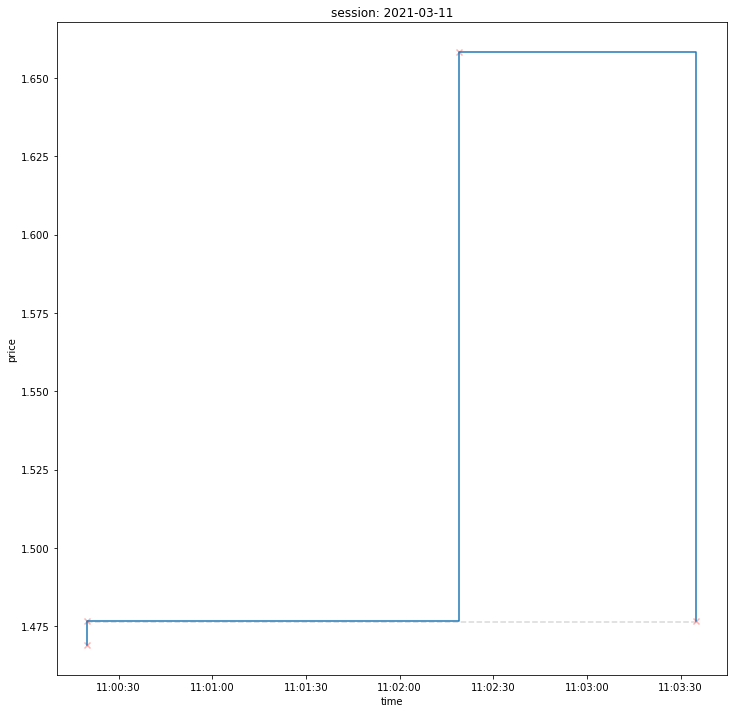

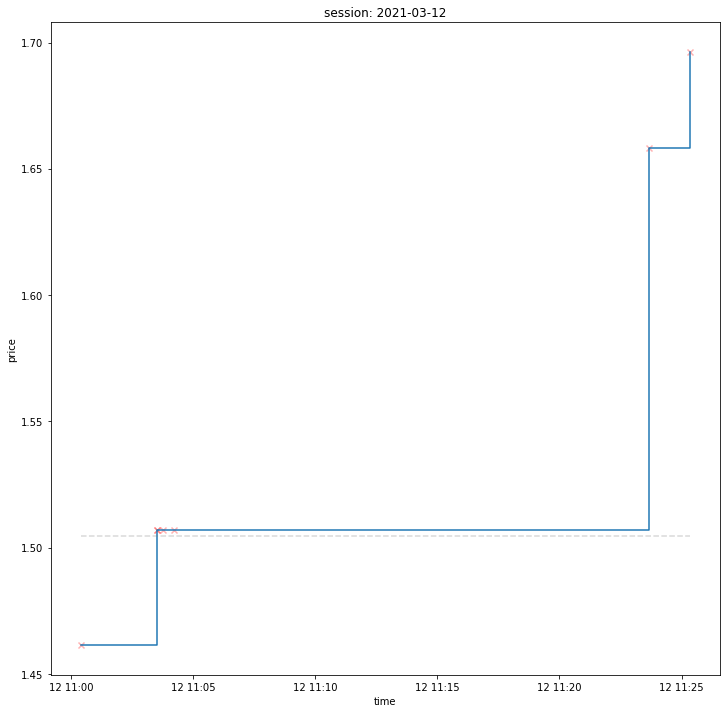

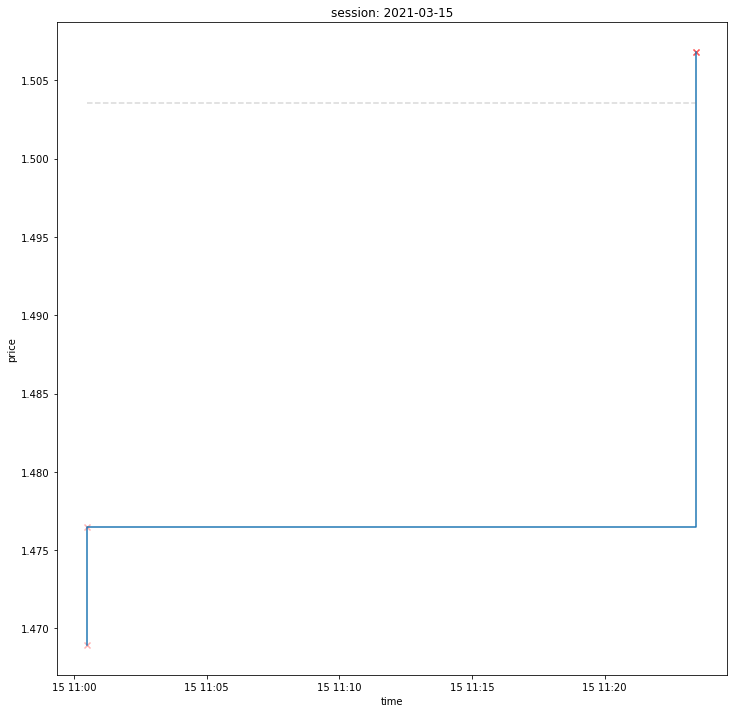

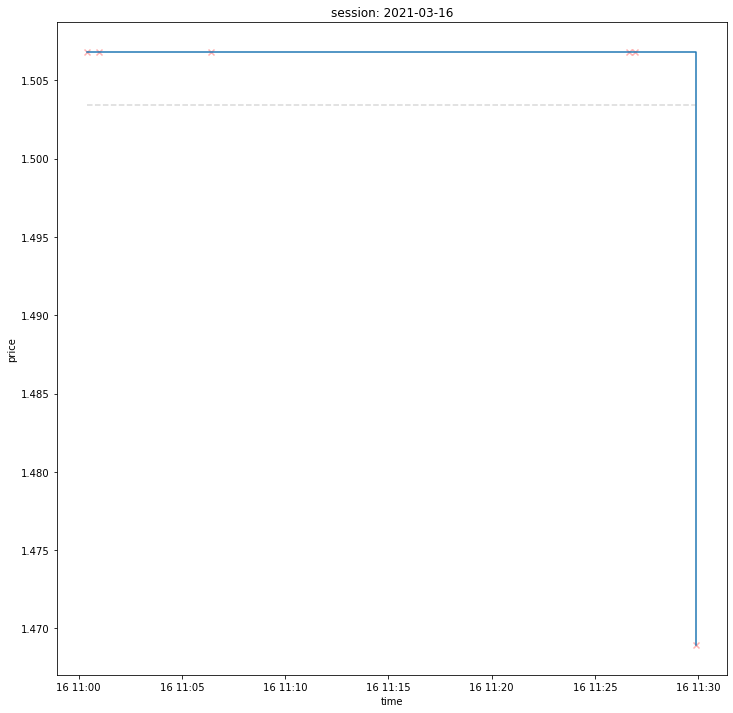

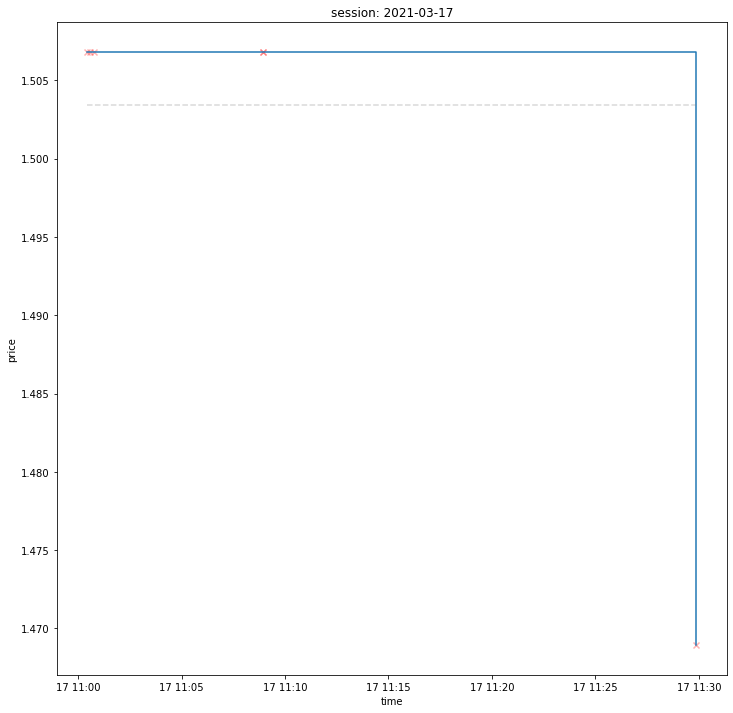

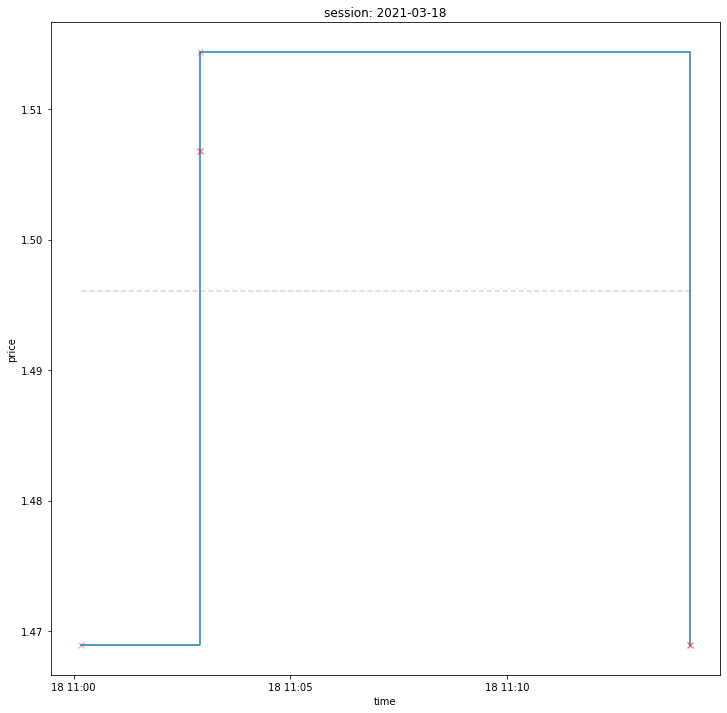

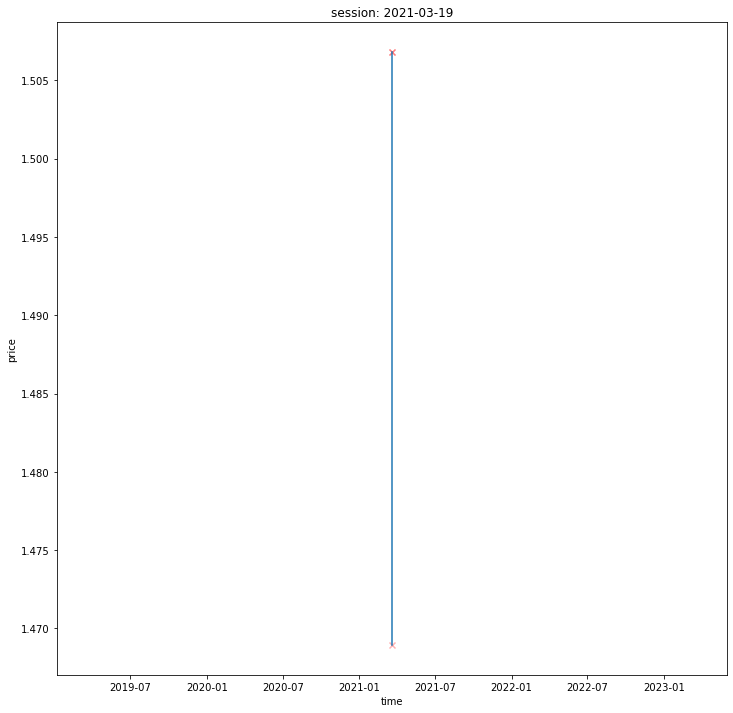

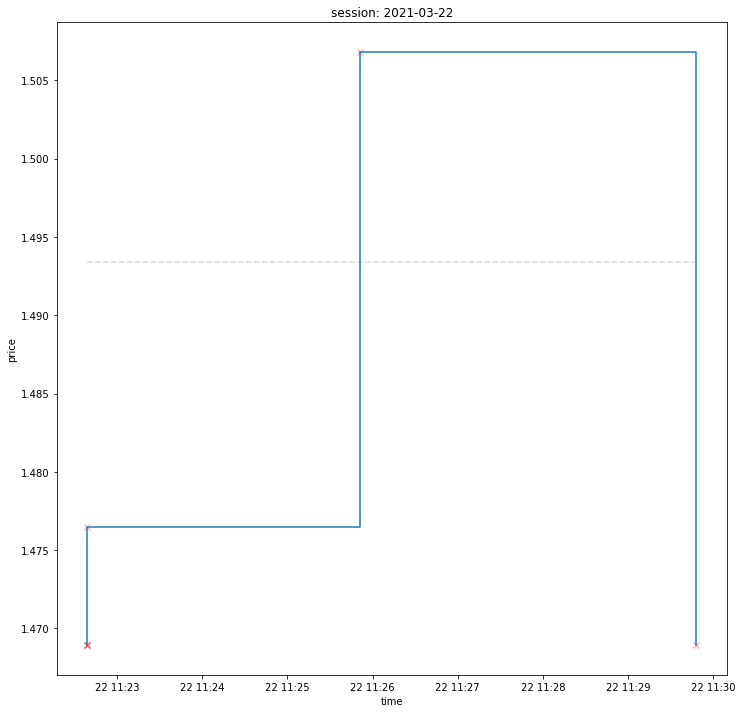

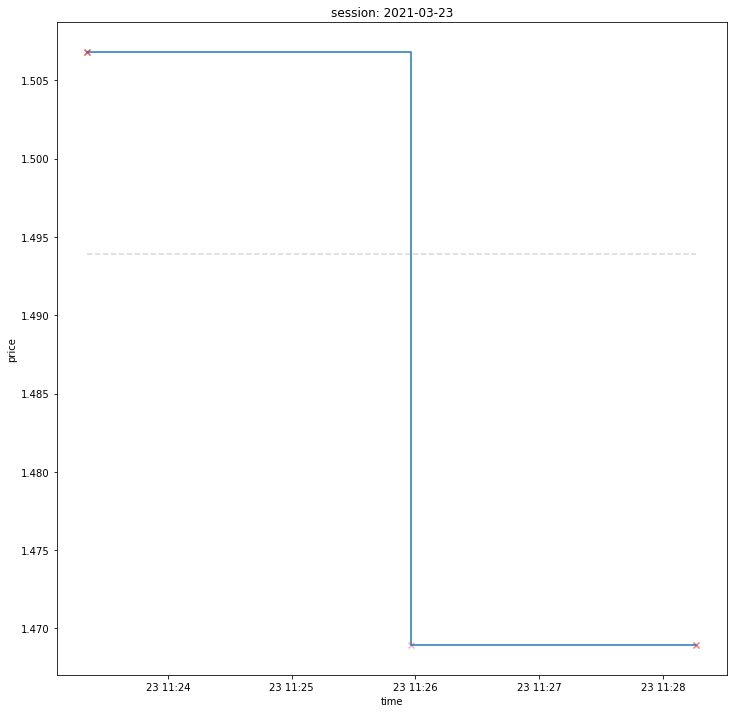

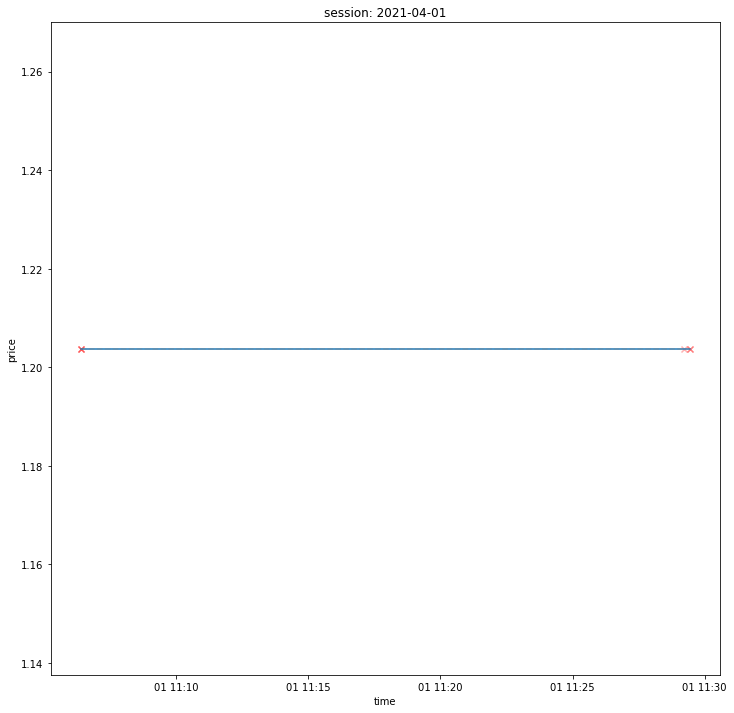

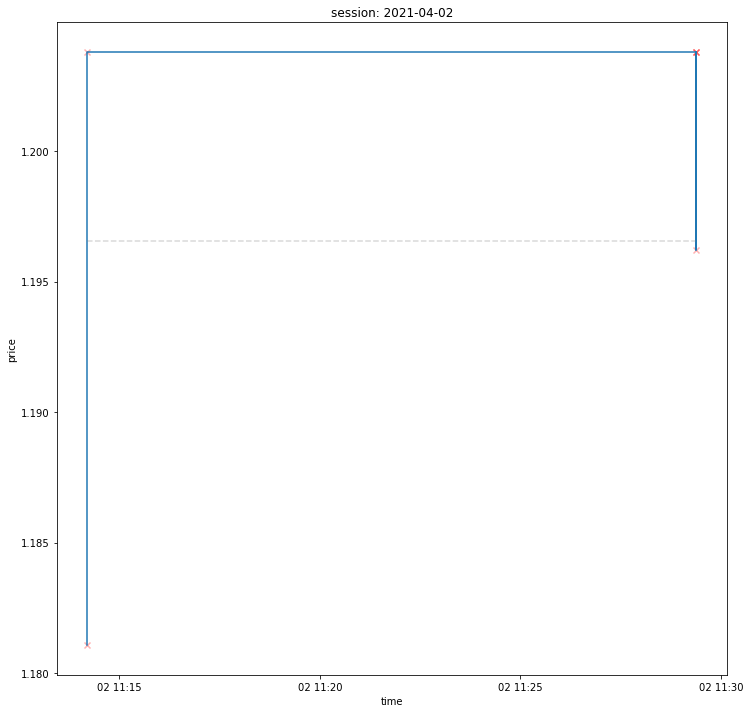

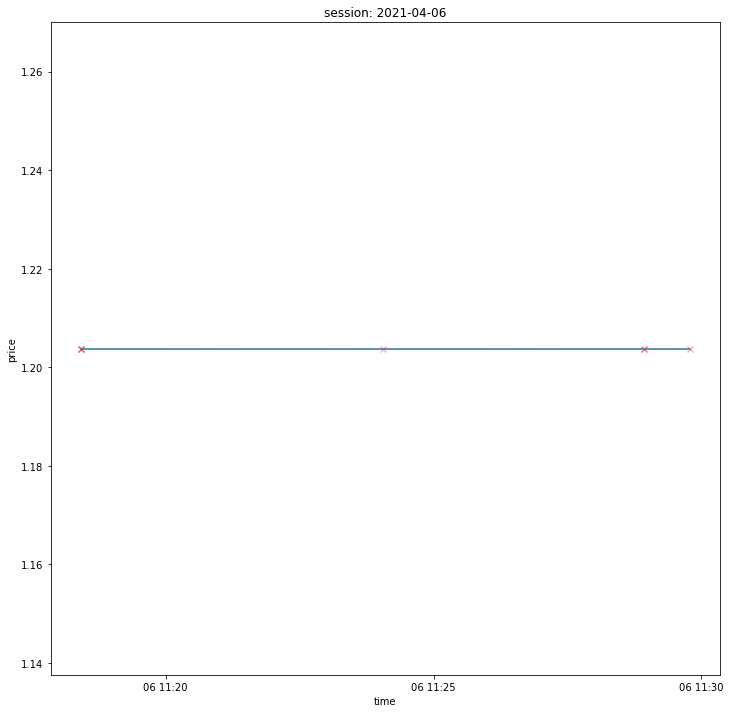

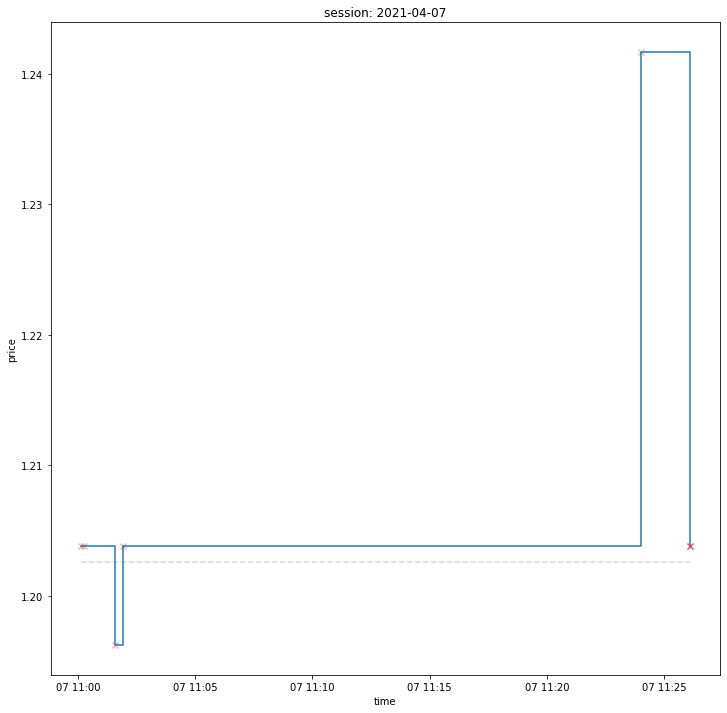

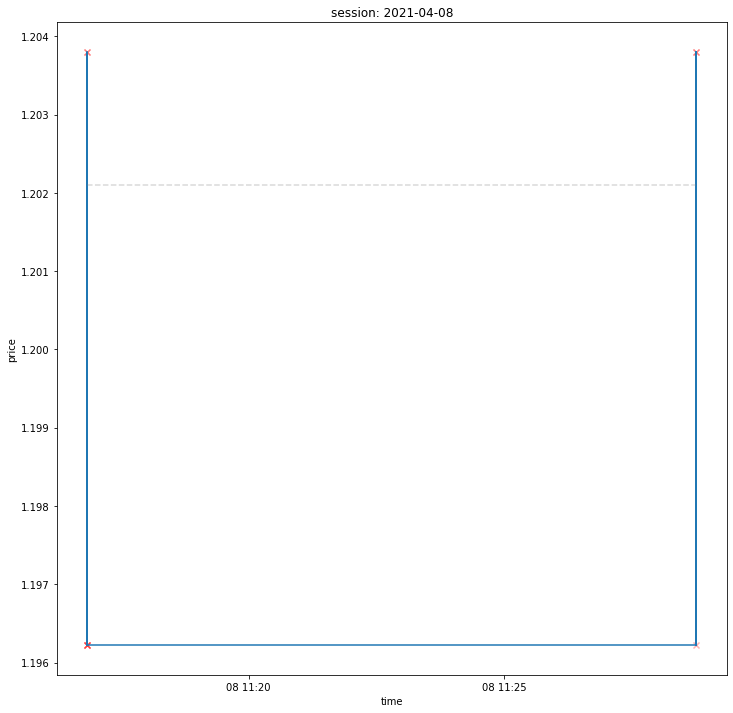

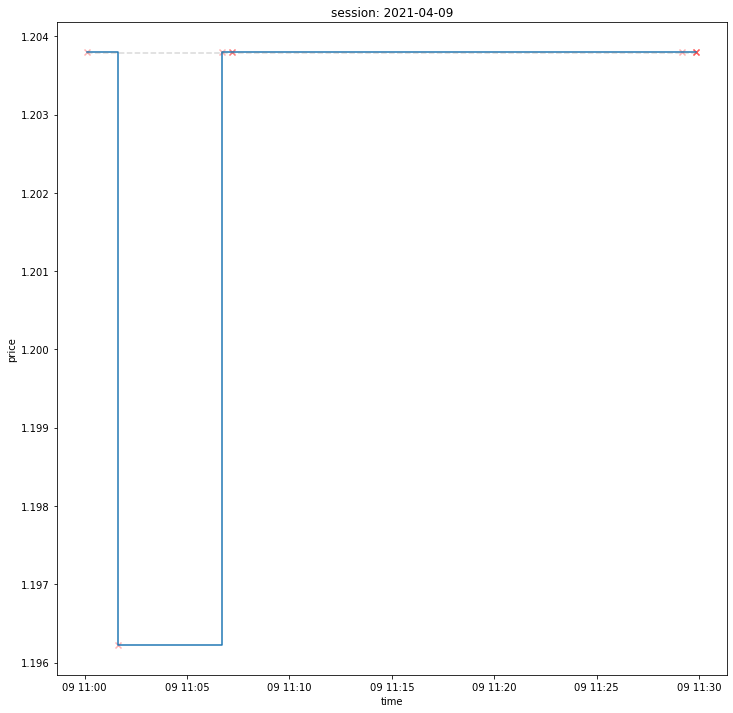

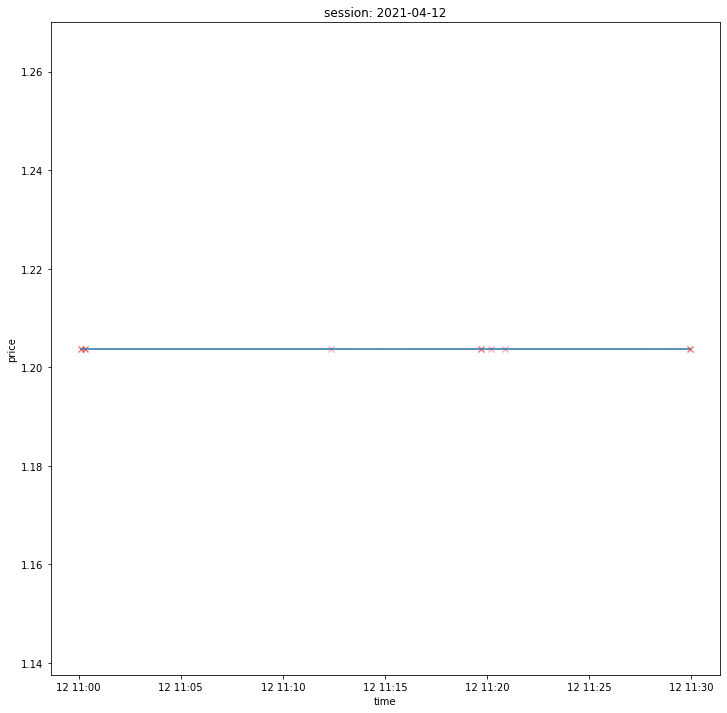

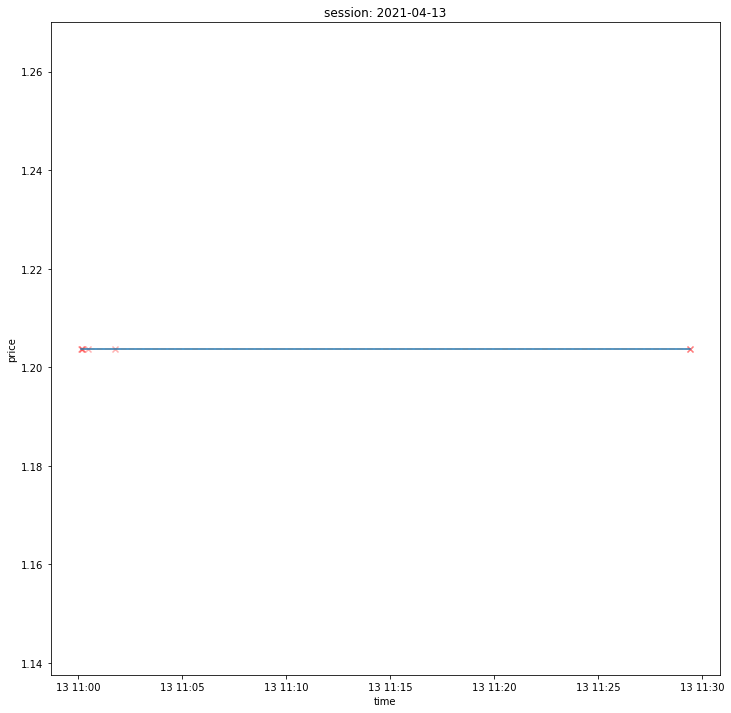

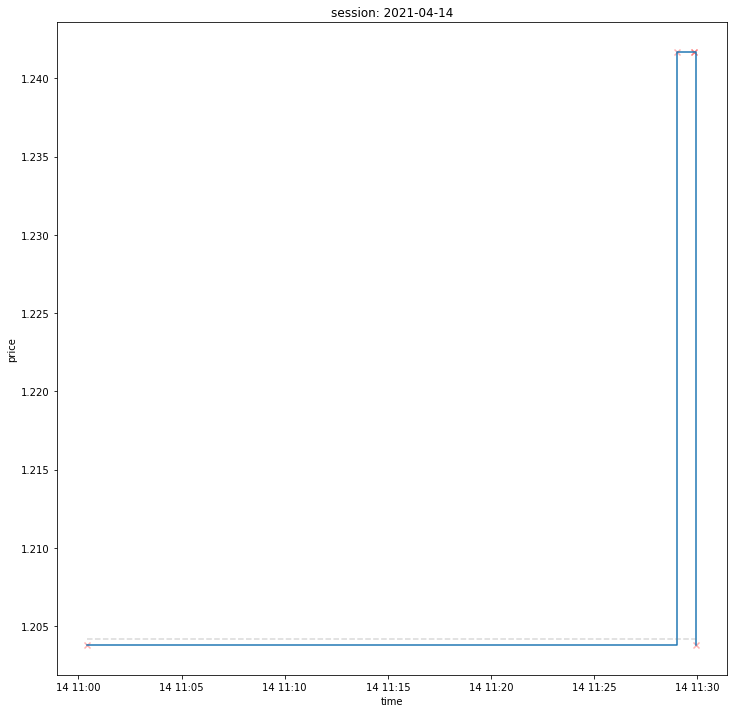

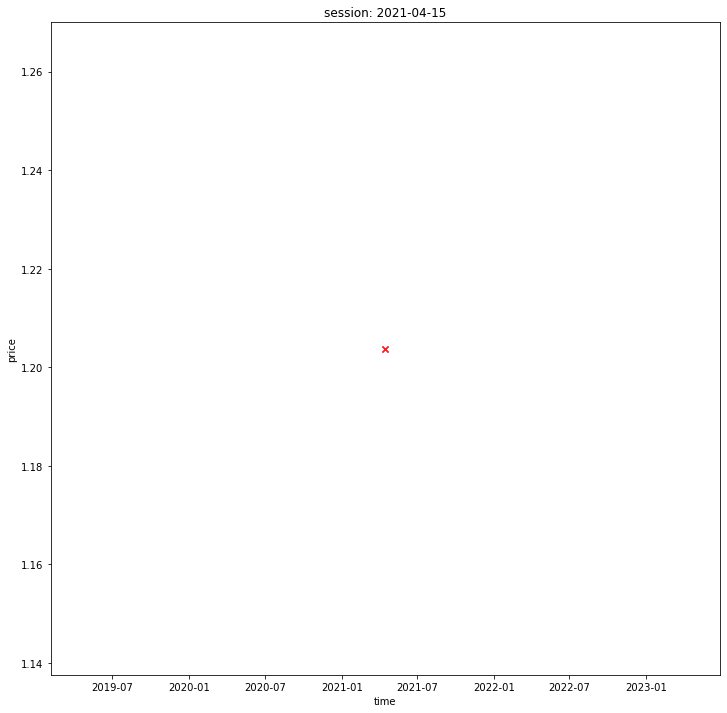

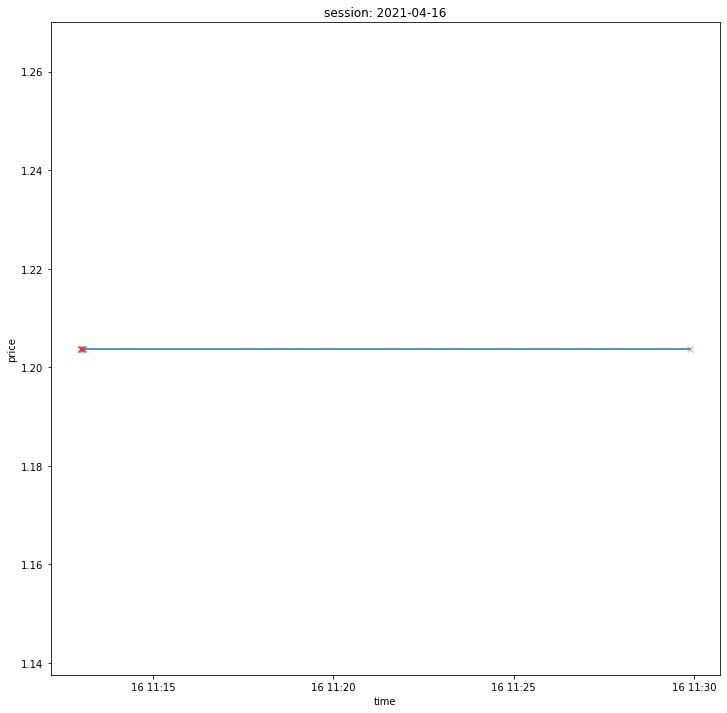

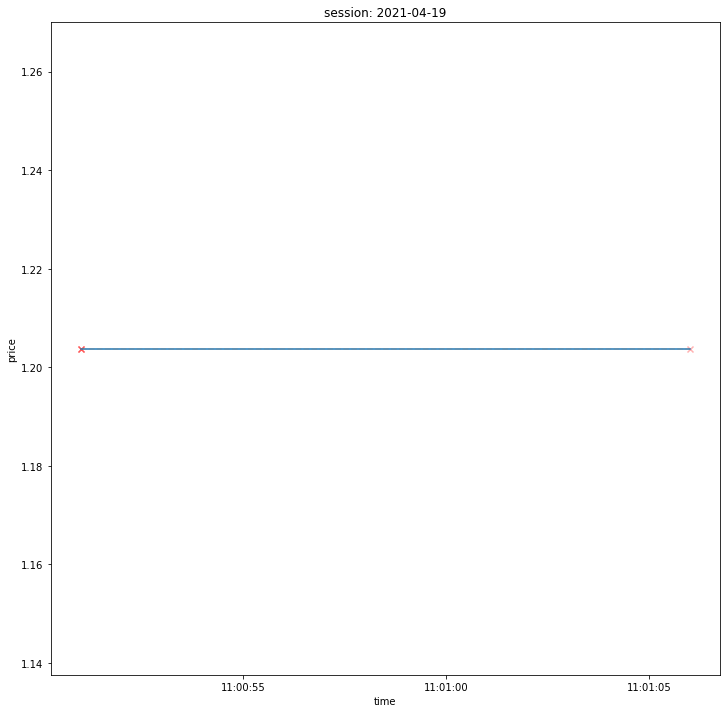

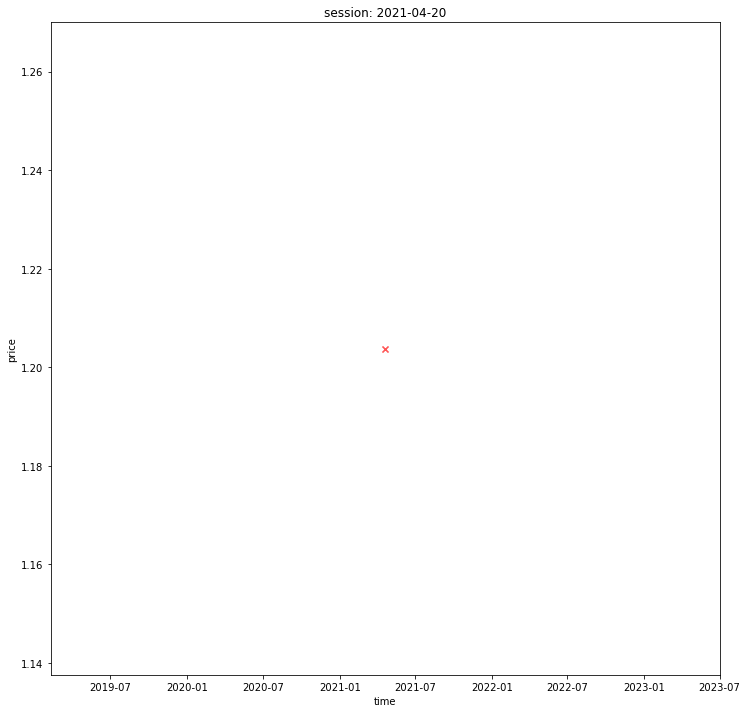

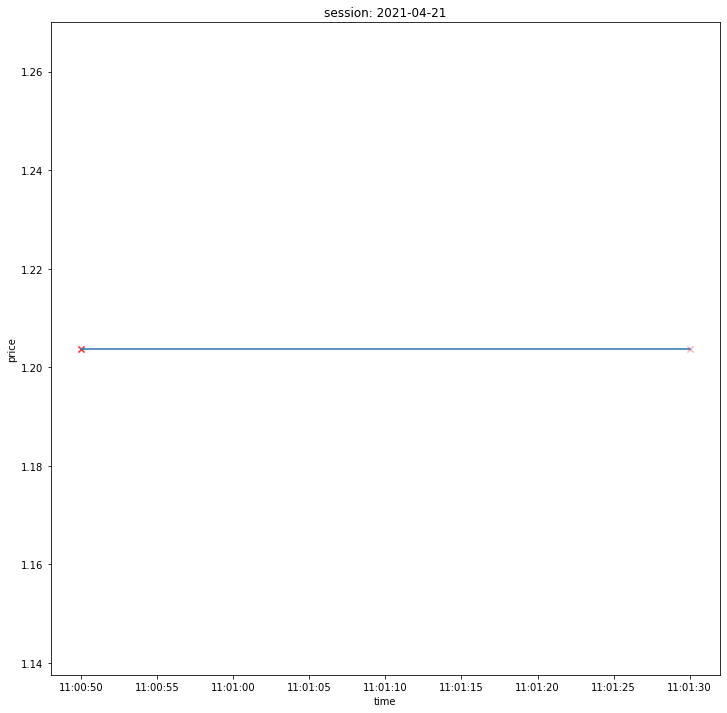

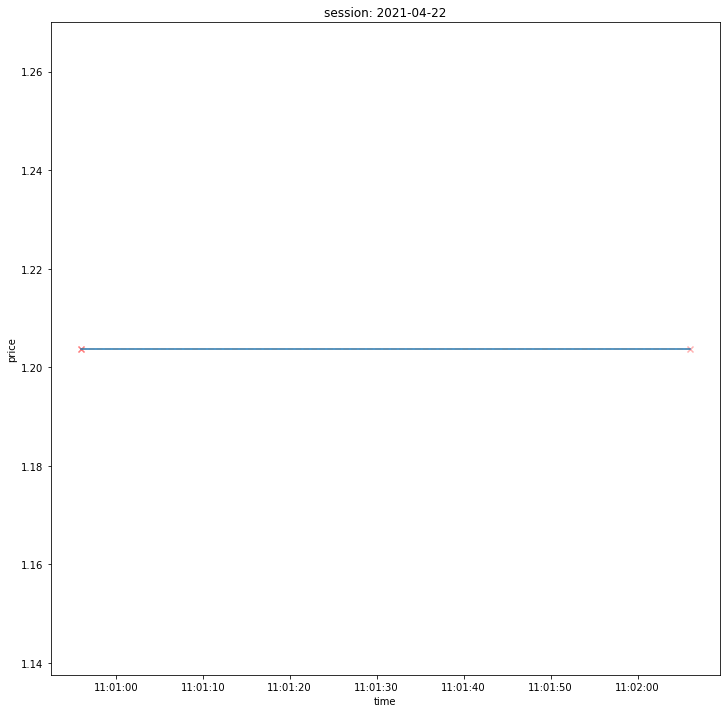

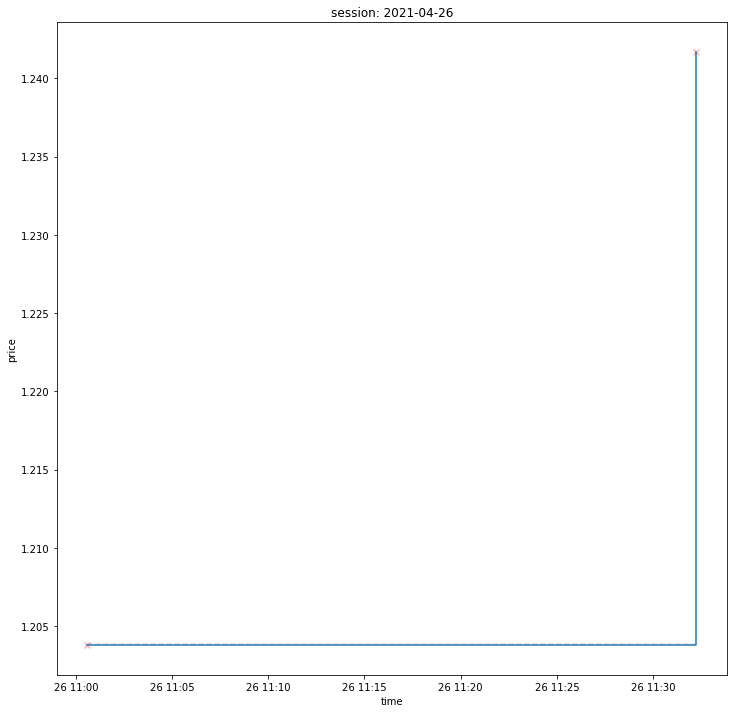

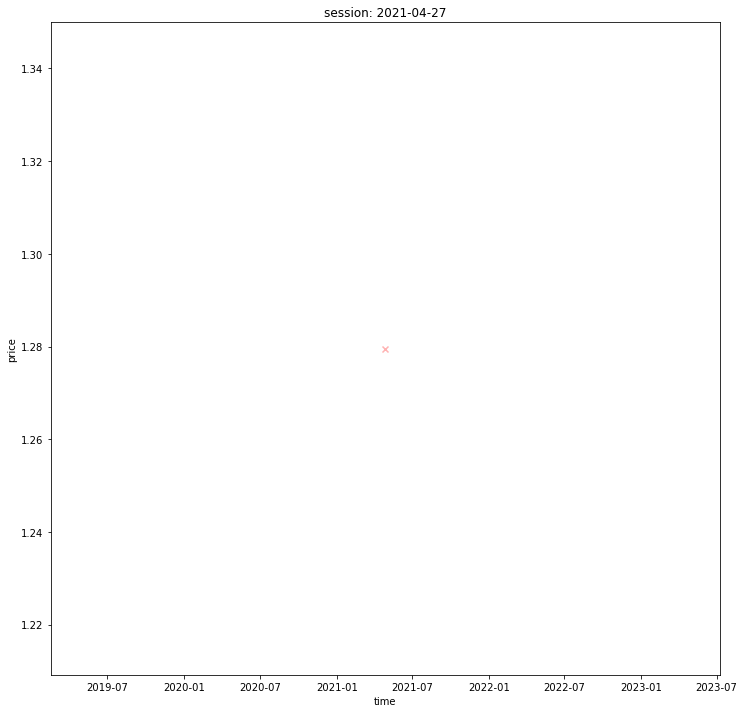

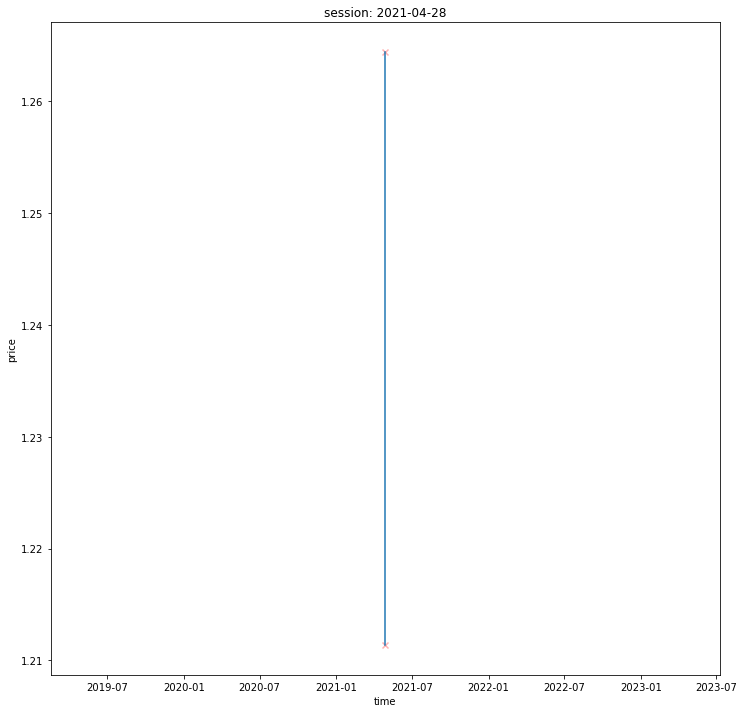

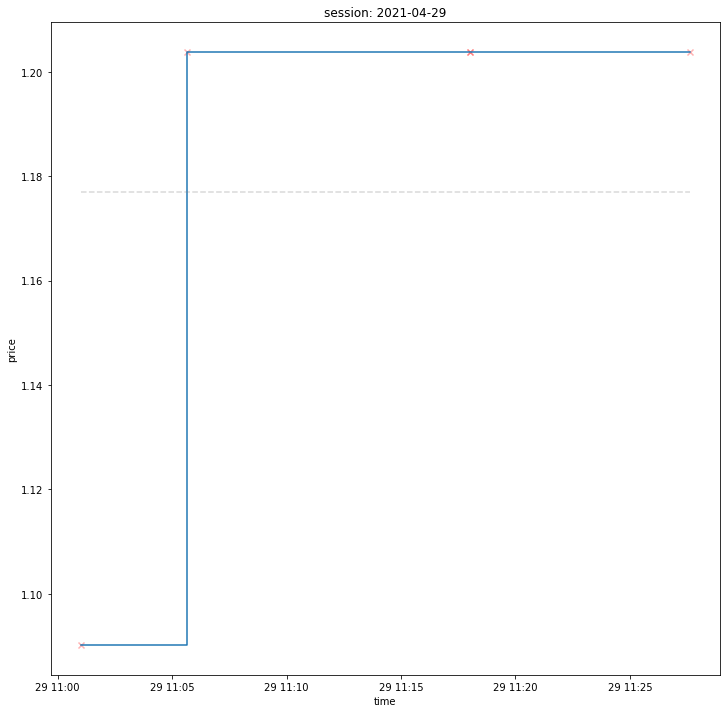

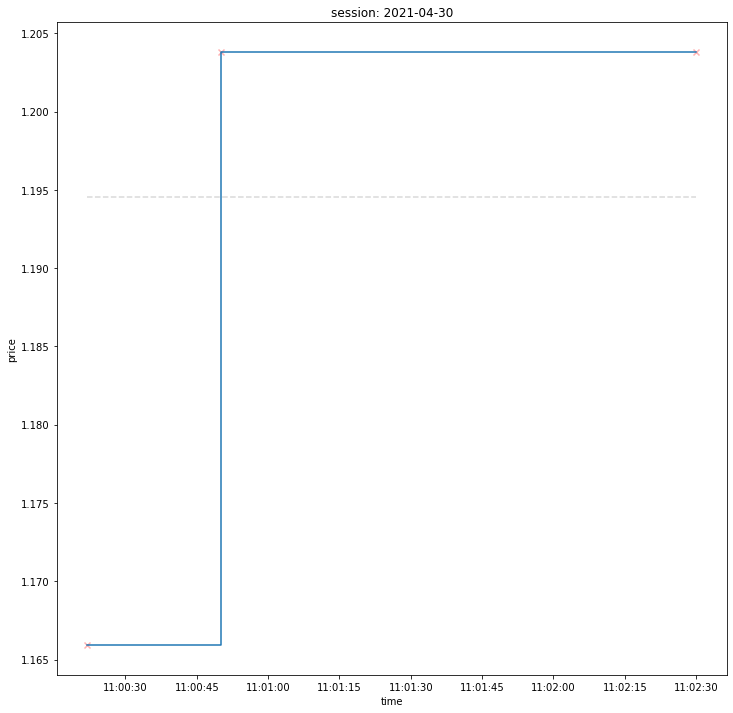

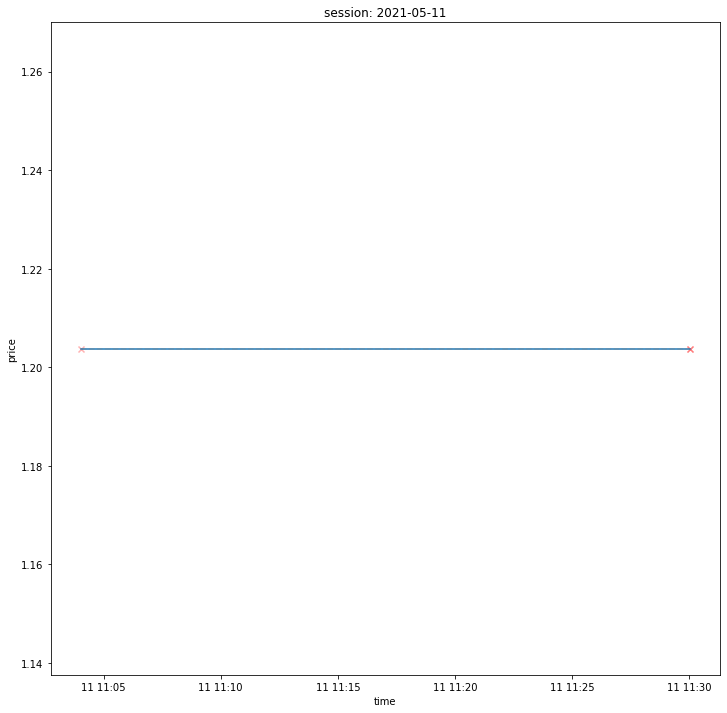

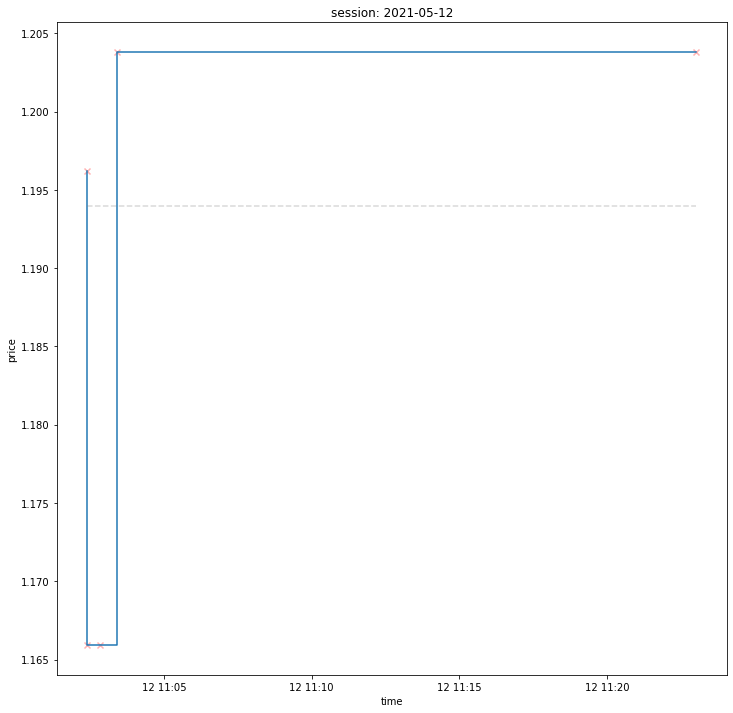

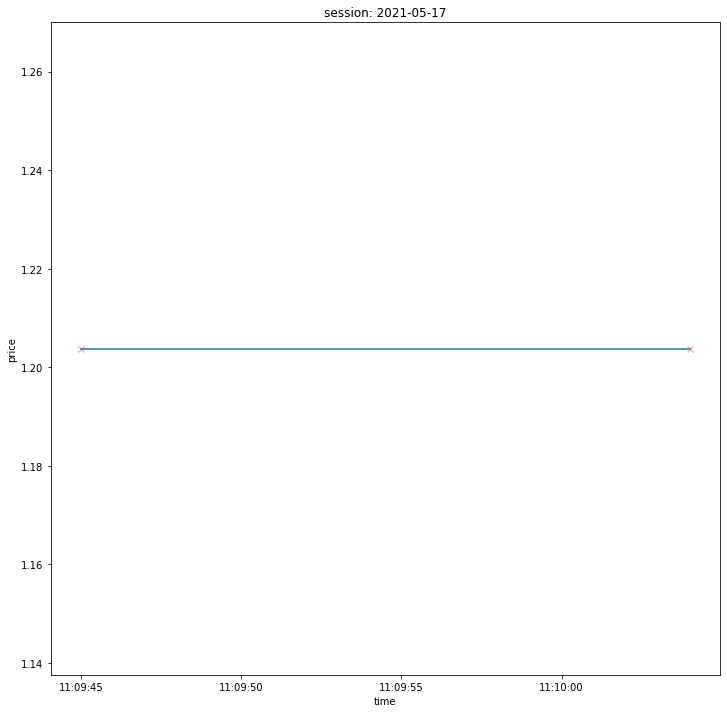

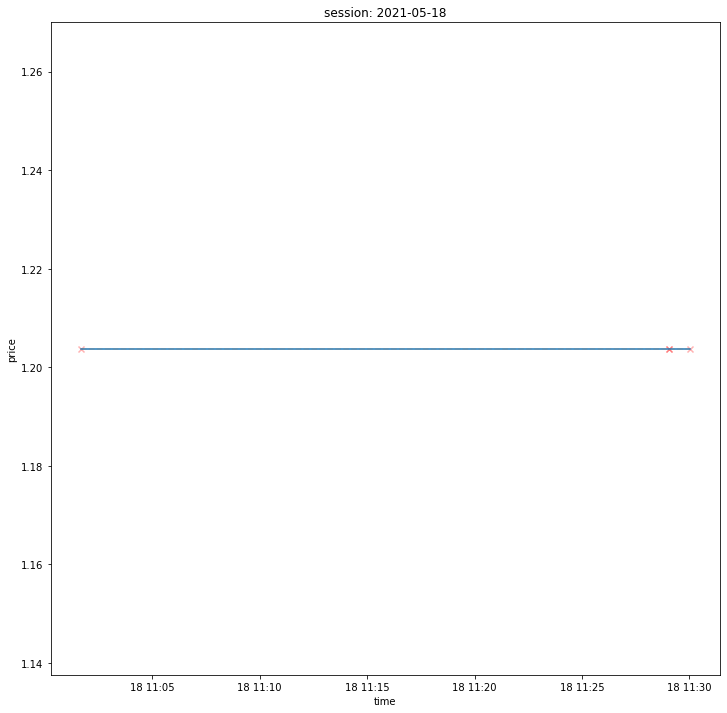

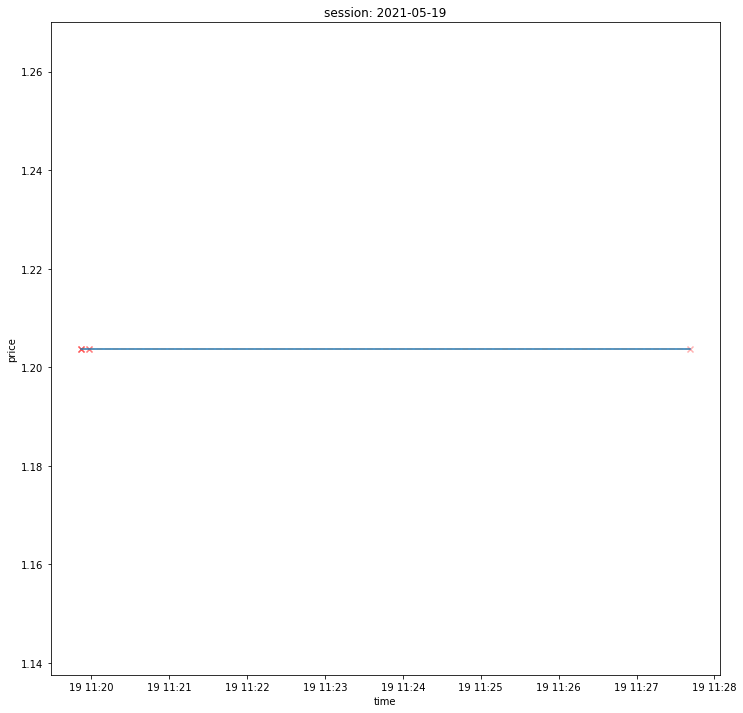

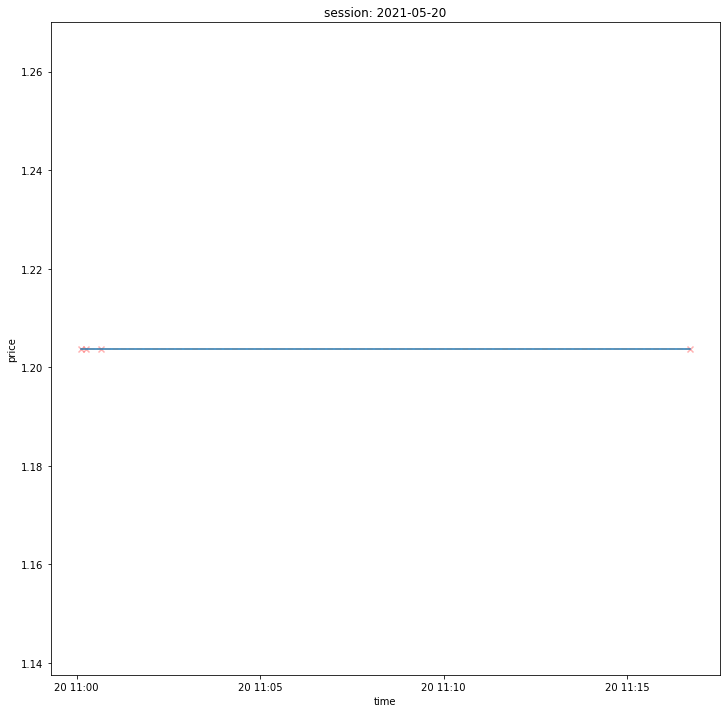

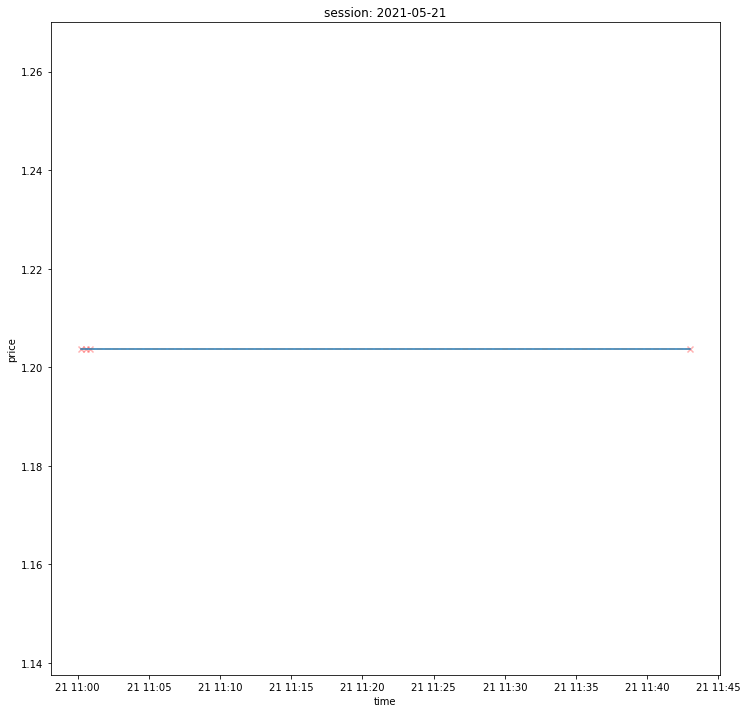

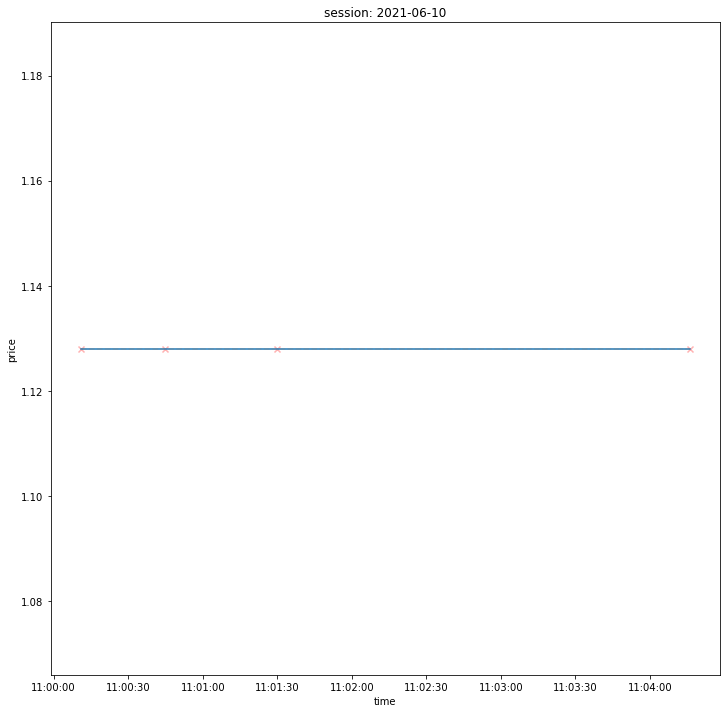

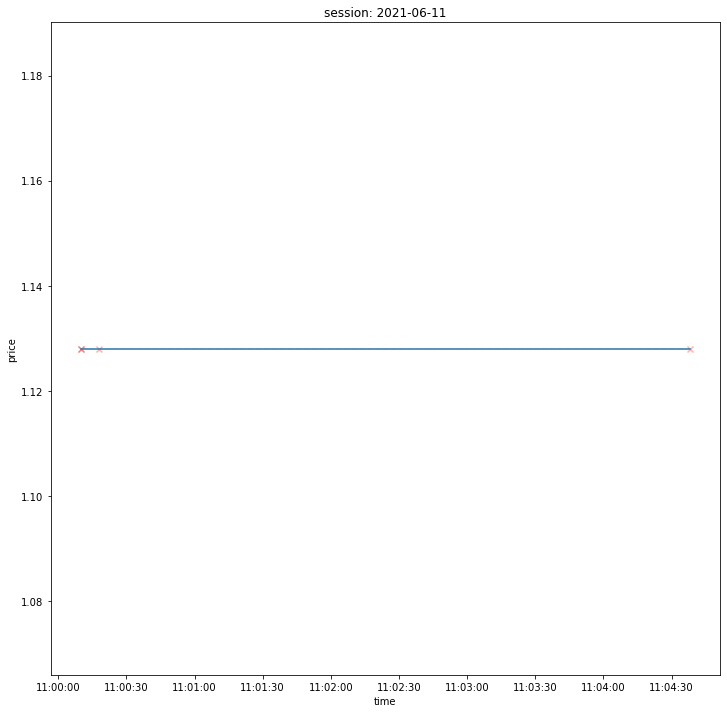

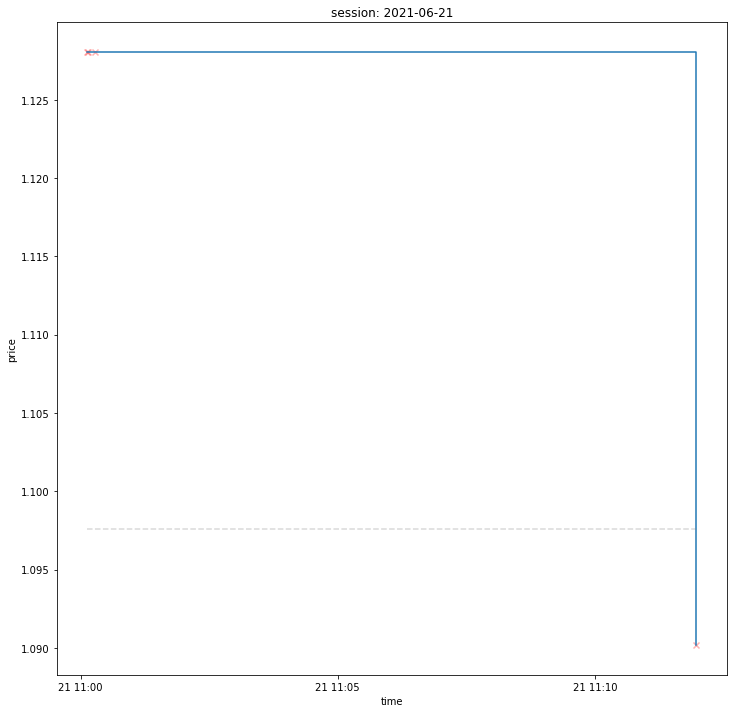

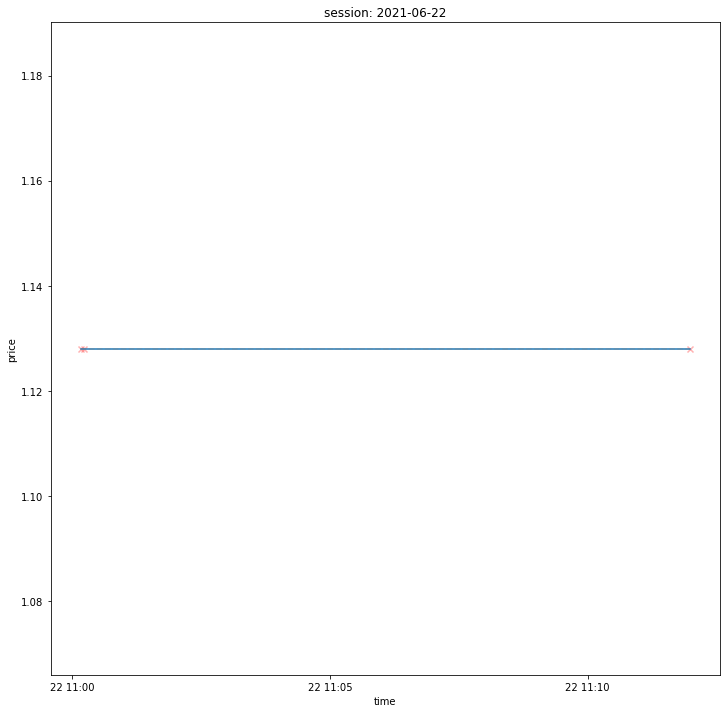

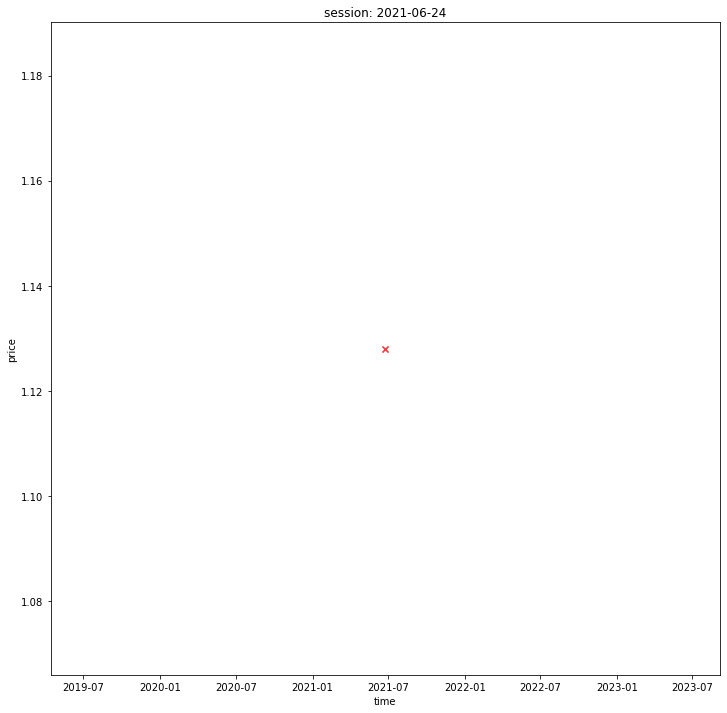

In [723]:
all_session(sess_plat1_day)

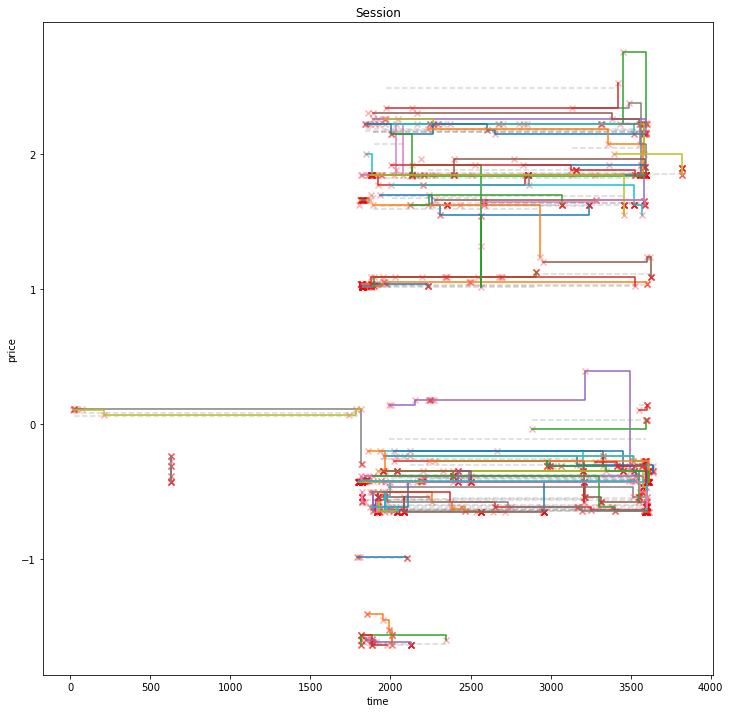

In [715]:
all_session_one_pic(sess_plat2_day)

### Разбиение на минуты

Сессии содержат различное кол-во сделок в различные моменты времени.

Поскольку нас интересуют предсказания на начало каждой минуты, приведем каждую сессию к след виду:
текущая цена на начало каждой новой минуты. Поскольку хотим предсказывать цену, то ...

### DTW

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path, filename="warp.png")

In [ ]:
s1 = [0, 0, 1, 2, 1, 0, 1, 0, 0]
s2 = [0]
distance = dtw.distance(s1, s2)
print(distance)